### Описание набора данных

Данные содержат столбцы метаданных:
* WELL: название скважины
* DEPTH_MD: измеренная глубина
* X_LOC: UTM координата X
* Y_LOC: UTM координата Y
* Z_LOC: ГЛУБИНА
* GROUP: группа литостратиграфии NPD
* FORMATION: формация литостратиграфии NPD

Данные содержат кривые каротажа скважины. Например, следующие:
* BS: Размер бита
* CALI: Калипер
* RDEP: Глубокое сопротивление
* RHOB: Объемная плотность
* GR: Сырые данные гамма-излучения
* SGR: Спектральный гамма-излучение
* RMED: Среднее сопротивление
* ROP: Скорость бурения
* NPHI: Нейтронная пористость
* PEF: Фотоэлектрический коэффициент поглощения
* RSHA: Поверхностное сопротивление
* DTS: Звуковая скорость (поперечная)
* DTC: Звуковая скорость (компрессионная)

а также интерпретацию

* FORCE_2020_LITHOFACIES_LITHOLOGY: классификация литологии
* FORCE_2020_LITHOFACIES_CONFIDENCE: уверенность в интерпретации литологии (1: высокая, 2: средняя, 3: низкая)

### 1. Установка библиотек и загрузка данных

In [1]:
import joblib
import warnings
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from numpy import std
from numpy import mean
import lightgbm as lgbm
import plotly.express as px
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import matplotlib.colors as colors
from sklearn.metrics import f1_score
from pandas import DataFrame, Series
from scipy.ndimage import median_filter
from catboost import CatBoostClassifier
from sklearn.metrics import recall_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder 
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import plot_tree, export_text
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report


sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (20, 16)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [2]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
raw_df = pd.read_csv('../data/Vovle/CSV_train.csv', sep=';')

In [4]:
raw_df.head()

WELL  DEPTH_MD         X_LOC      Y_LOC       Z_LOC         GROUP  \
0  15/9-13   494.528  437641.96875  6470972.5 -469.501831  NORDLAND GP.   
1  15/9-13   494.680  437641.96875  6470972.5 -469.653809  NORDLAND GP.   
2  15/9-13   494.832  437641.96875  6470972.5 -469.805786  NORDLAND GP.   
3  15/9-13   494.984  437641.96875  6470972.5 -469.957794  NORDLAND GP.   
4  15/9-13   495.136  437641.96875  6470972.5 -470.109772  NORDLAND GP.   

  FORMATION       CALI  RSHA      RMED  ...        ROP  DTS  DCAL      DRHO  \
0       NaN  19.480835   NaN  1.611410  ...  34.636410  NaN   NaN -0.574928   
1       NaN  19.468800   NaN  1.618070  ...  34.636410  NaN   NaN -0.570188   
2       NaN  19.468800   NaN  1.626459  ...  34.779556  NaN   NaN -0.574245   
3       NaN  19.459282   NaN  1.621594  ...  39.965164  NaN   NaN -0.586315   
4       NaN  19.453100   NaN  1.602679  ...  57.483765  NaN   NaN -0.597914   

   MUDWEIGHT  RMIC  ROPA  RXO  FORCE_2020_LITHOFACIES_LITHOLOGY  \
0        NaN   NaN   NaN  NaN                             65000   
1        NaN   NaN   NaN  NaN                             65000   
2        NaN   NaN   NaN  NaN                             65000   
3        NaN   NaN   NaN  NaN                             65000   
4        NaN   NaN   NaN  NaN                             65000   

   FORCE_2020_LITHOFACIES_CONFIDENCE  
0                                1.0  
1                                1.0  
2                                1.0  
3                                1.0  
4                                1.0  

[5 rows x 29 columns]

In [5]:
columns_rows = raw_df.shape

In [6]:
columns_rows[0]

1170511

In [7]:
print('Columns of train data is {:}'.format(columns_rows[1]), 'and rows of train data is {:}'.format(columns_rows[0]))

Columns of train data is 29 and rows of train data is 1170511


In [8]:
test_df = pd.read_csv('../data/Vovle/CSV_test.csv', sep=';')

In [9]:
test_df.head()

WELL    DEPTH_MD         X_LOC      Y_LOC       Z_LOC         GROUP  \
0  15/9-14  480.628001  423244.50000  6461862.5 -455.624420  NORDLAND GP.   
1  15/9-14  480.780001  423244.50000  6461862.5 -455.776428  NORDLAND GP.   
2  15/9-14  480.932001  423244.50000  6461862.5 -455.928436  NORDLAND GP.   
3  15/9-14  481.084001  423244.50000  6461862.5 -456.080444  NORDLAND GP.   
4  15/9-14  481.236001  423244.53125  6461862.5 -456.232422  NORDLAND GP.   

  FORMATION     CALI  RSHA      RMED  ...         SP  BS         ROP  DTS  \
0       NaN  19.2031   NaN  1.613886  ...  35.525719 NaN   96.461990  NaN   
1       NaN  19.2031   NaN  1.574376  ...  36.158520 NaN   96.454399  NaN   
2       NaN  19.2031   NaN  1.436627  ...  36.873703 NaN   96.446686  NaN   
3       NaN  19.2031   NaN  1.276094  ...  37.304054 NaN  161.170166  NaN   
4       NaN  19.2031   NaN  1.204704  ...  37.864922 NaN  172.489120  NaN   

   DCAL      DRHO  MUDWEIGHT  RMIC  ROPA  RXO  
0   NaN -0.538873   0.130611   NaN   NaN  NaN  
1   NaN -0.539232   0.130611   NaN   NaN  NaN  
2   NaN -0.540830   0.130611   NaN   NaN  NaN  
3   NaN -0.543943   0.130611   NaN   NaN  NaN  
4   NaN -0.542104   0.130611   NaN   NaN  NaN  

[5 rows x 27 columns]

In [10]:
test_cols_rows = test_df.shape

In [11]:
print('Columns of test data is {:}'.format(test_cols_rows[1]), 'and rows of test data is {:}'.format(test_cols_rows[0]))

Columns of test data is 27 and rows of test data is 136786


### 2. EDA

Просмотр количества значений и типов столбцов

In [12]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1170511 entries, 0 to 1170510
Data columns (total 29 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   WELL                               1170511 non-null  object 
 1   DEPTH_MD                           1170511 non-null  float64
 2   X_LOC                              1159736 non-null  float64
 3   Y_LOC                              1159736 non-null  float64
 4   Z_LOC                              1159736 non-null  float64
 5   GROUP                              1169233 non-null  object 
 6   FORMATION                          1033517 non-null  object 
 7   CALI                               1082634 non-null  float64
 8   RSHA                               630650 non-null   float64
 9   RMED                               1131518 non-null  float64
 10  RDEP                               1159496 non-null  float64
 11  RHOB                    

Описательная статистика численных столбцов

In [13]:
raw_df.describe()

DEPTH_MD         X_LOC         Y_LOC         Z_LOC          CALI  \
count  1.170511e+06  1.159736e+06  1.159736e+06  1.159736e+06  1.082634e+06   
mean   2.184087e+03  4.856310e+05  6.681276e+06 -2.138527e+03  1.318568e+01   
std    9.971821e+02  3.455641e+04  1.281524e+05  9.709426e+02  3.798907e+00   
min    1.360860e+02  4.268988e+05  6.406641e+06 -5.395563e+03  2.344000e+00   
25%    1.418597e+03  4.547996e+05  6.591327e+06 -2.811502e+03  9.429712e+00   
50%    2.076605e+03  4.769203e+05  6.737311e+06 -2.042785e+03  1.255575e+01   
75%    2.864393e+03  5.201532e+05  6.784886e+06 -1.391866e+03  1.671075e+01   
max    5.436632e+03  5.726328e+05  6.856661e+06 -1.110860e+02  2.827900e+01   

                RSHA          RMED          RDEP          RHOB            GR  \
count  630650.000000  1.131518e+06  1.159496e+06  1.009242e+06  1.170511e+06   
mean       10.694664  4.986978e+00  1.069103e+01  2.284987e+00  7.091370e+01   
std       100.642597  5.467269e+01  1.139480e+02  2.532835e-01  3.423149e+01   
min         0.000100 -8.418695e-03  3.170056e-02  7.209712e-01  1.092843e-01   
25%         0.854120  9.140862e-01  9.102396e-01  2.092203e+00  4.762722e+01   
50%         1.399020  1.443584e+00  1.439000e+00  2.321228e+00  6.836763e+01   
75%         3.099348  2.680930e+00  2.557220e+00  2.488580e+00  8.903551e+01   
max      2193.904541  1.988616e+03  1.999887e+03  3.457820e+00  1.076964e+03   

       ...            ROP            DTS           DCAL           DRHO  \
count  ...  535071.000000  174613.000000  298833.000000  987857.000000   
mean   ...     137.367965     204.655019       1.223849       0.012196   
std    ...    1539.383558      71.068461      54.372859       7.477798   
min    ...      -0.117977      69.163177     -12.215459   -7429.338867   
25%    ...       5.628000     155.936707       0.148438      -0.009253   
50%    ...      17.799999     188.200653       0.557320       0.001752   
75%    ...      34.812794     224.645081       1.299655       0.021702   
max    ...   47015.125000     676.578125   10011.422852       2.836938   

           MUDWEIGHT           RMIC           ROPA            RXO  \
count  316151.000000  176160.000000  192325.000000  327427.000000   
mean        1.216329       7.796809      23.505069     -95.779496   
std        10.180834      89.741807      22.632800     348.980030   
min         0.125818       0.056586    -999.250122    -999.900024   
25%         0.143792       0.891272      11.281895       0.687681   
50%         0.155774       1.967156      20.131153       1.366672   
75%         1.168307       5.084564      31.138481       3.420790   
max       185.730927   10000.000000     742.797852   35930.671875   

       FORCE_2020_LITHOFACIES_LITHOLOGY  FORCE_2020_LITHOFACIES_CONFIDENCE  
count                      1.170511e+06                       1.170332e+06  
mean                       6.138598e+04                       1.164258e+00  
std                        1.389170e+04                       4.451180e-01  
min                        3.000000e+04                       1.000000e+00  
25%                        6.500000e+04                       1.000000e+00  
50%                        6.500000e+04                       1.000000e+00  
75%                        6.500000e+04                       1.000000e+00  
max                        9.900000e+04                       3.000000e+00  

[8 rows x 26 columns]

Количество записей по каждой из горных пород

In [14]:
raw_df['FORCE_2020_LITHOFACIES_LITHOLOGY'].value_counts()

65000    720803
30000    168937
65030    150455
70000     56320
80000     33329
99000     15245
70032     10513
88000      8213
90000      3820
74000      1688
86000      1085
93000       103
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, dtype: int64

In [18]:
well_names_uniq = raw_df.WELL.unique()
X_cor = raw_df.groupby(['WELL'])['X_LOC'].mean()  #location coordinate 
Y_cor = raw_df.groupby(['WELL'])['Y_LOC'].mean()
data_count = raw_df.groupby(['WELL']).count().sum(axis='columns')

loc_wells_df = pd.DataFrame({'WELL':well_names_uniq, 'X_LOC': X_cor, 'Y_LOC': Y_cor, 'data_points': data_count})

In [21]:
xx = loc_wells_df.X_LOC
yy = loc_wells_df.Y_LOC
ss = loc_wells_df.data_points
ind = loc_wells_df.index
#cc = loc_wells_df.well_type

def mapPlot():
    fig, ax = plt.subplots(figsize=(18,10))

    sns.scatterplot(data=loc_wells_df, x=xx, y=yy, size=ss, alpha=.7,
                 palette=['red', 'blue', 'green'],sizes=(10, 300), ax=ax)

    ax.set_title('Well Distributions: circle size based on data availability', fontsize = '16')
    ax.set_xlabel('X_coordinate (UTM)', fontsize = '12')
    ax.set_ylabel('Y_coordinate (UTM)', fontsize = '12')

    for x,y,z in zip(xx,yy,ind):
        label_s = "{}".format(z)
        ax.annotate(label_s, (x,y),  textcoords="offset points", 
                 xytext=(0,10), ha='center', fontsize = '8') 

    ax.grid(True, color='0.6',axis='both', dashes=(5,2,1,2))

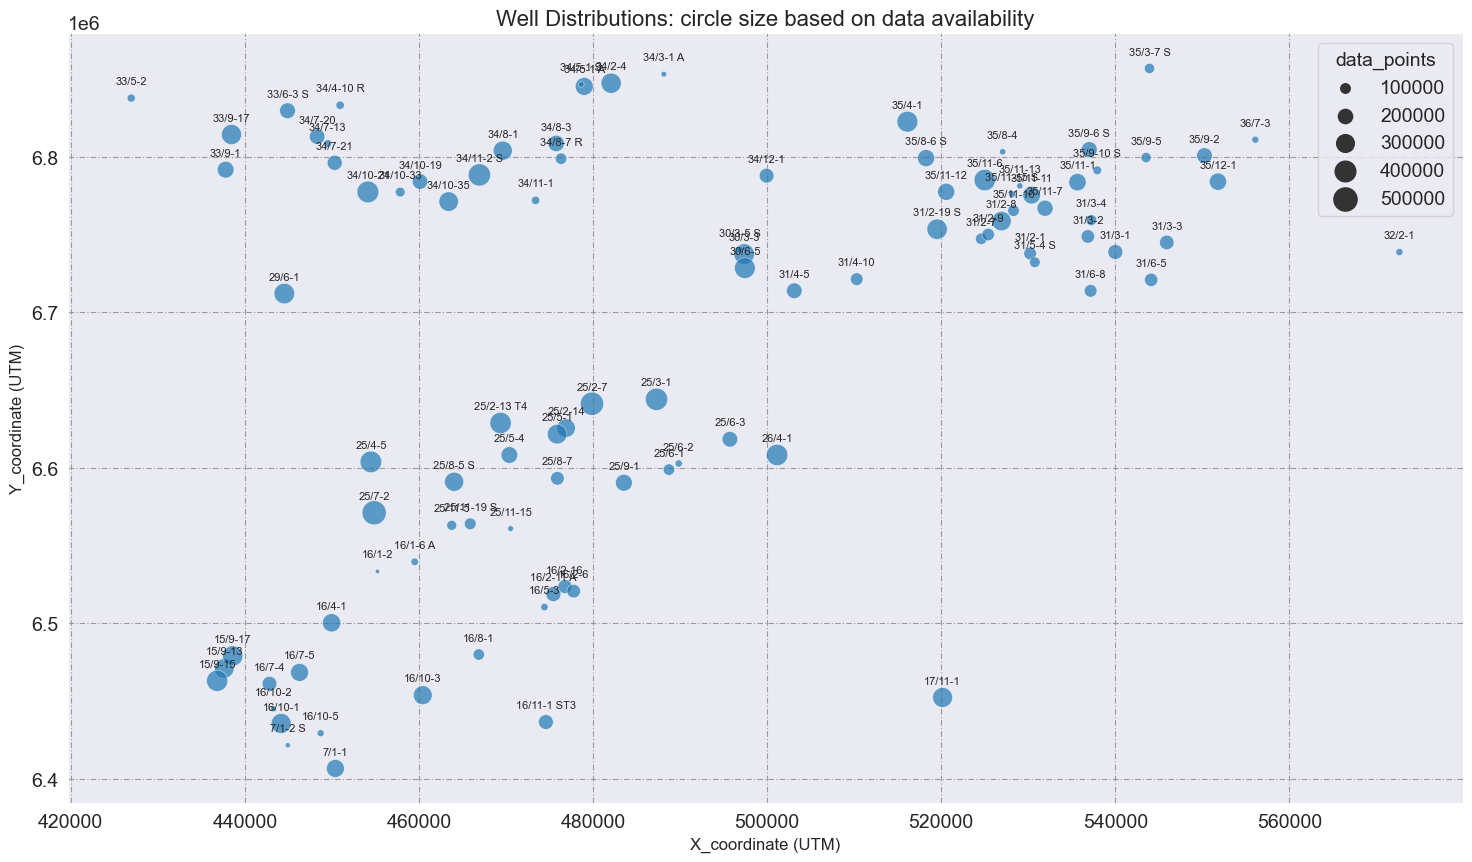

In [22]:
mapPlot()

#### 2.2 Визуализация каротажных кривых

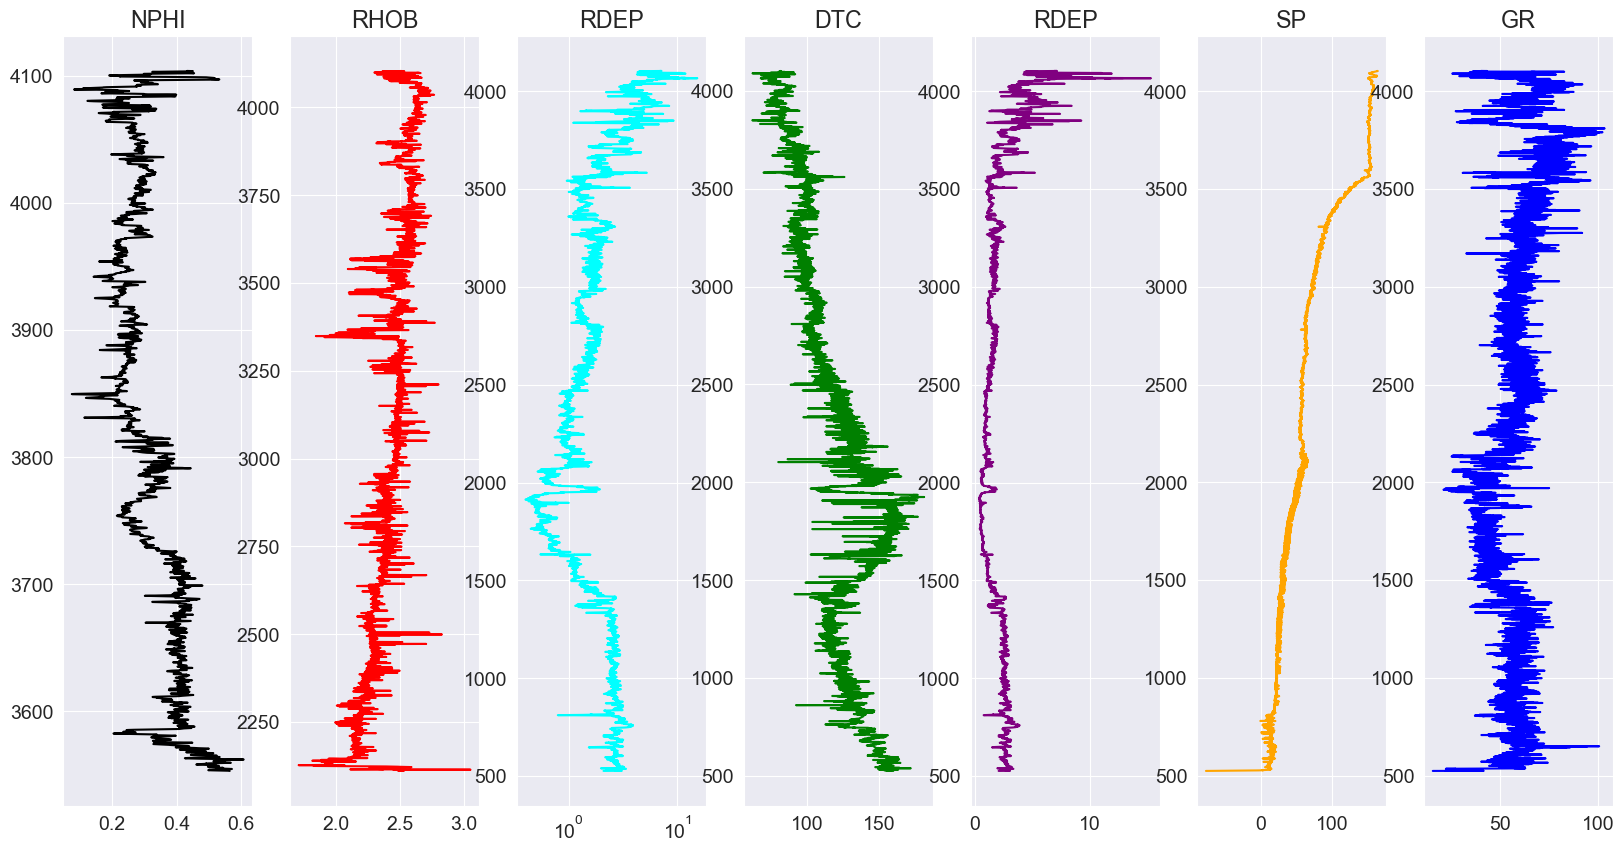

In [30]:
logs = ['NPHI', 'RHOB', 'RDEP', 'DTC', 'RDEP', 'SP', 'GR']

fig, ax = plt.subplots(nrows=1, ncols=len(logs), figsize=(20,10))

colors = ['black', 'red', 'cyan', 'green', 'purple', 'orange', 'blue', 'yellow', 'magenta', 'brown', 'pink', 'lime']

for i in range(len(logs)):
    if i == 2:
    # for resistivity, semilog plot
        ax[i].semilogx(raw_df.loc[raw_df['WELL'] == '34/2-4'][logs[i]], raw_df.loc[raw_df['WELL'] == '34/2-4']['DEPTH_MD'], color=colors[i])
    else:
    # for non-resistivity, normal plot
        ax[i].plot(raw_df.loc[raw_df['WELL'] == '34/2-4'][logs[i]], raw_df.loc[raw_df['WELL'] == '34/2-4']['DEPTH_MD'], color=colors[i])

    ax[i].set_title(logs[i])

plt.show()

### 2.3 Визуализации

Визуализируем количество записей о каждой горной породе

In [25]:
lithology_keys = {} # initialize dictionary
litho=['Sandstone', 'Shale', 'SandyShale', 'Limestone', 'Chalk', 'Dolomite', 
       'Marl', 'Anhydrite', 'Halite', 'Coal', 'Basement', 'Tuff']
col = np.sort(raw_df['FORCE_2020_LITHOFACIES_LITHOLOGY'].unique())
for index, name in enumerate(col):
    lithology_keys[name] = litho[index]
    
lithology_keys = {30000: 'Sandstone',
                 65030: 'Sandstone/Shale',
                 65000: 'Shale',
                 80000: 'Marl',
                 74000: 'Dolomite',
                 70000: 'Limestone',
                 70032: 'Chalk',
                 88000: 'Halite',
                 86000: 'Anhydrite',
                 99000: 'Tuff',
                 90000: 'Coal',
                 93000: 'Basement'}

raw_df['FaciesLabels'] = raw_df['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_keys)

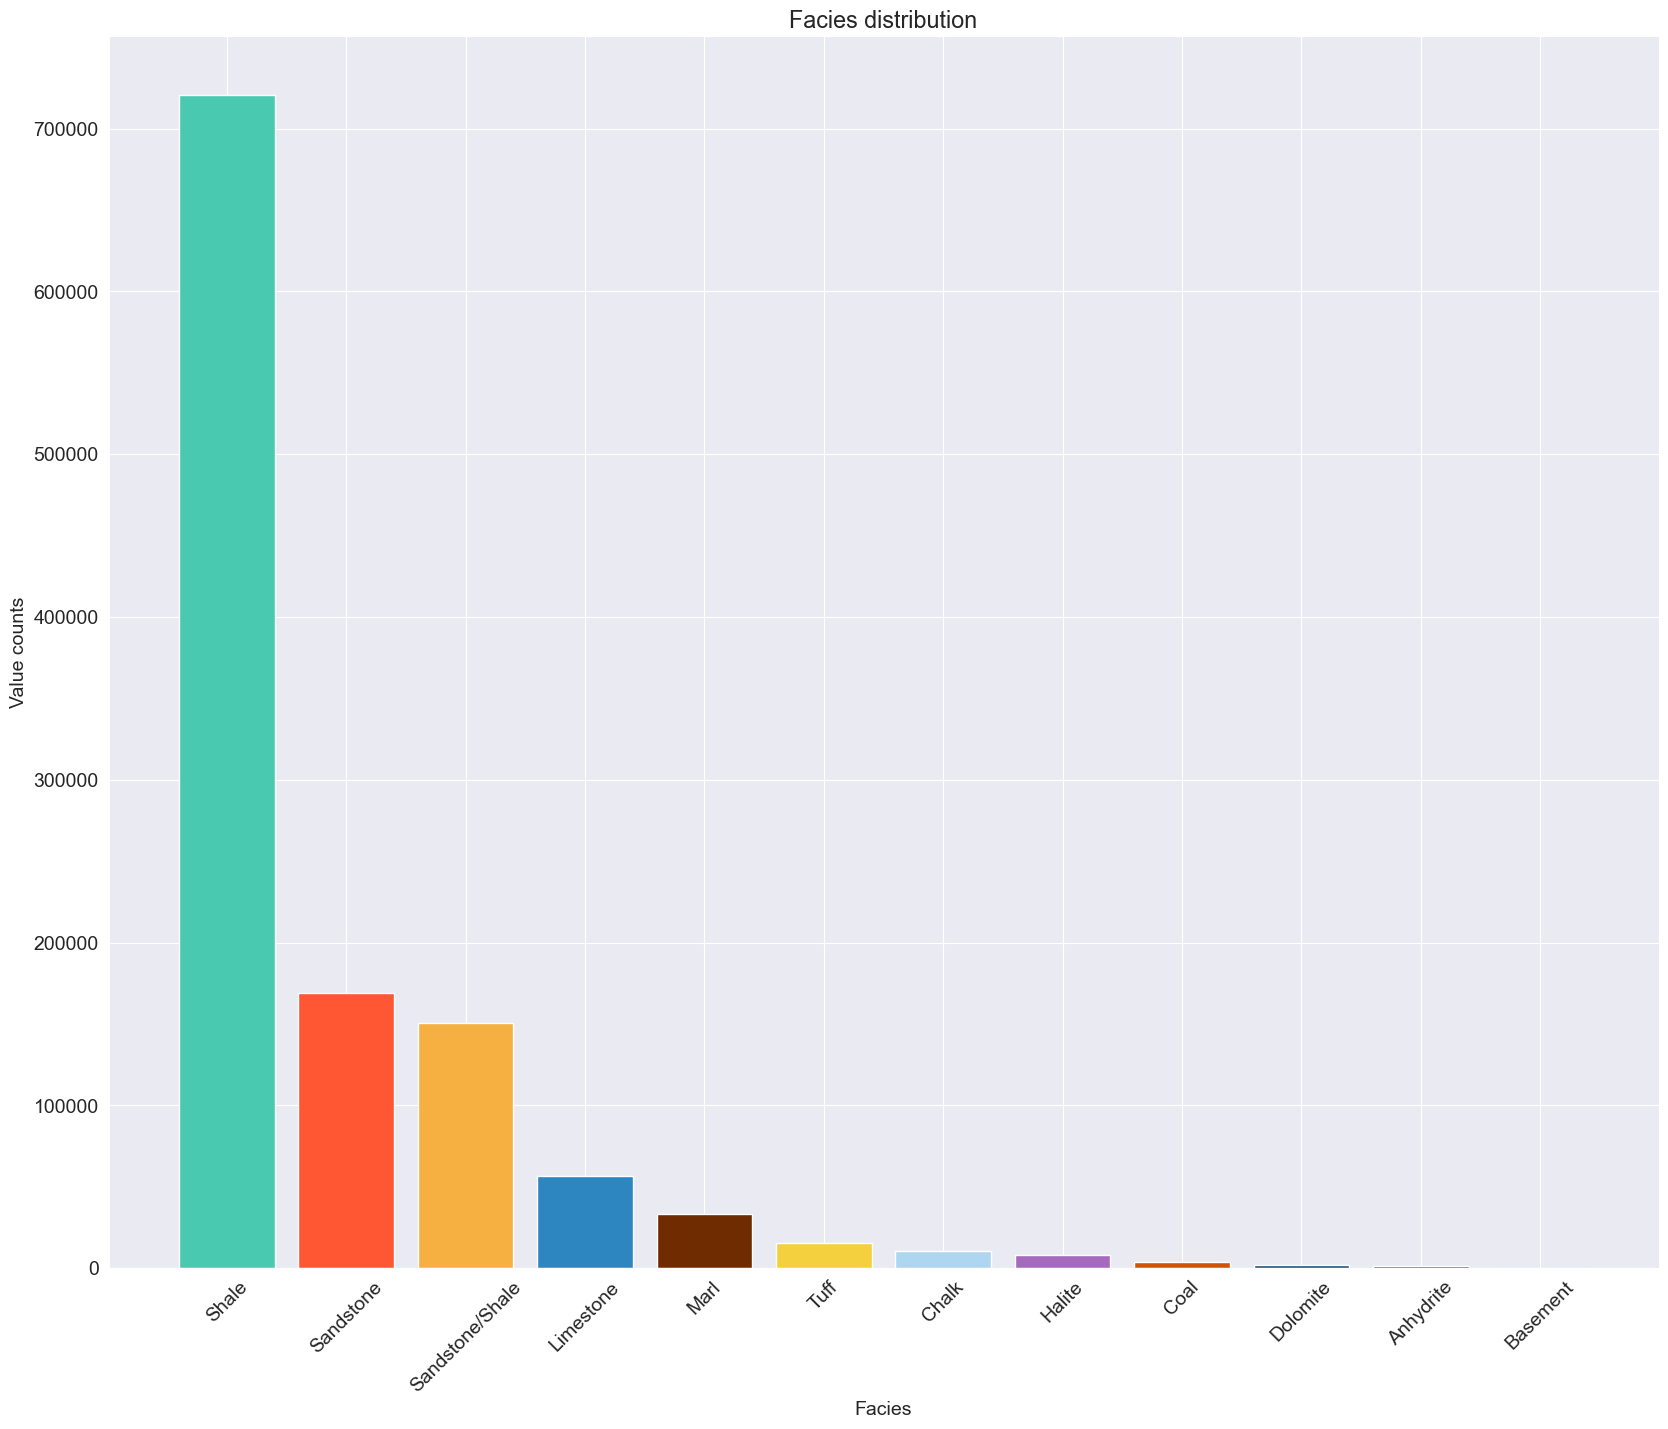

In [26]:
# Определение цветов для каждой фации
facies_colors = {'Sandstone': '#FF5733', 'Sandstone/Shale': '#F5B041', 'Shale': '#48C9B0',
                 'Marl': '#6E2C00', 'Dolomite': '#1B4F72', 'Limestone': '#2E86C1',
                 'Chalk': '#AED6F1', 'Halite': '#A569BD', 'Anhydrite': '#196F3D',
                 'Tuff': '#F4D03F', 'Coal': '#D35400', 'Basement': '#85929E'}

facies_counts = raw_df['FaciesLabels'].value_counts()

plt.bar(facies_counts.index, facies_counts.values, color=[facies_colors[f] for f in facies_counts.index])
plt.title('Facies distribution')
plt.xlabel('Facies')
plt.ylabel('Value counts')

plt.xticks(rotation=45) 

plt.show()

Выбор признаков для решения задачи классификации

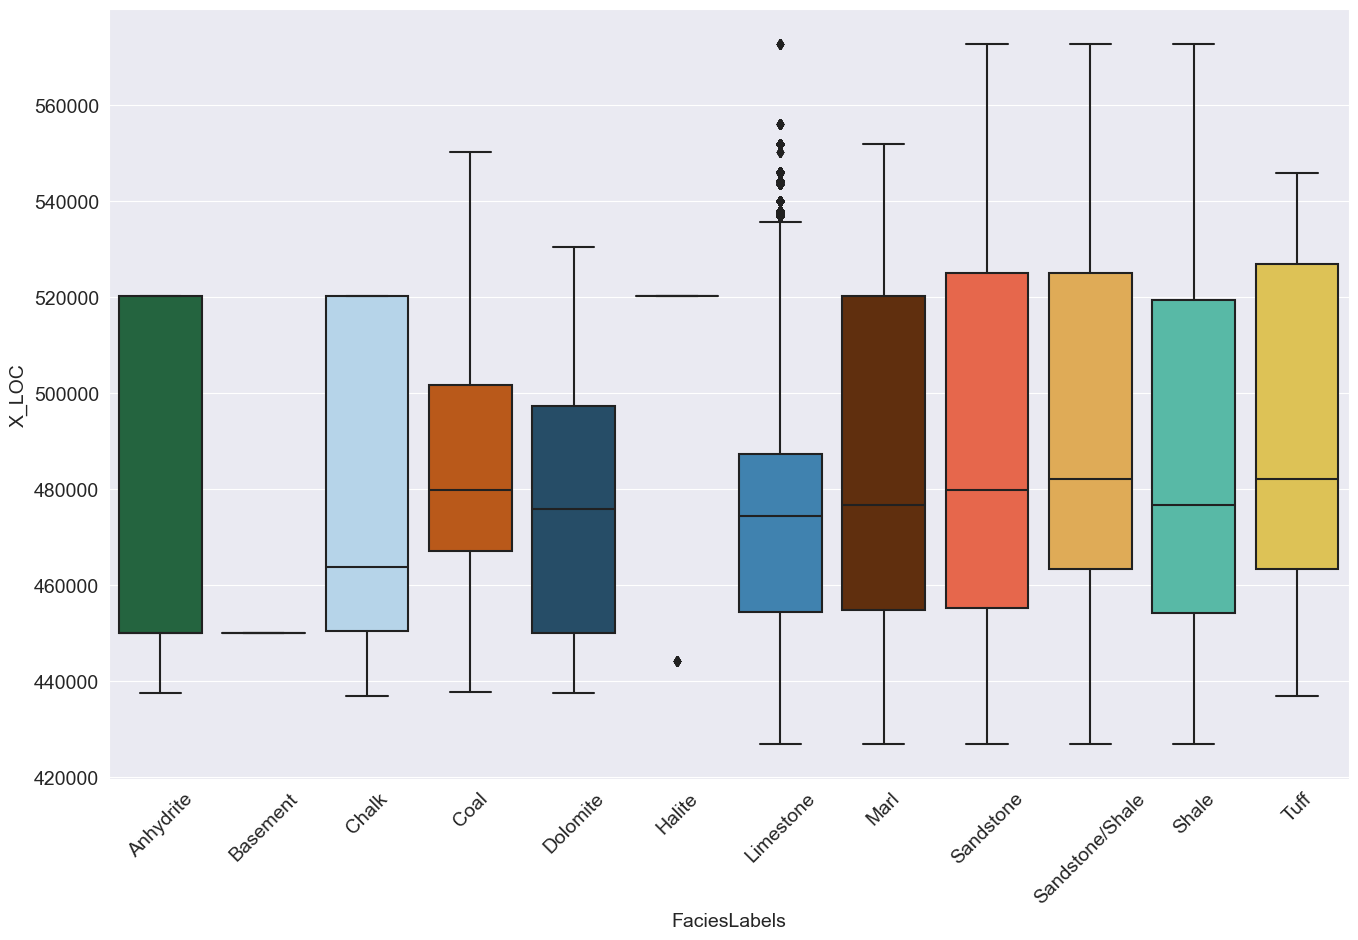

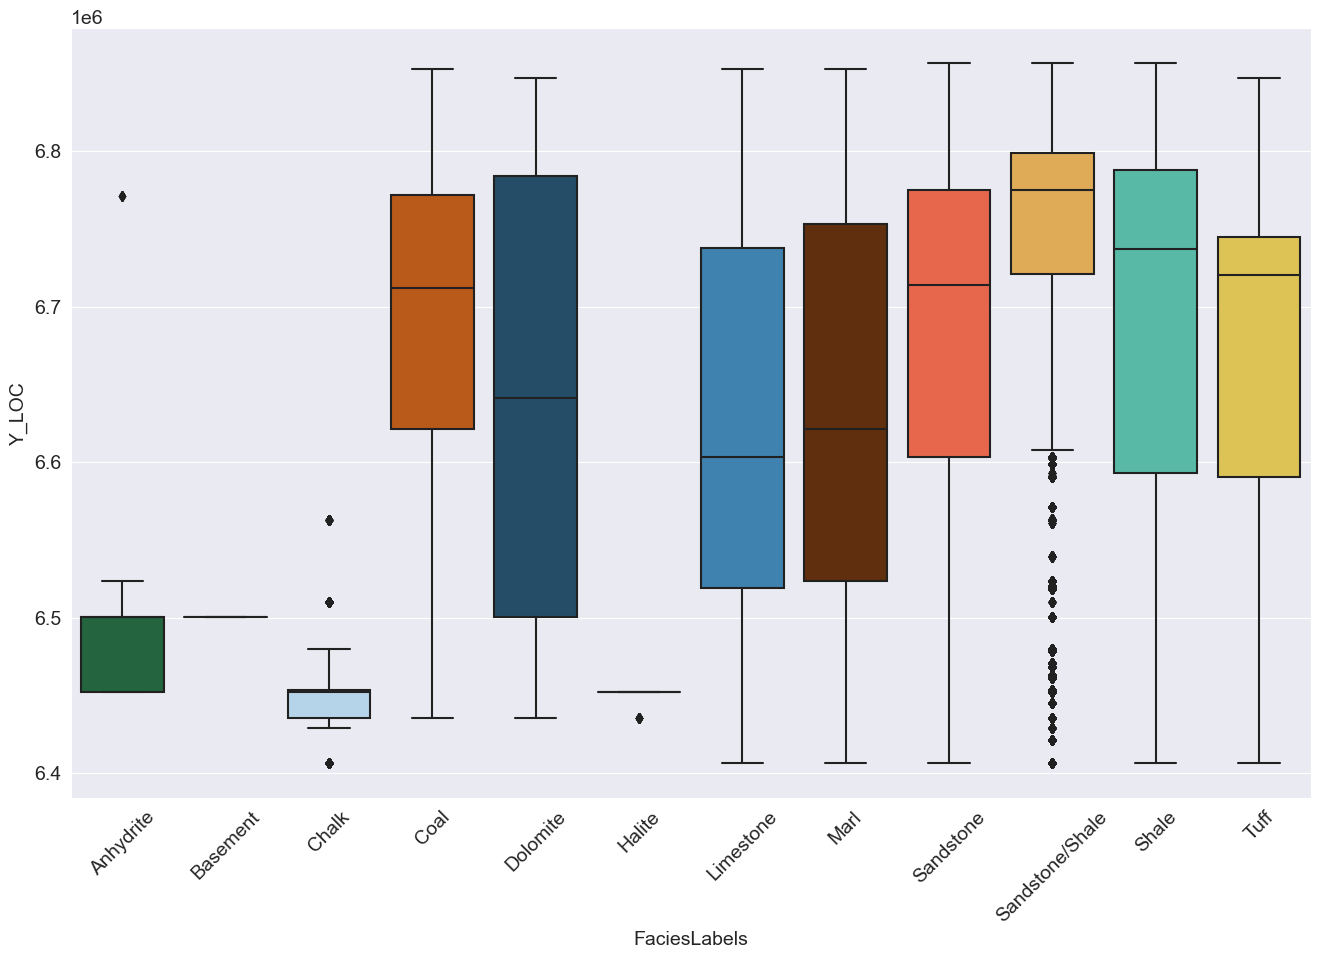

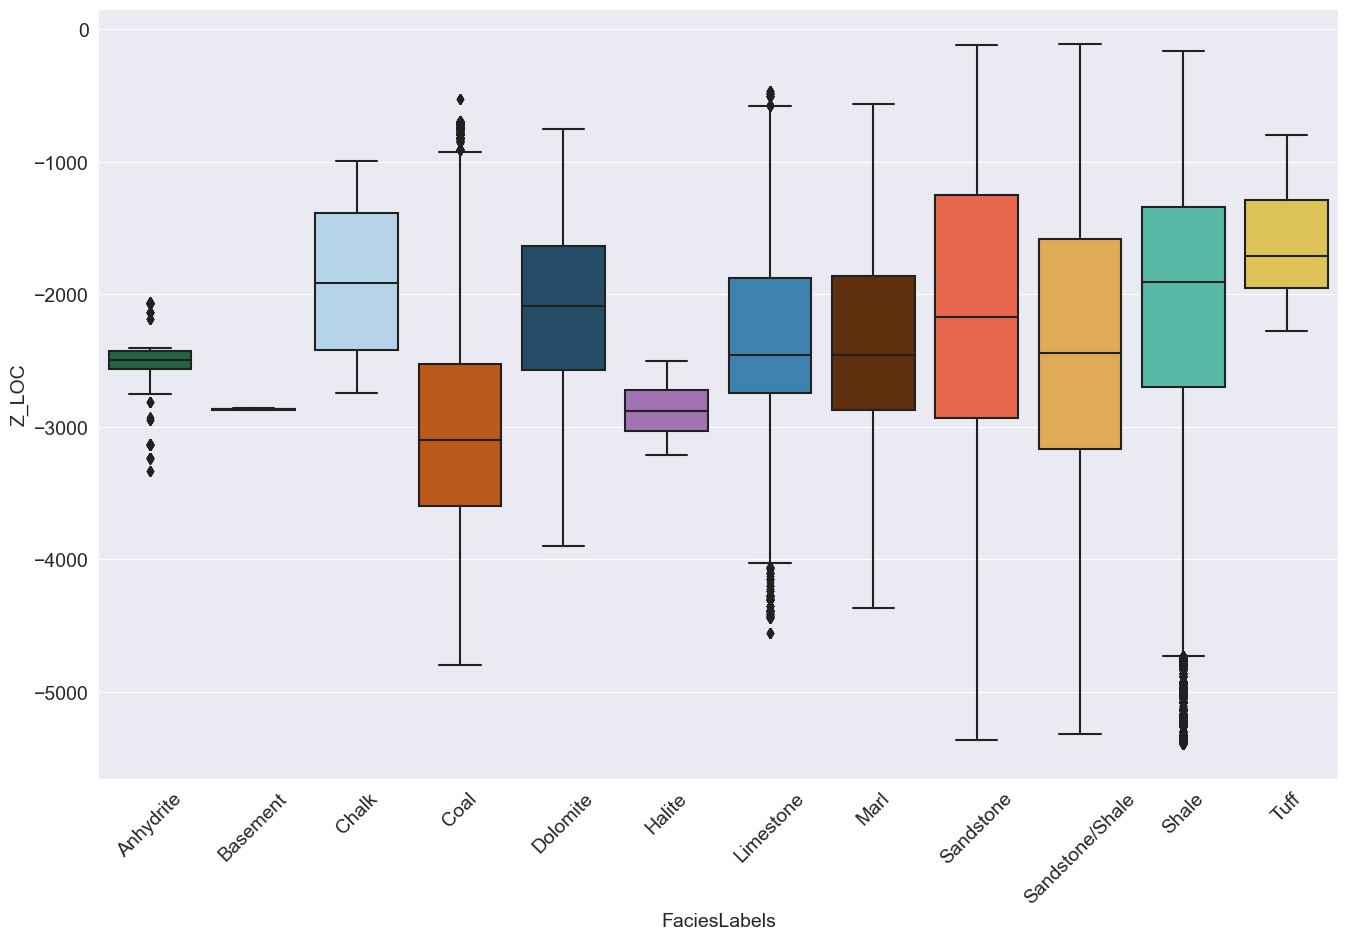

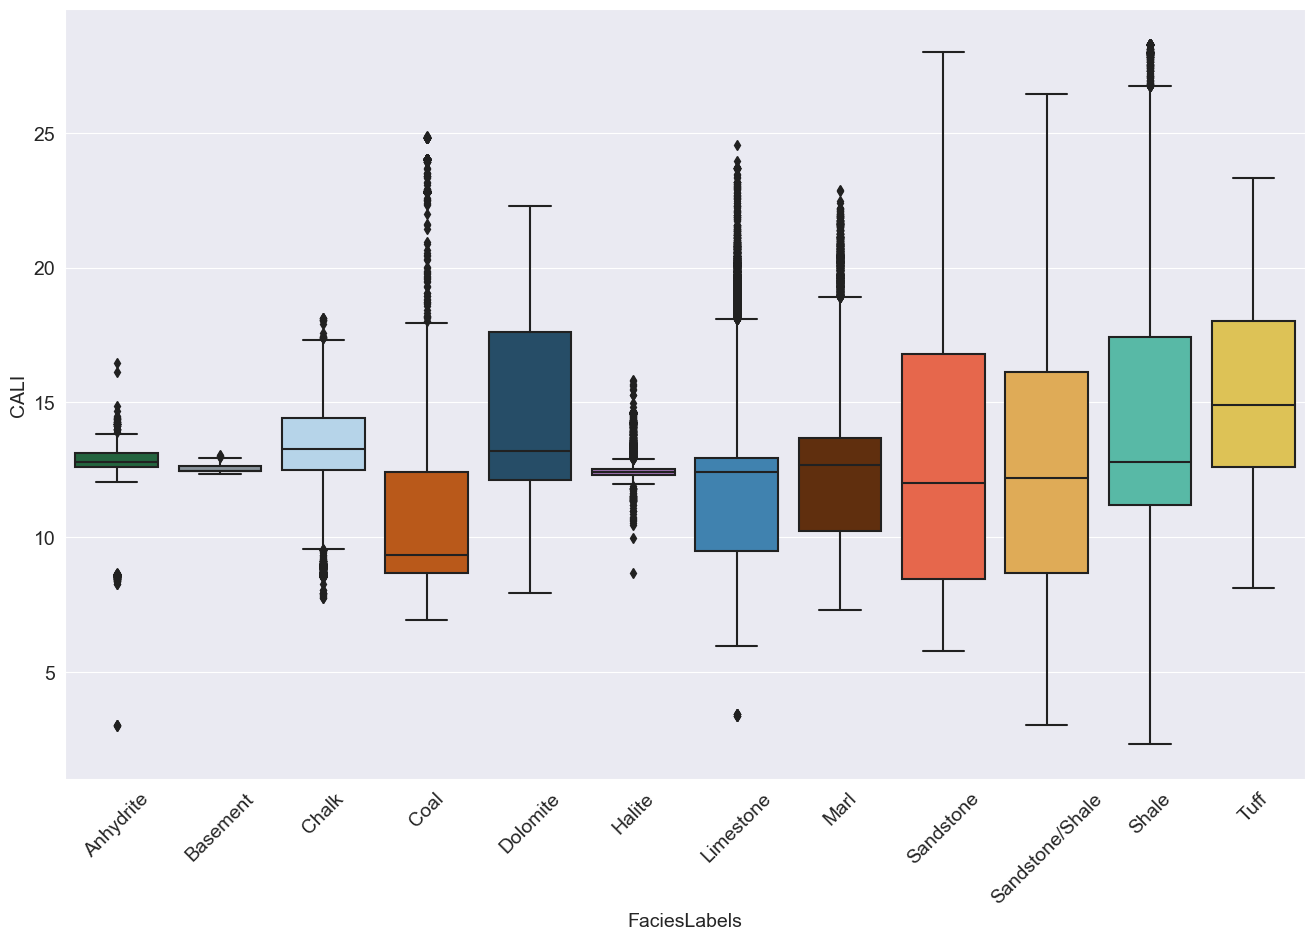

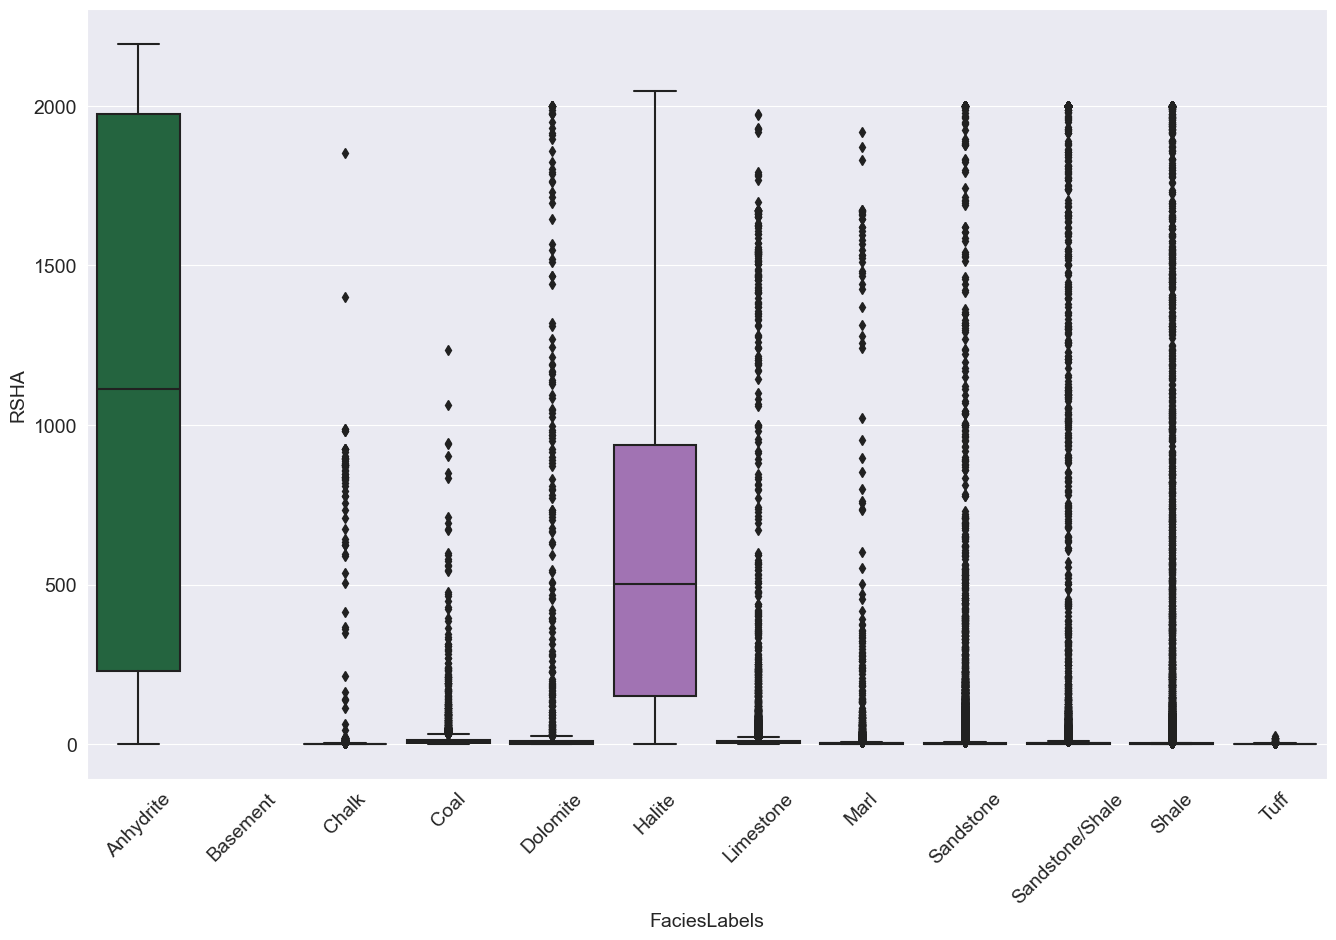

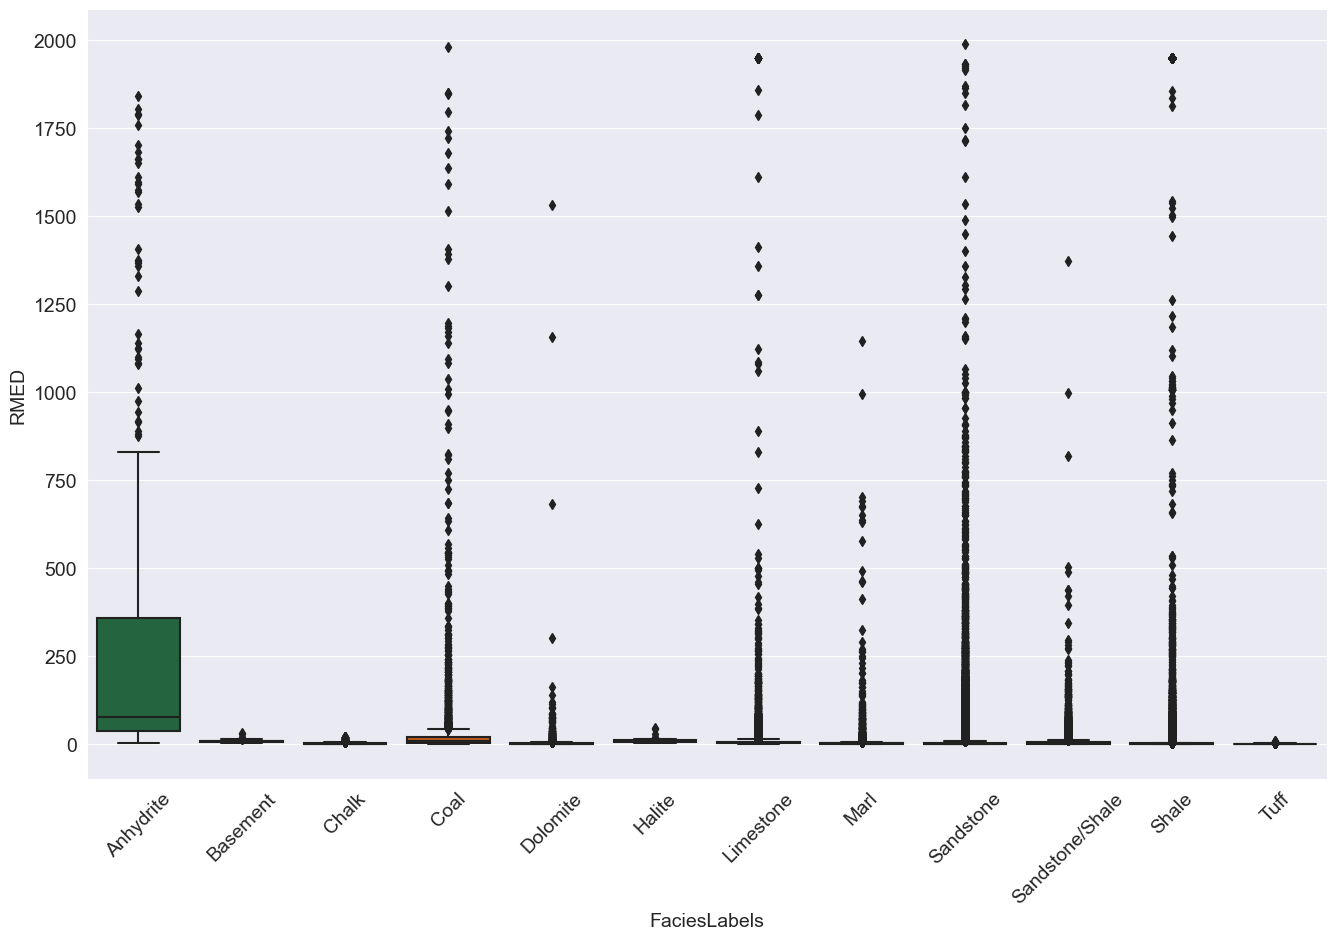

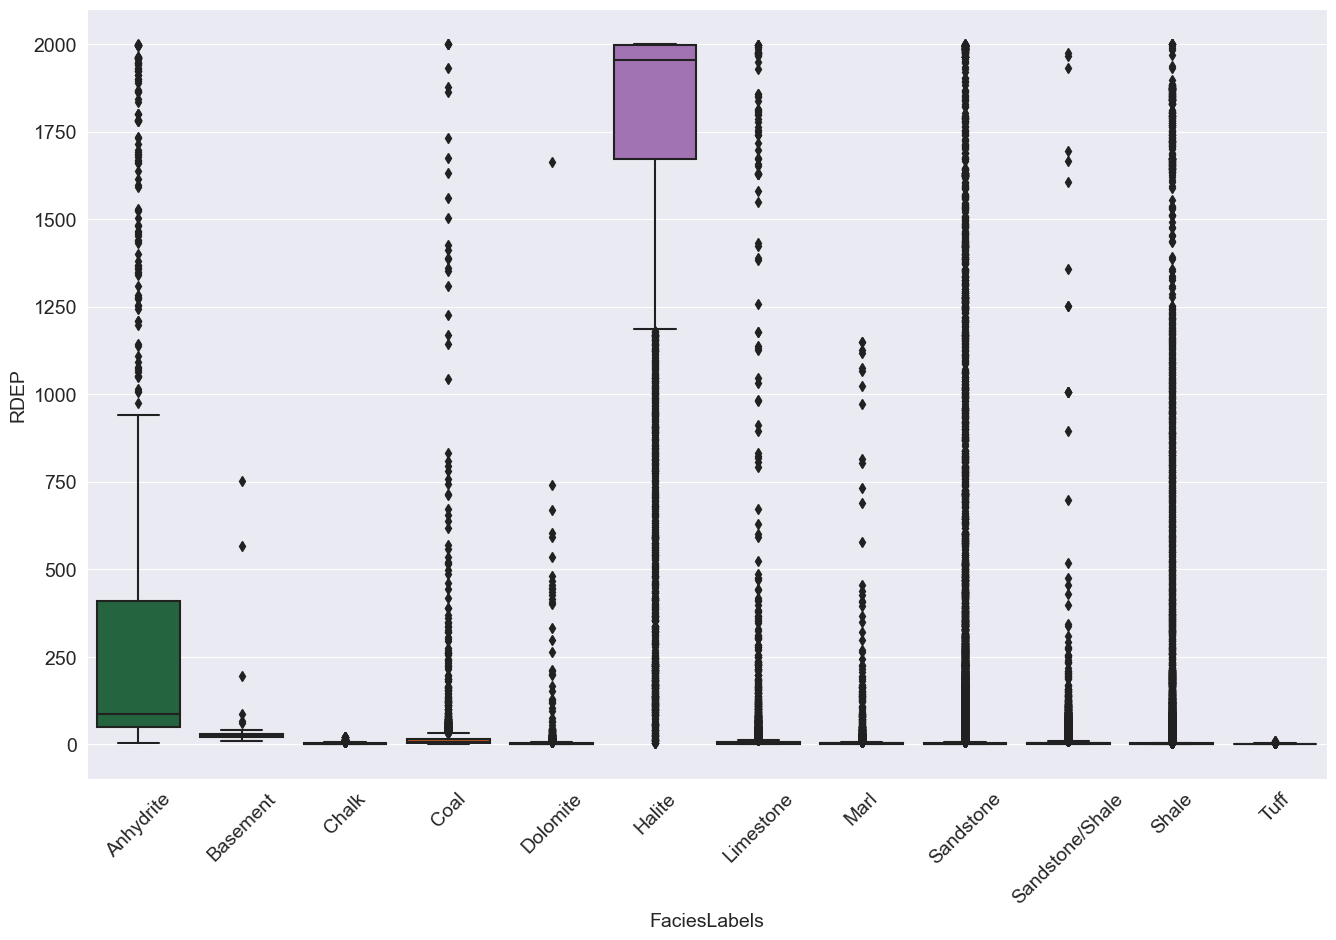

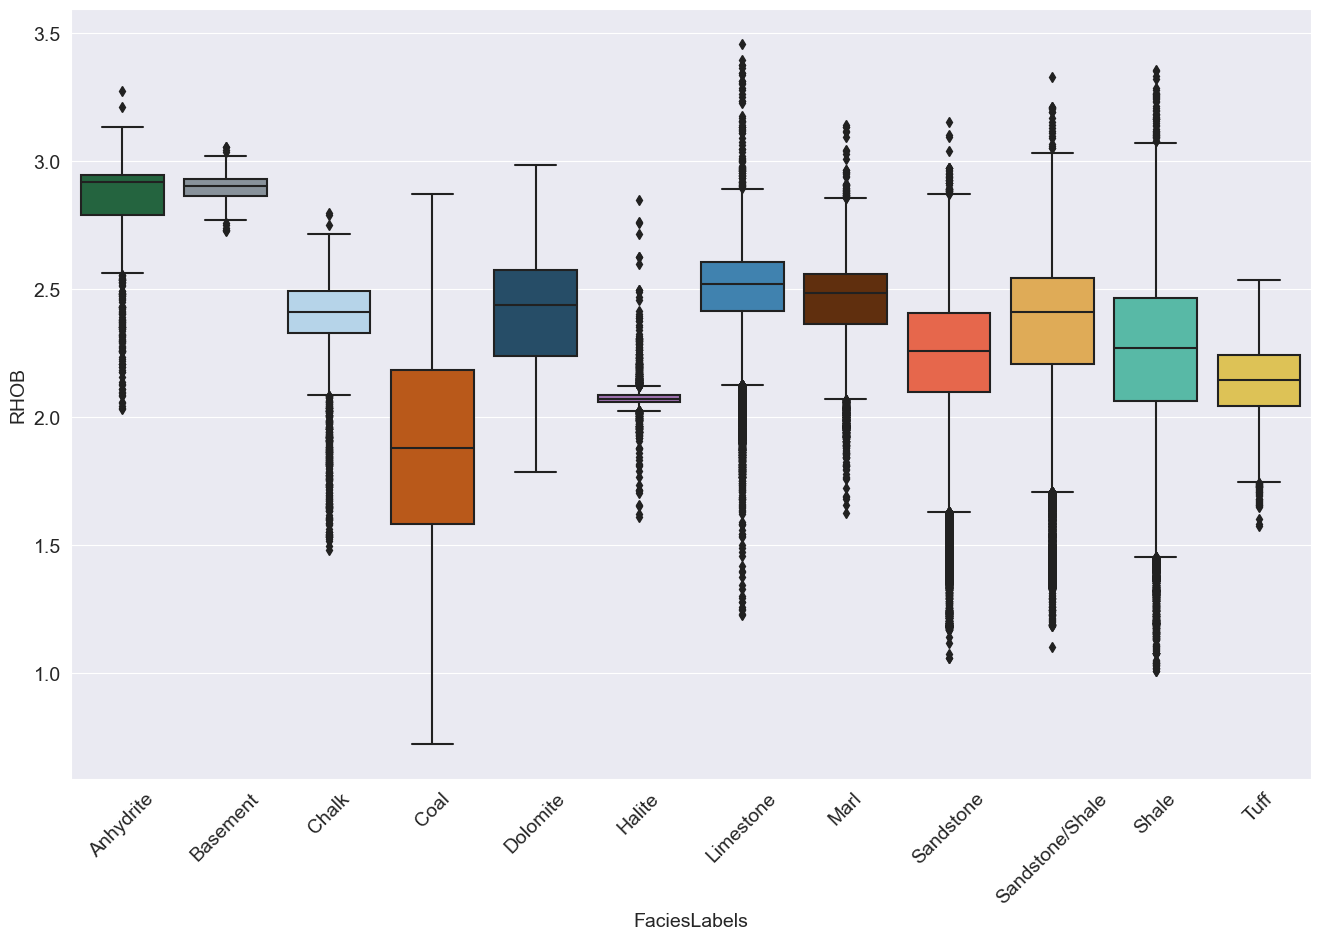

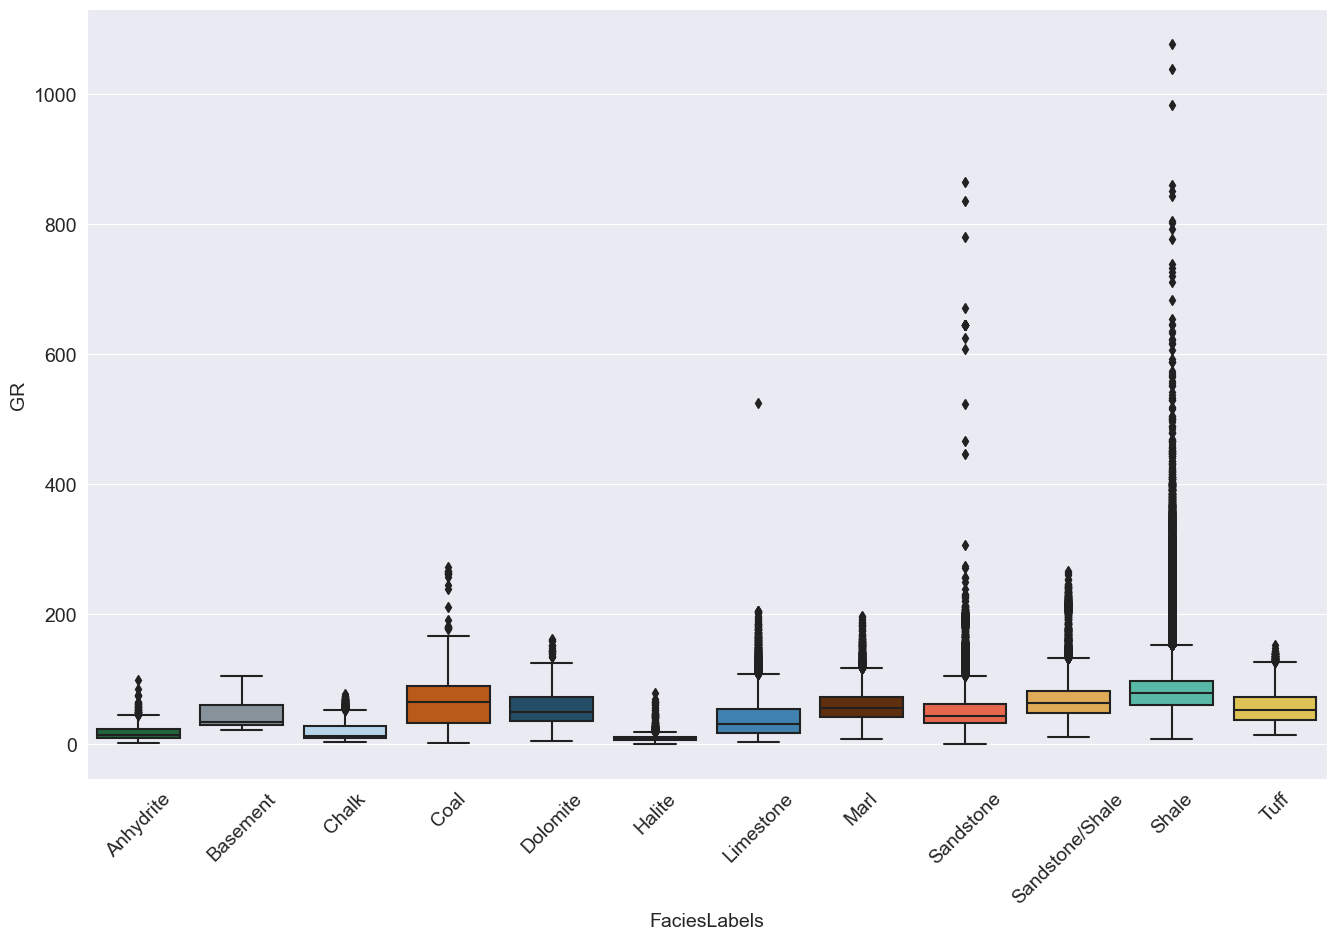

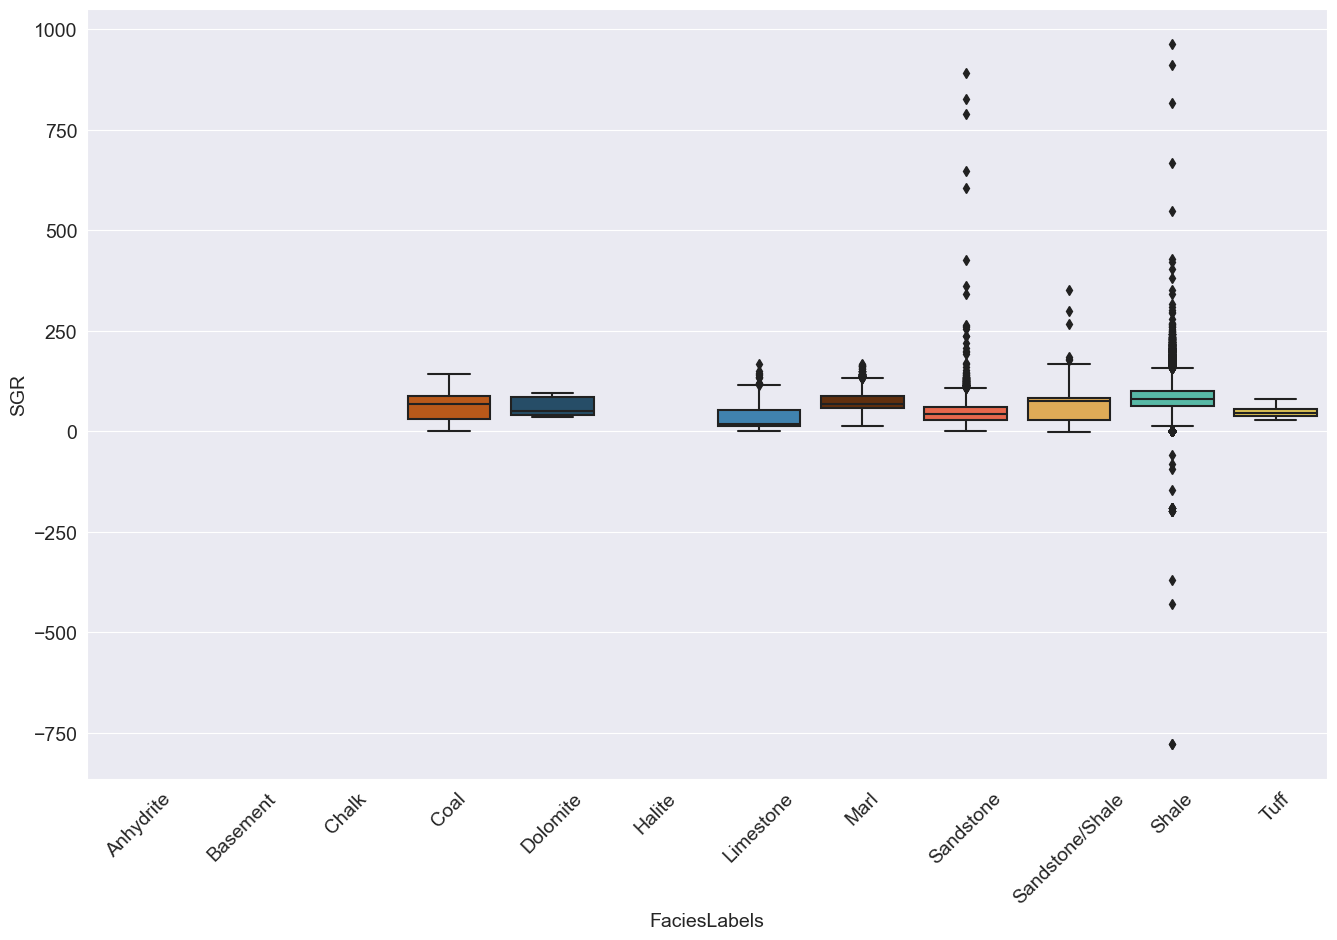

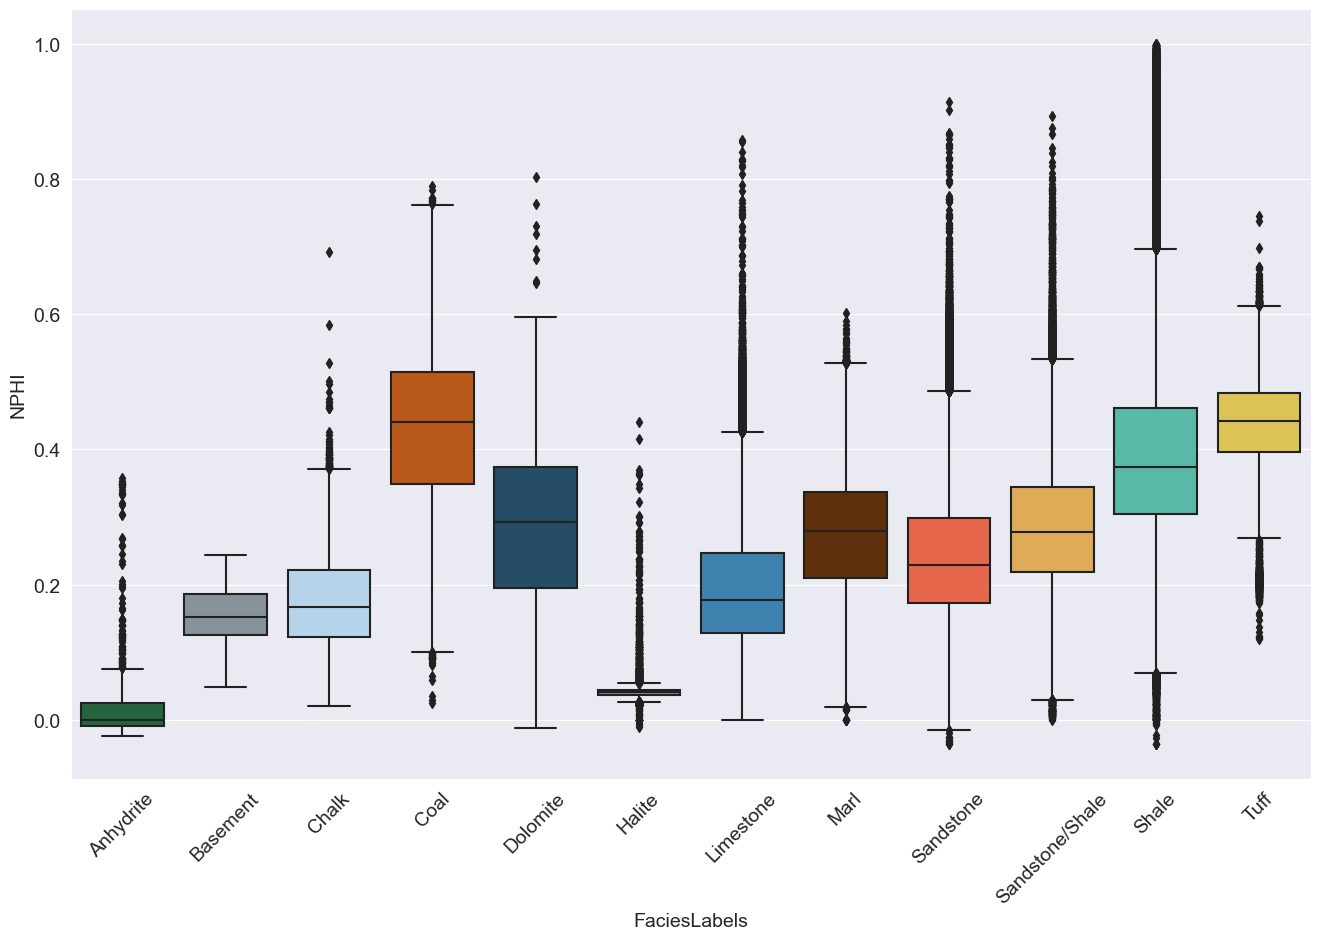

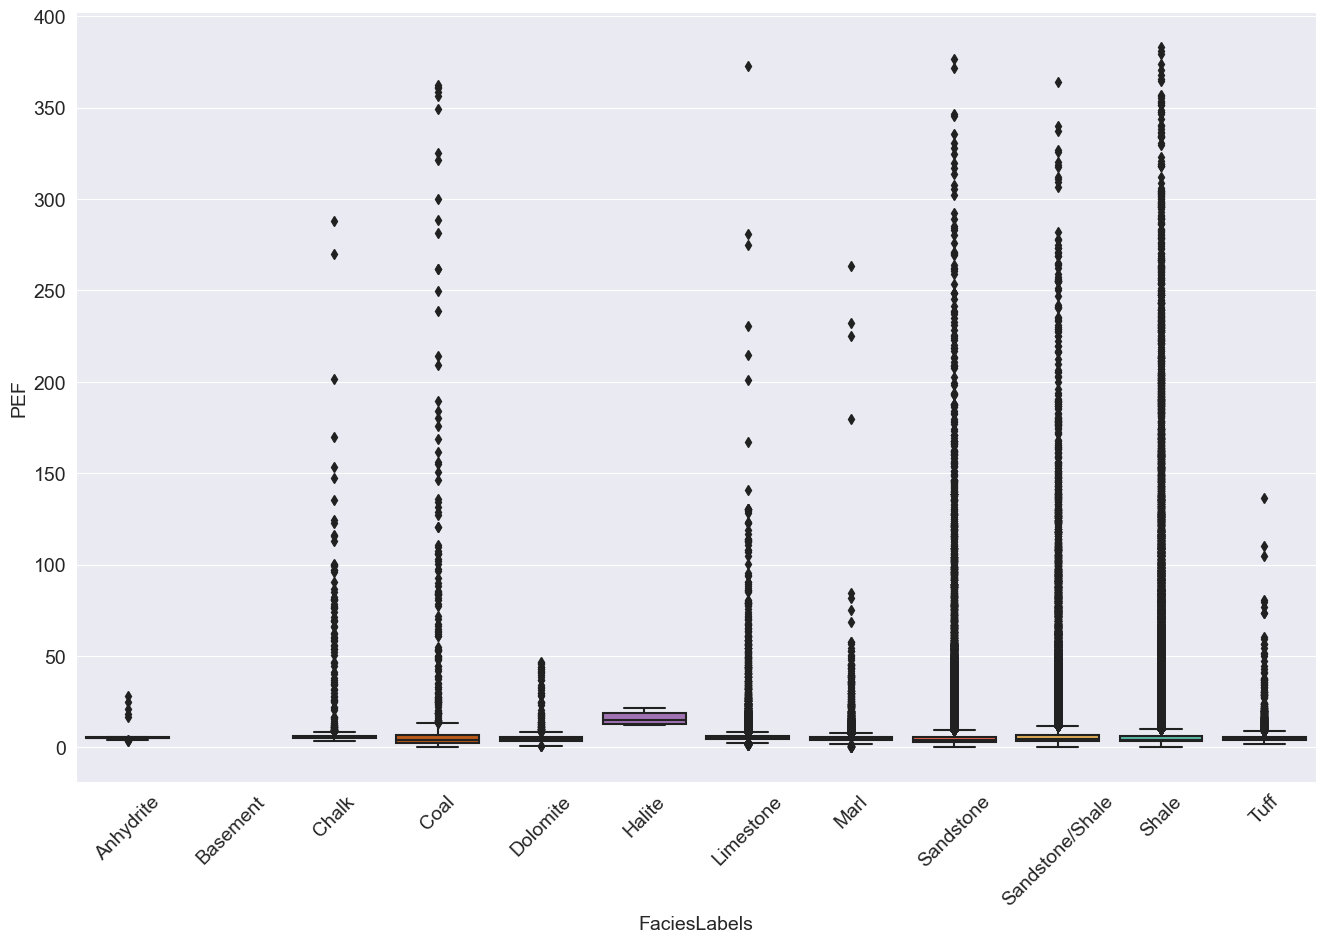

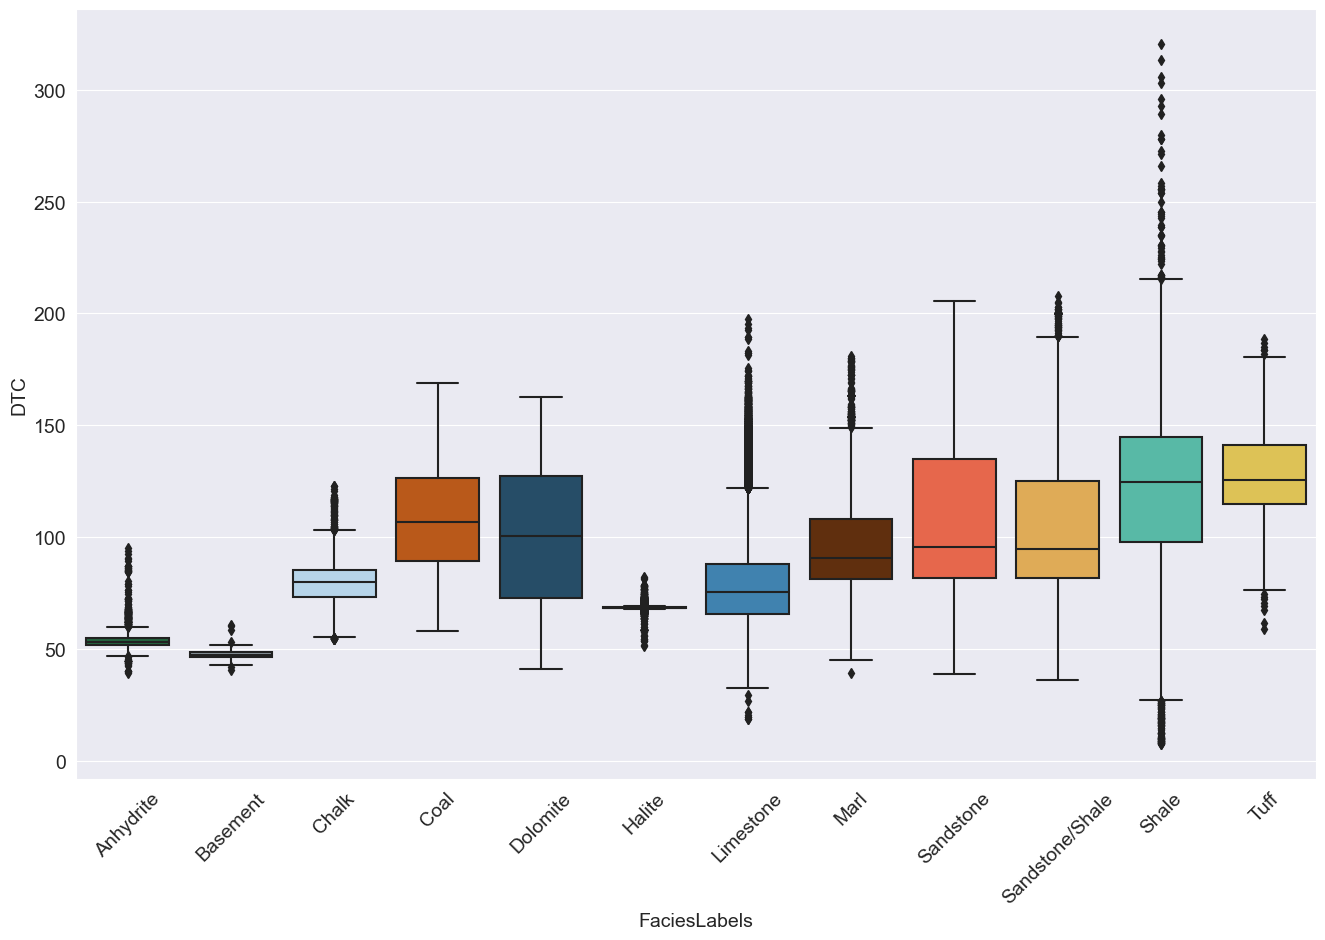

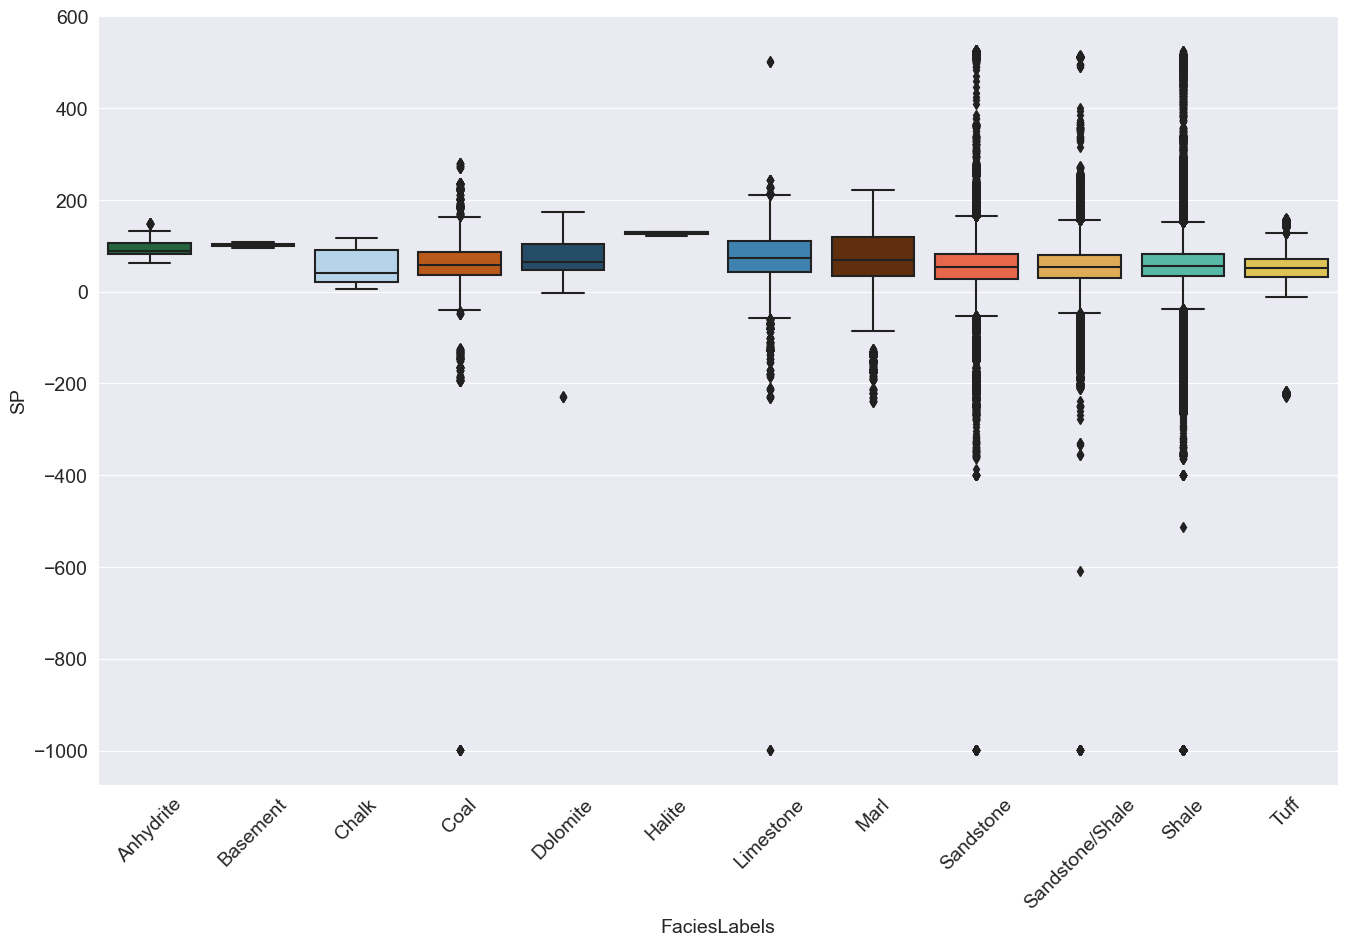

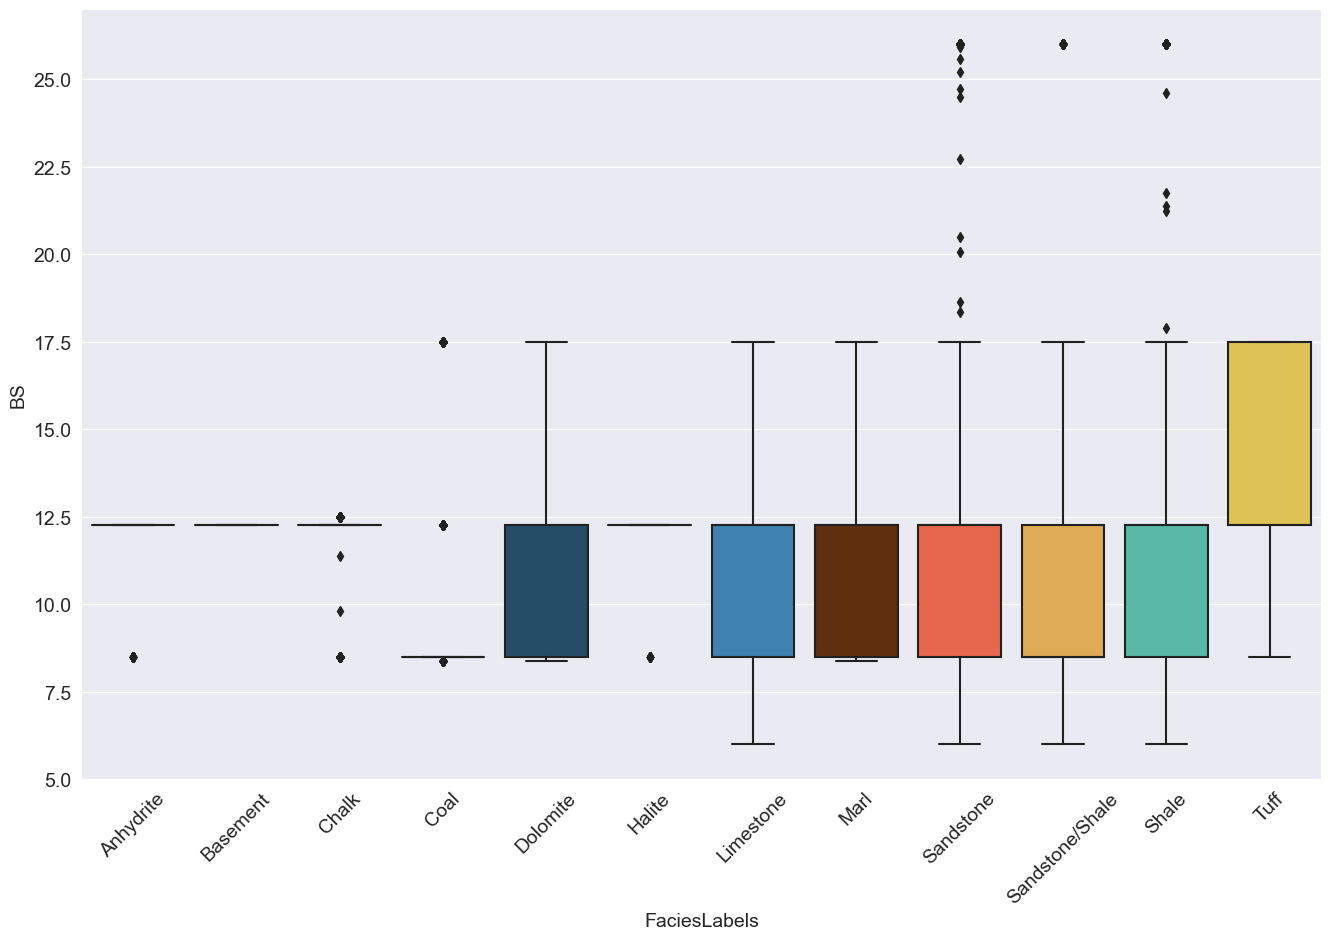

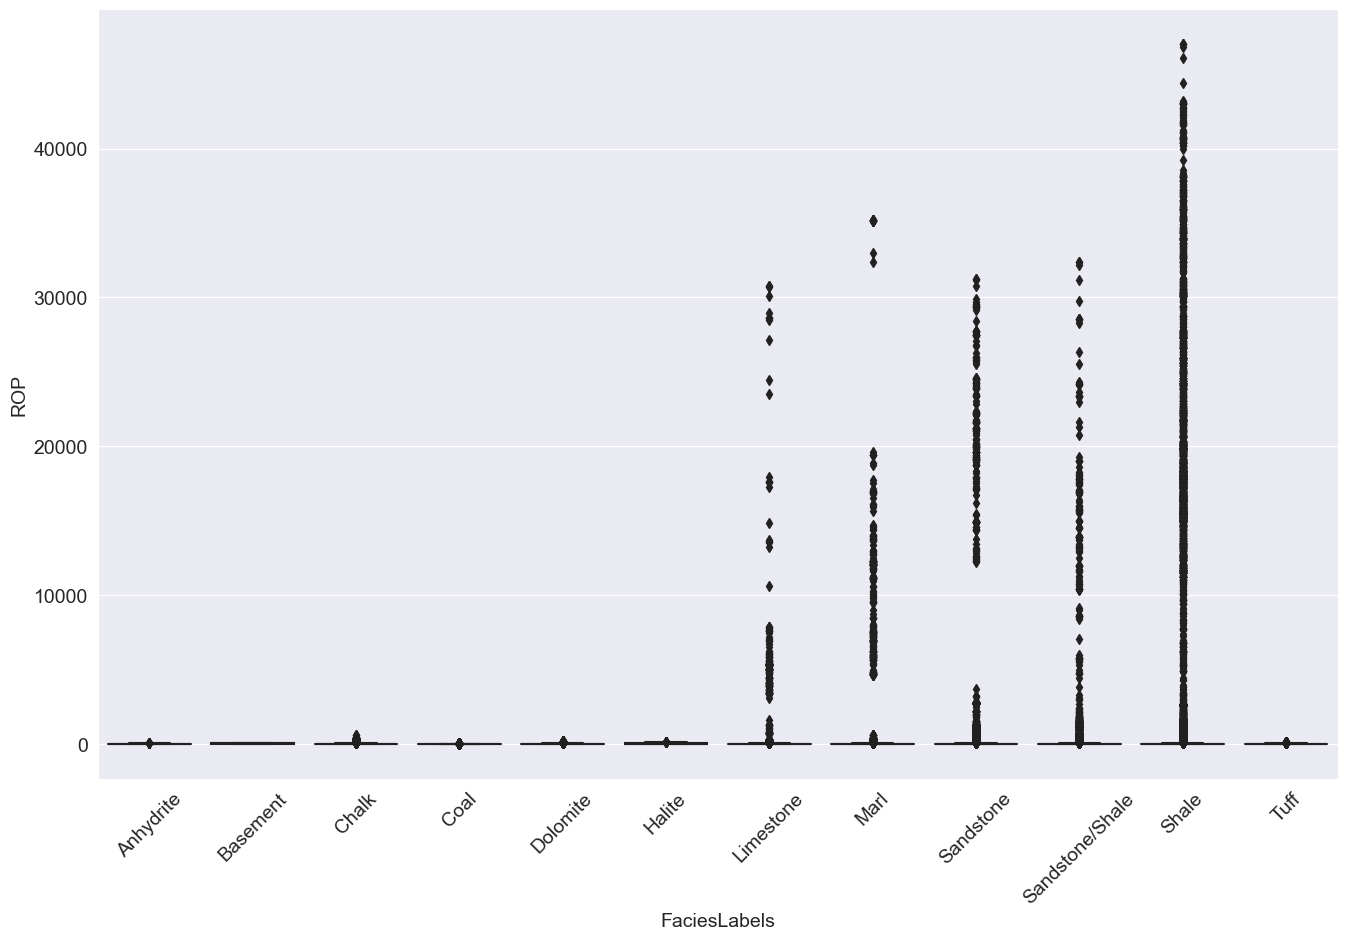

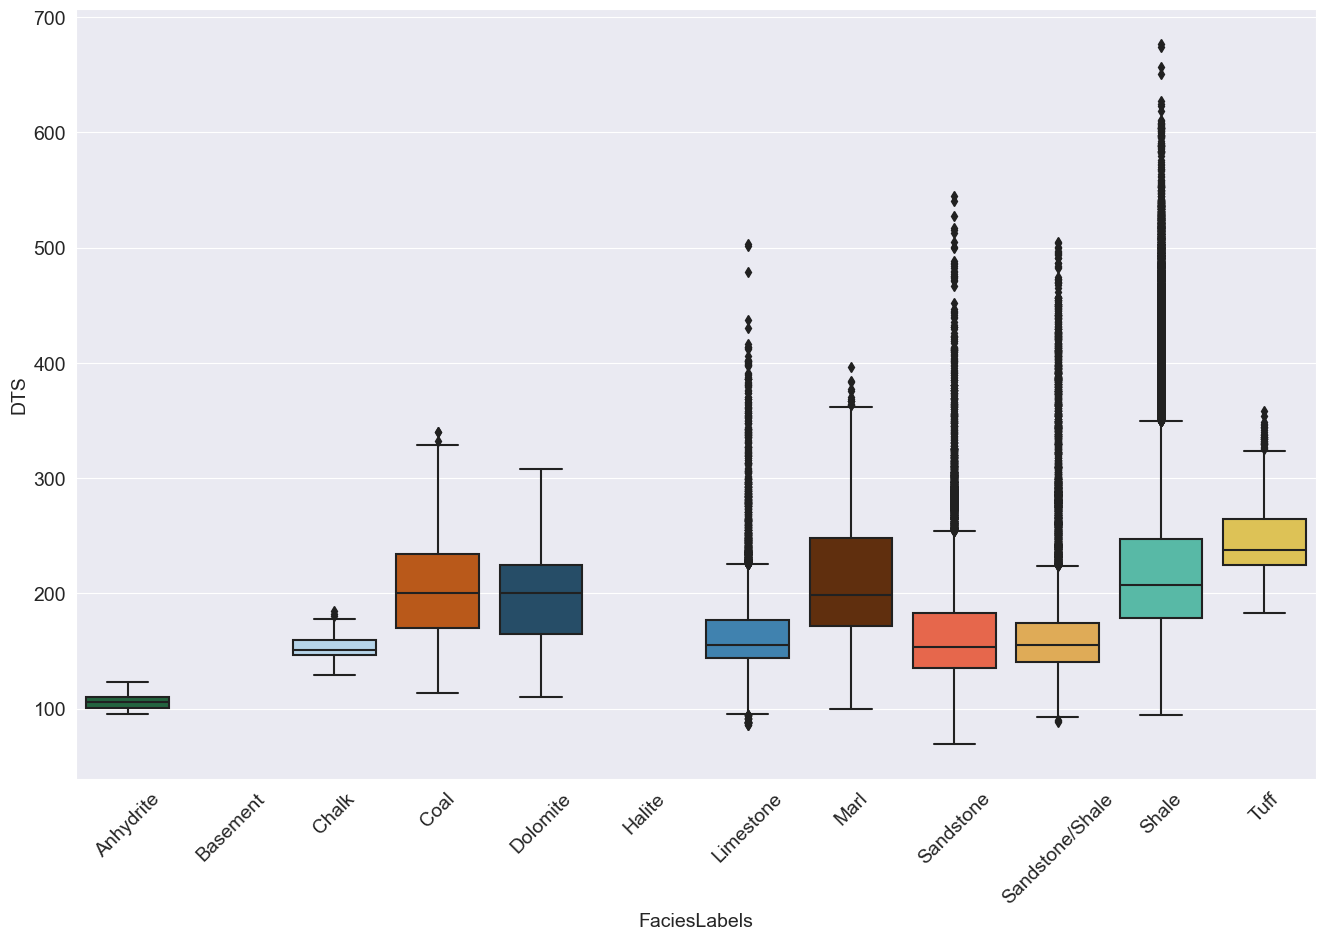

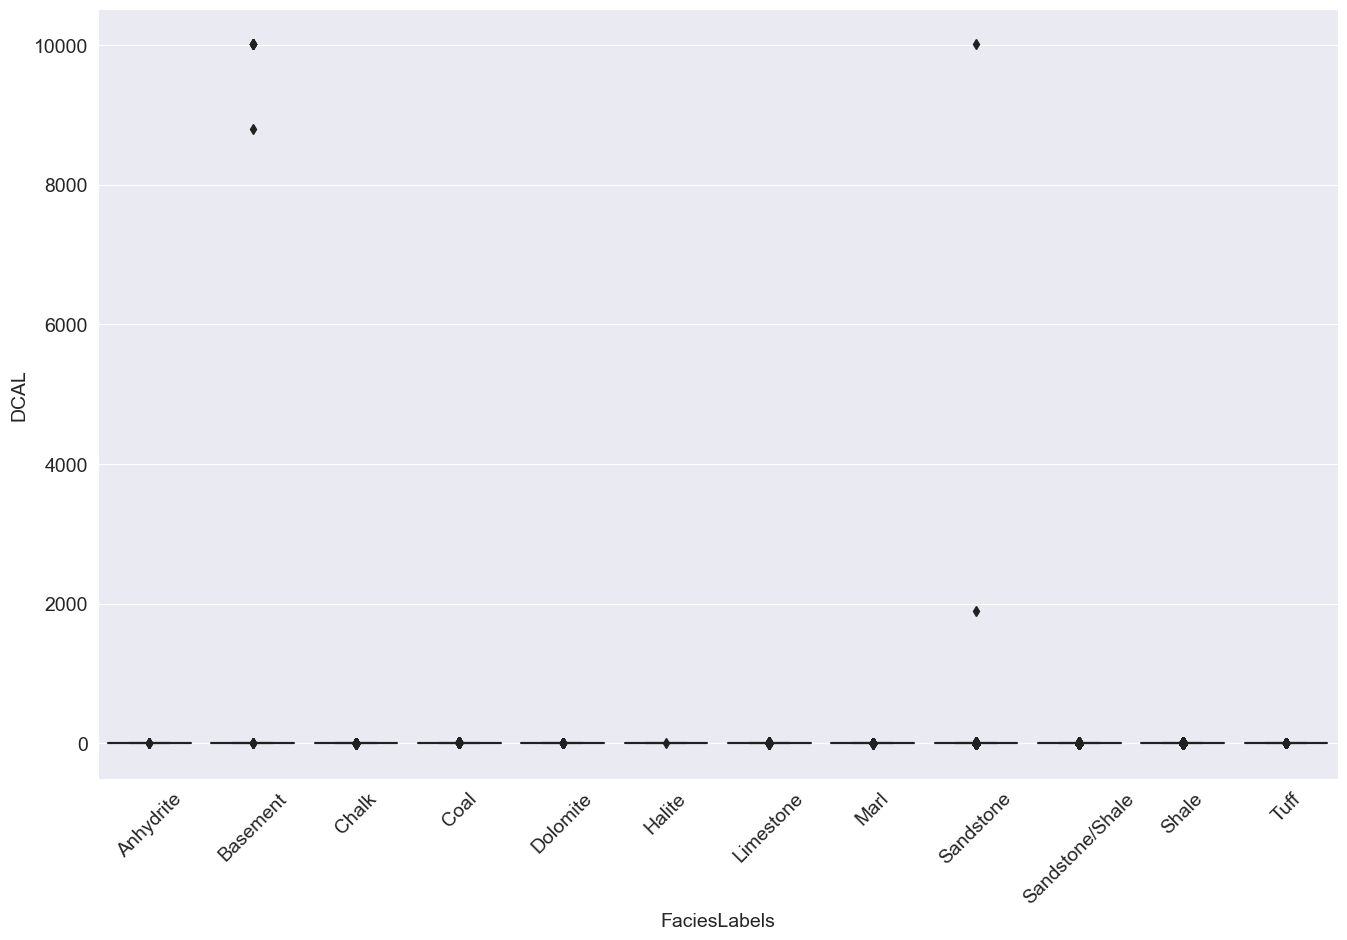

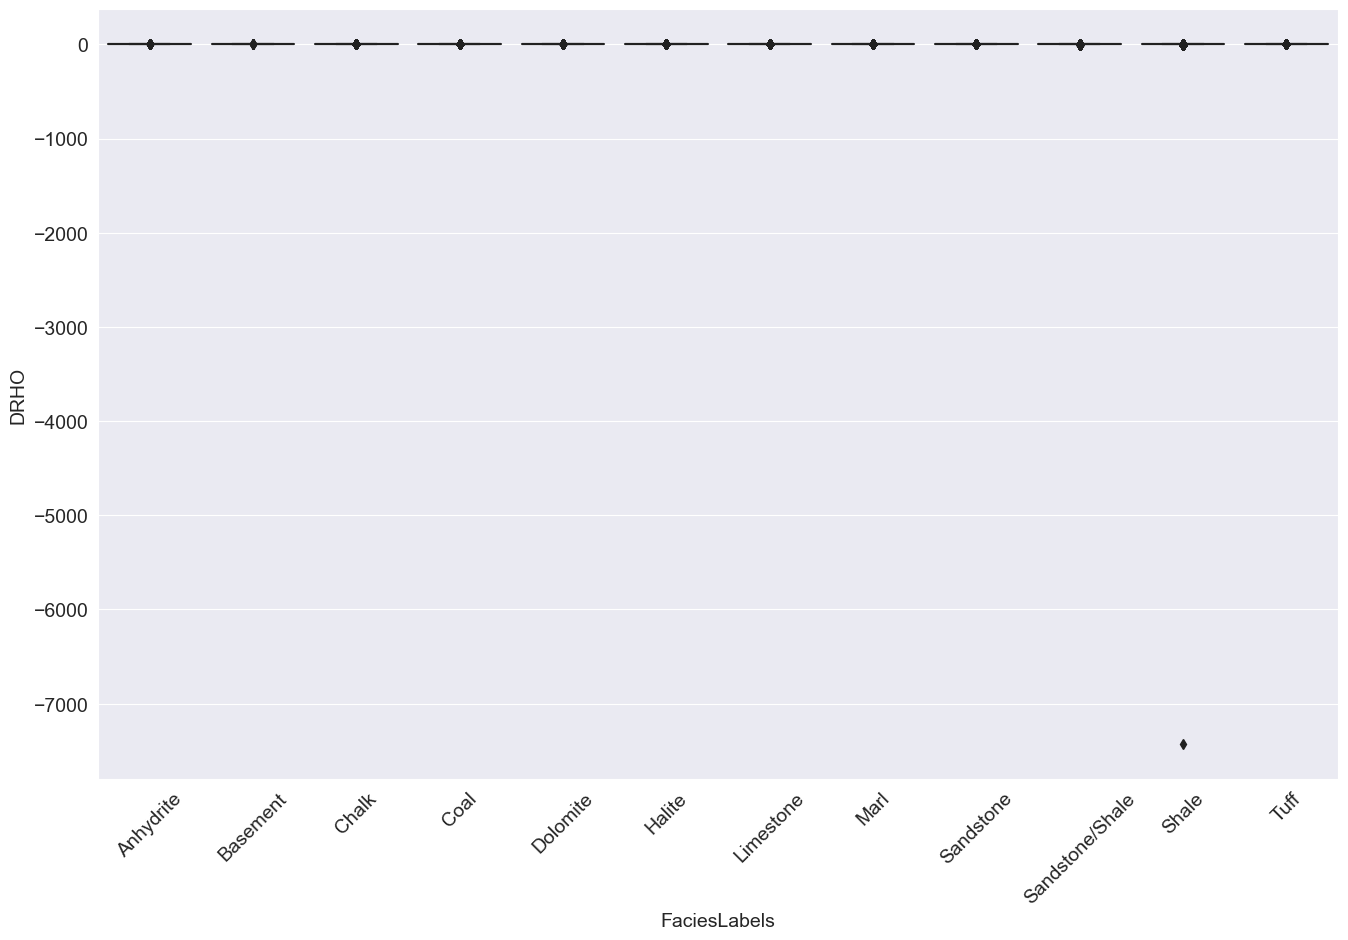

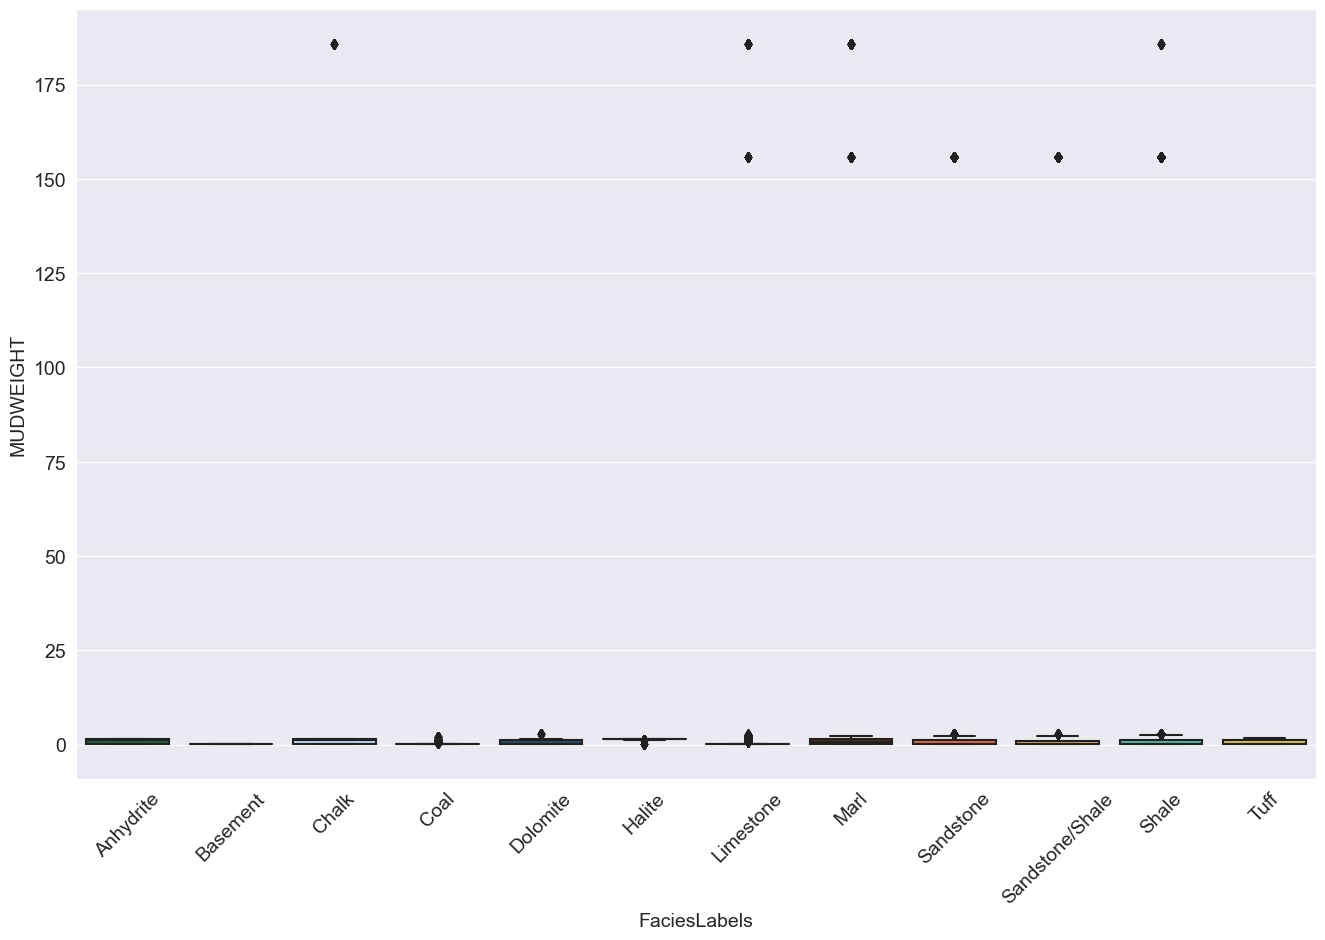

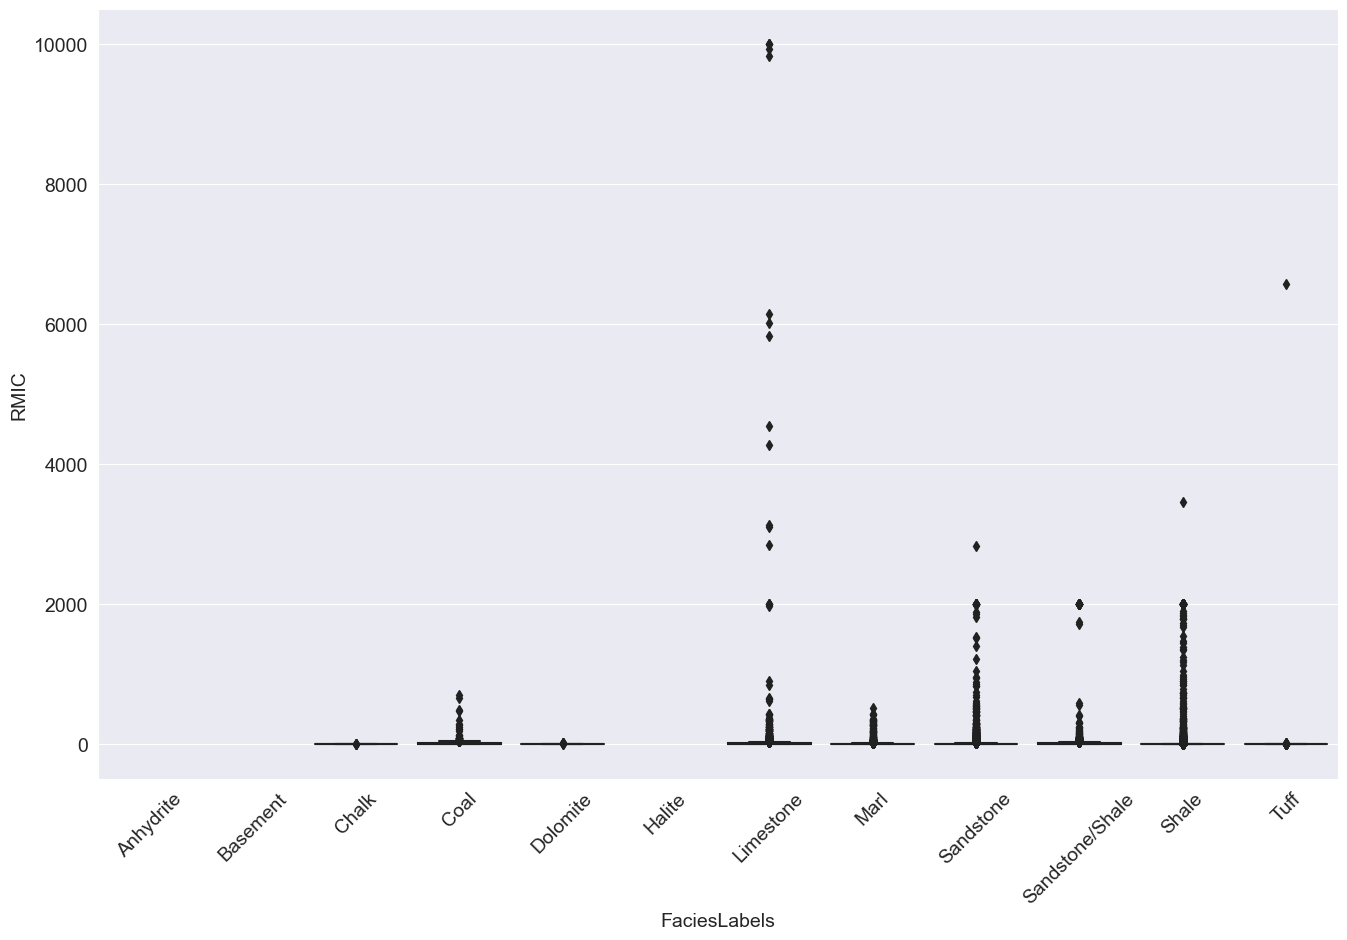

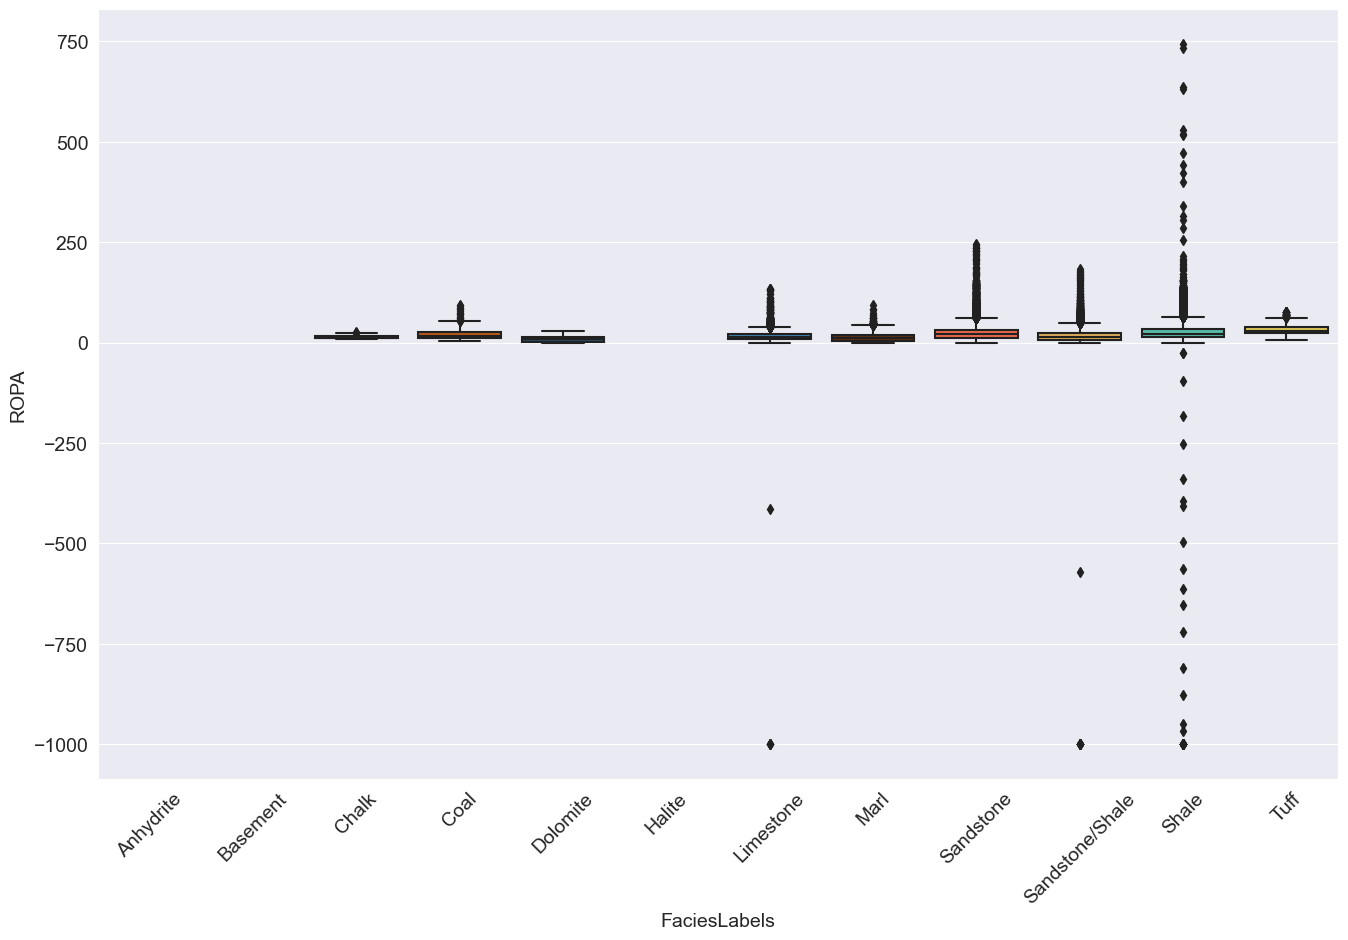

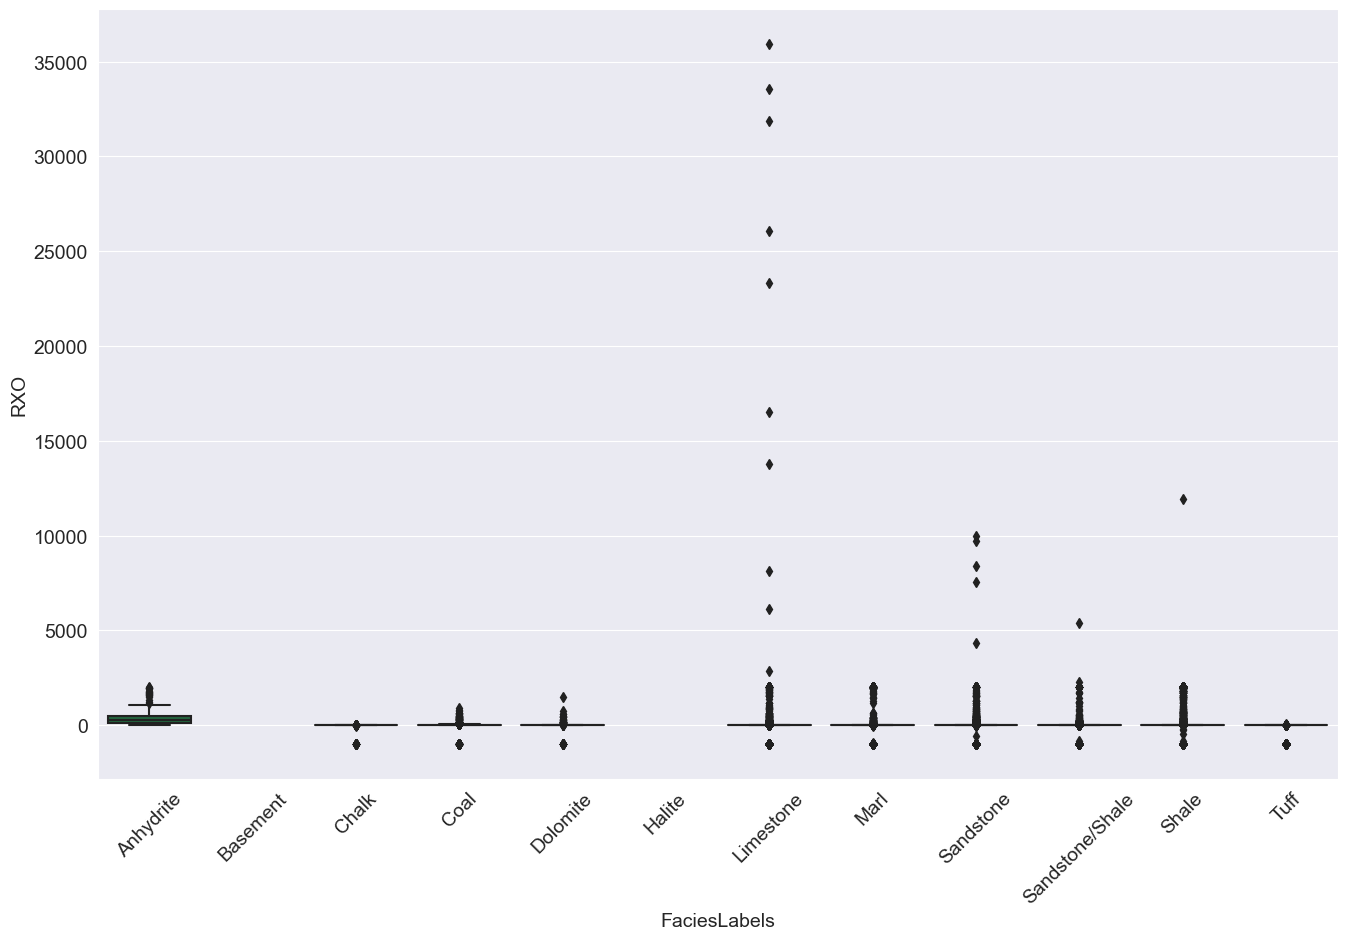

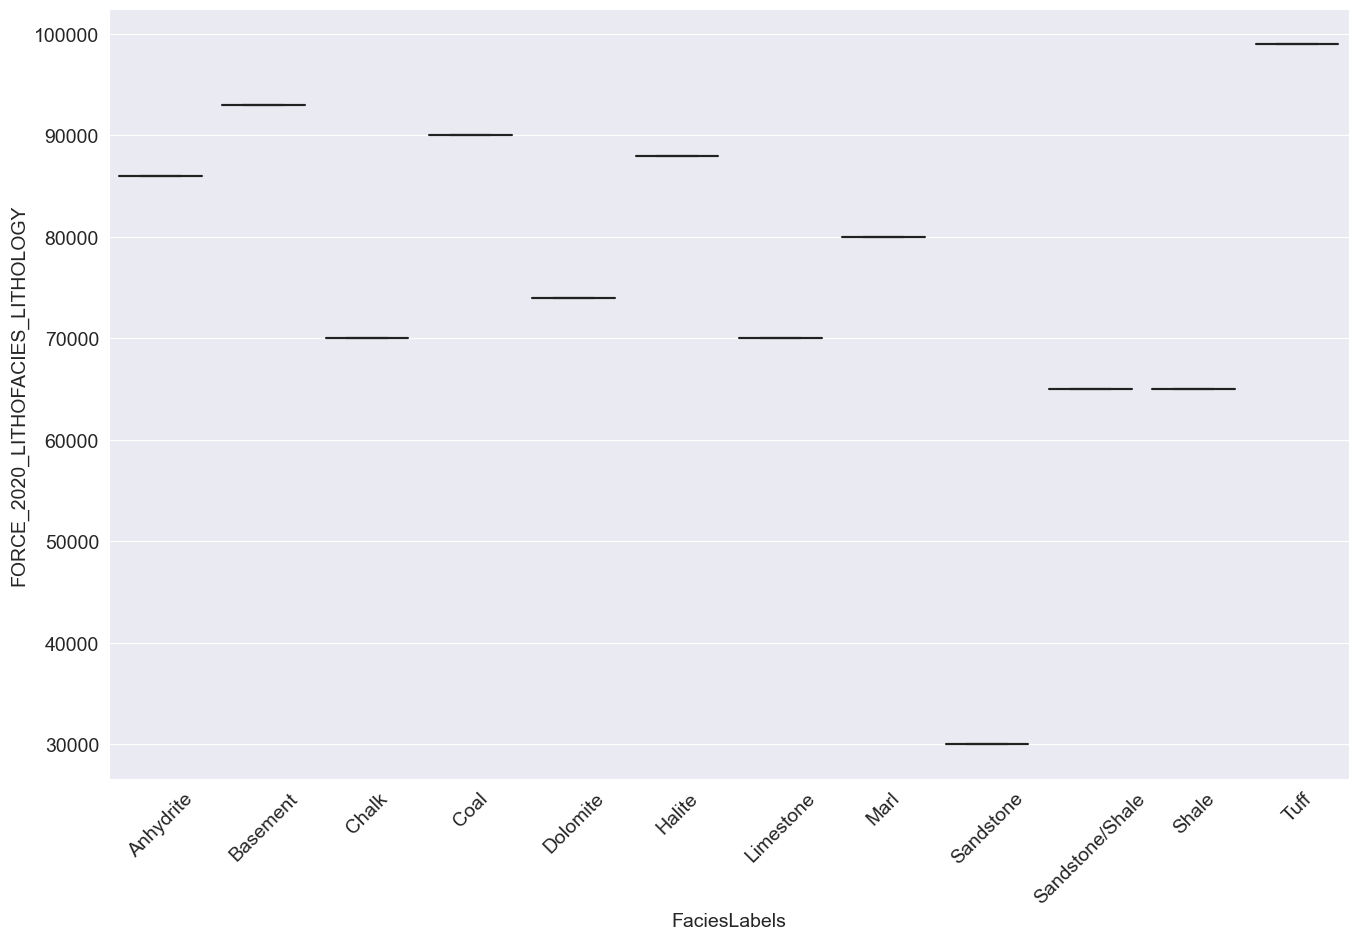

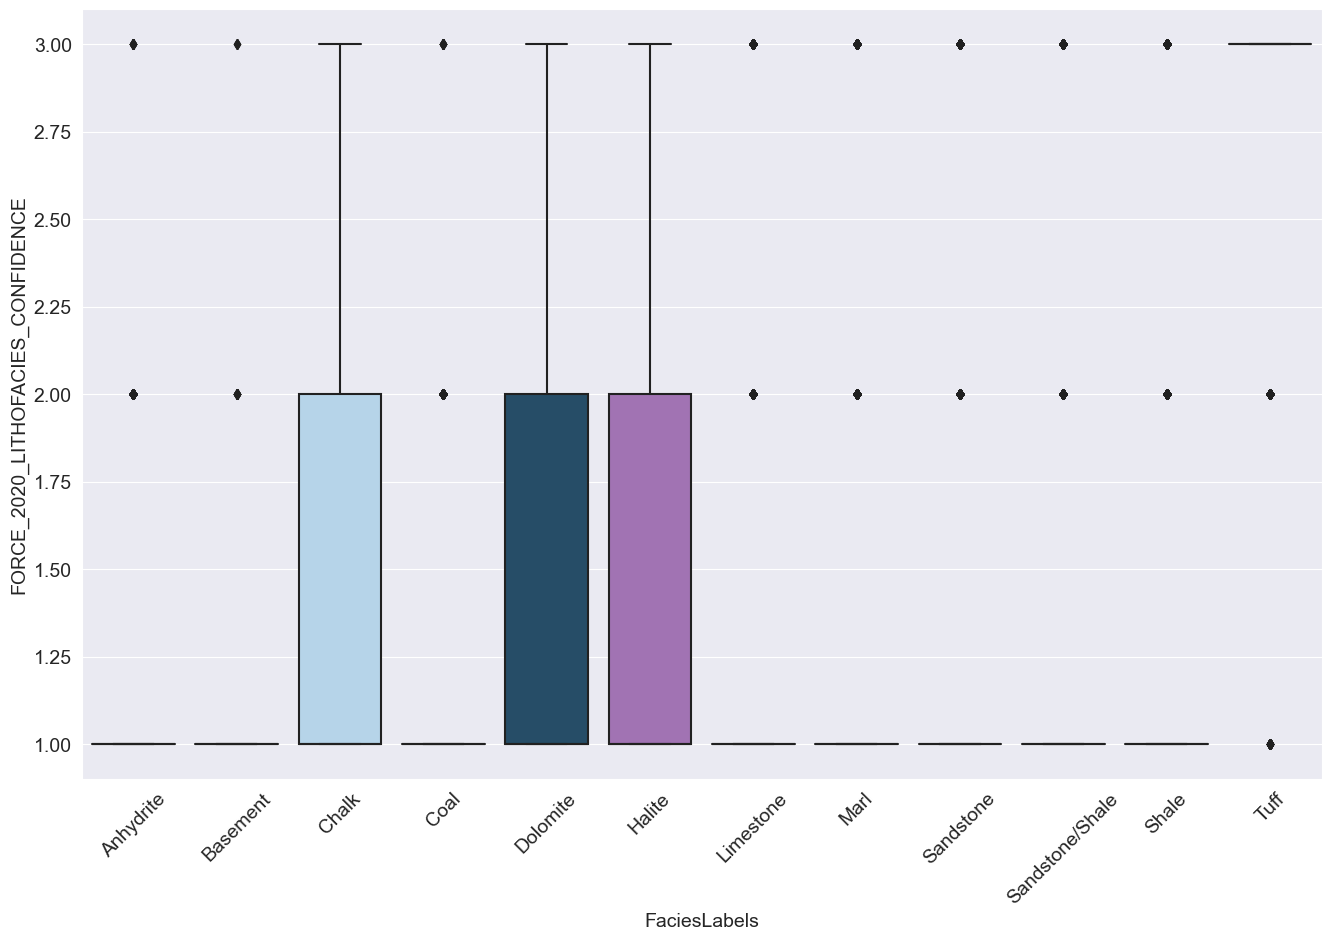

In [38]:
#Ящики с усами
numeric_columns = raw_df.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_columns[1:]:
    if col != 'NM_M':
        fig = plt.figure()
        fig.set_size_inches(16, 10)
        sns.boxplot(y=col, x=raw_df['FaciesLabels'].astype('category'), data=raw_df, palette=facies_colors)
        plt.xticks(rotation=45)
        plt.show()

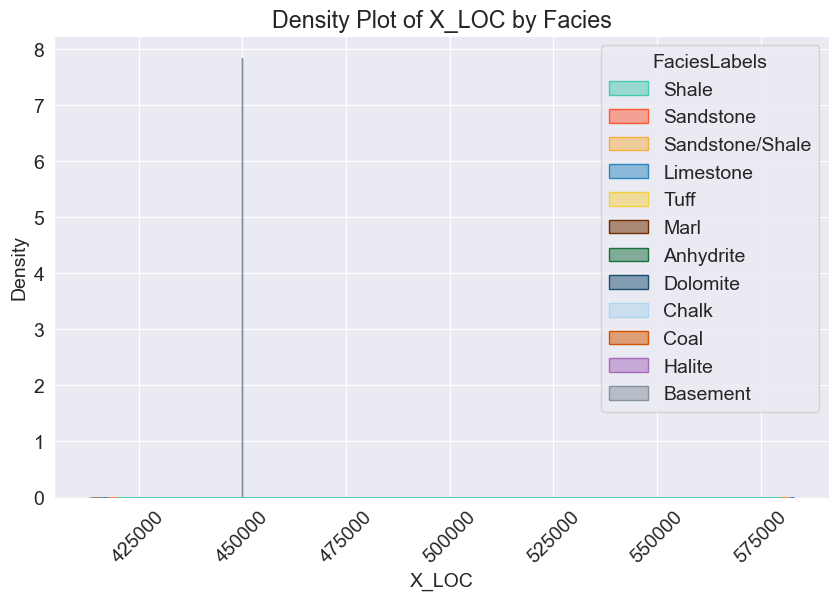

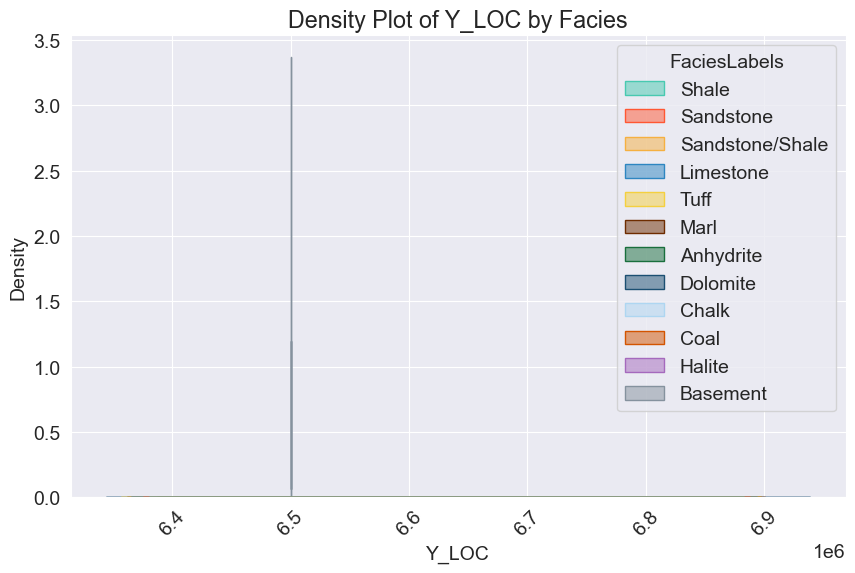

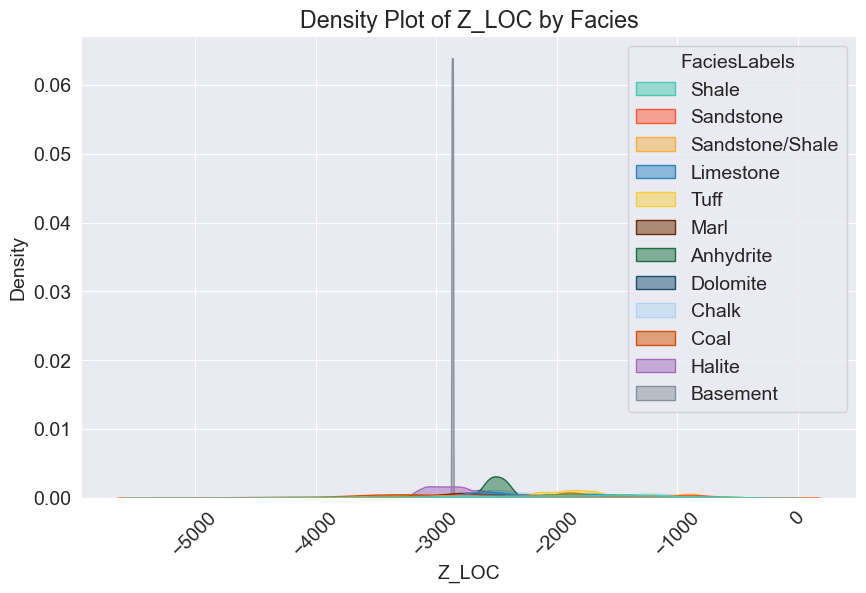

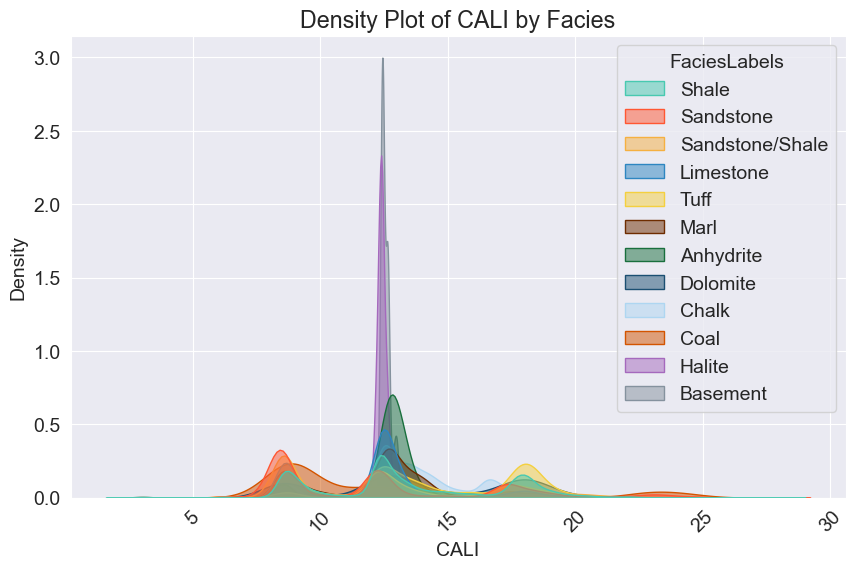

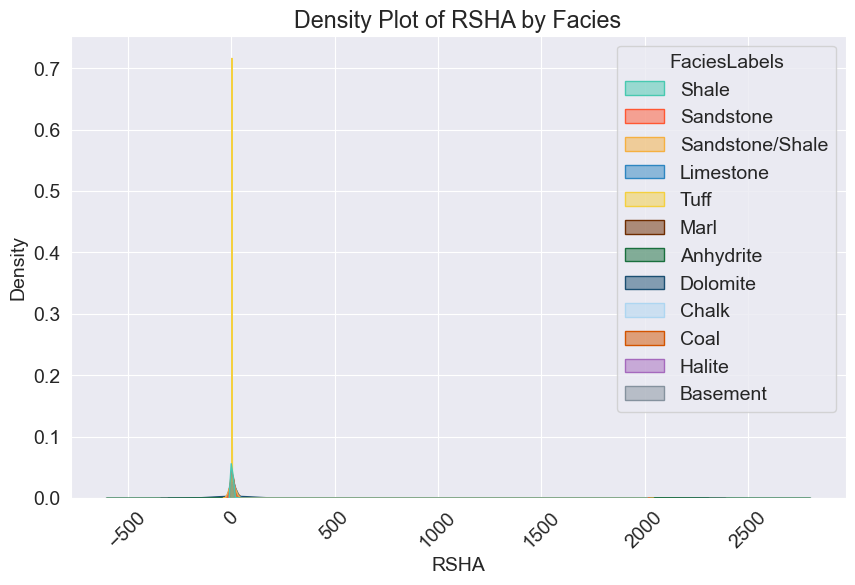

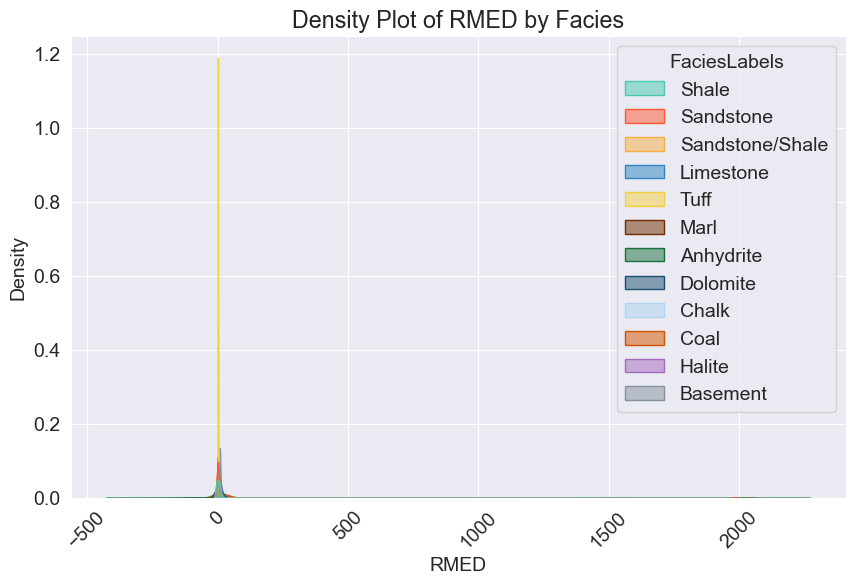

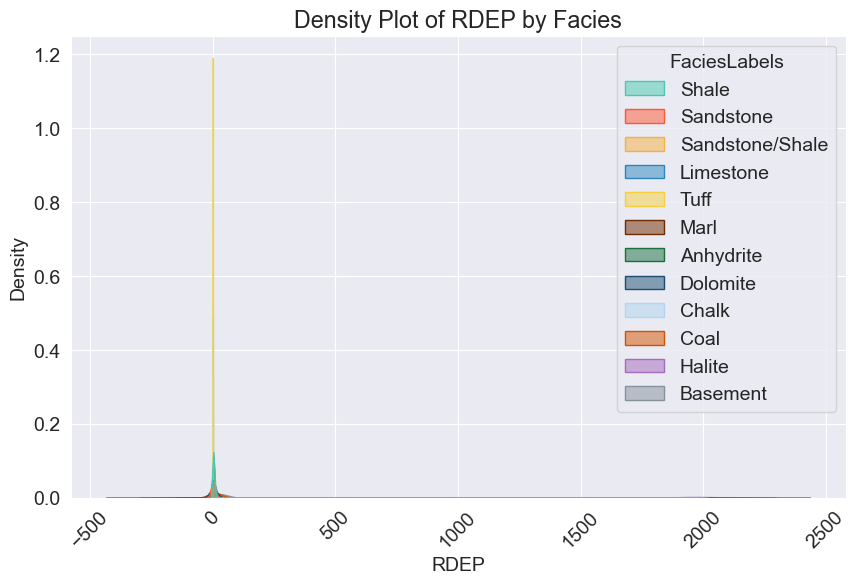

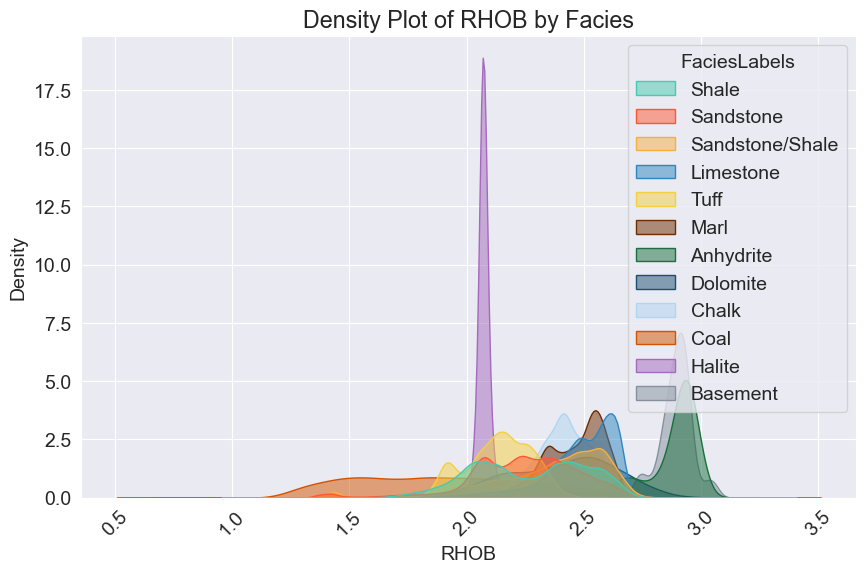

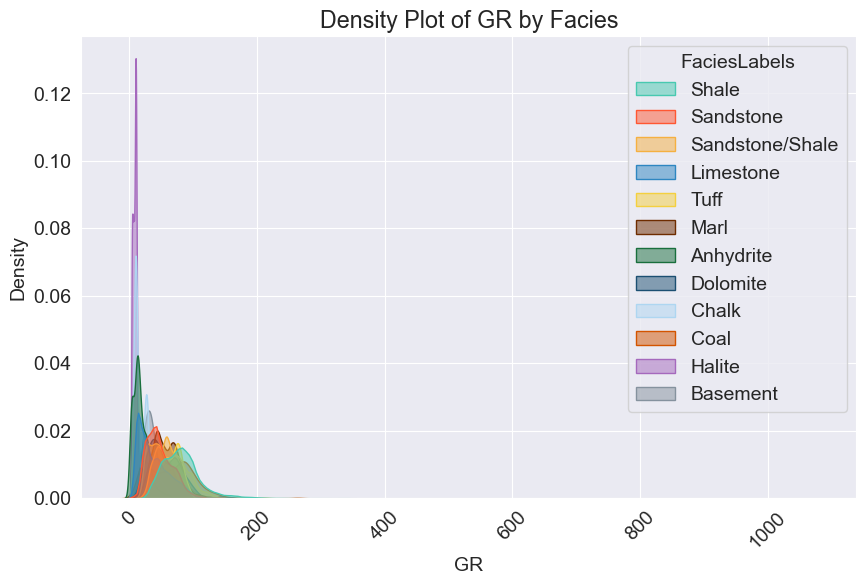

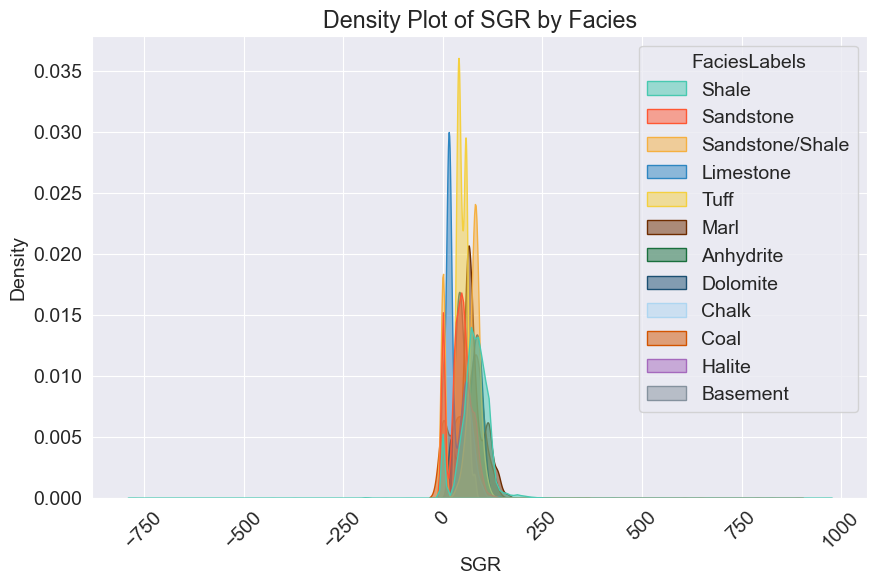

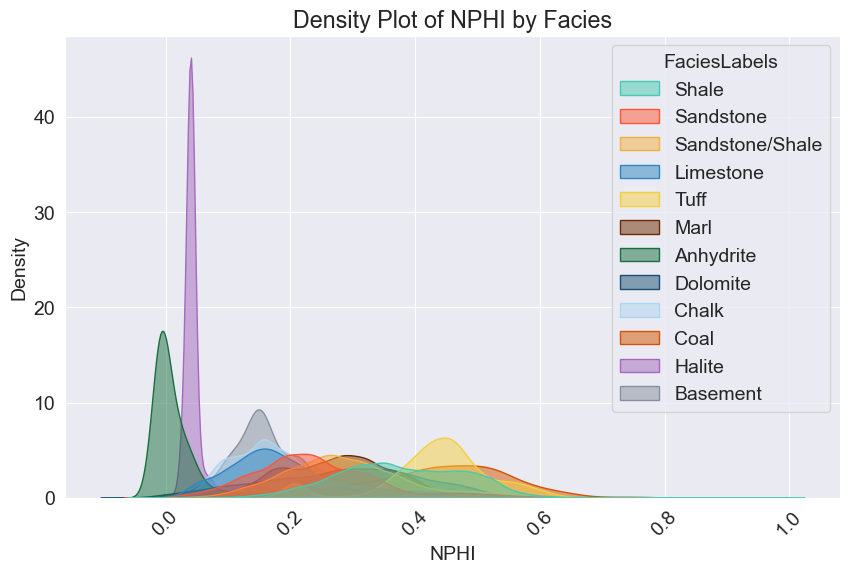

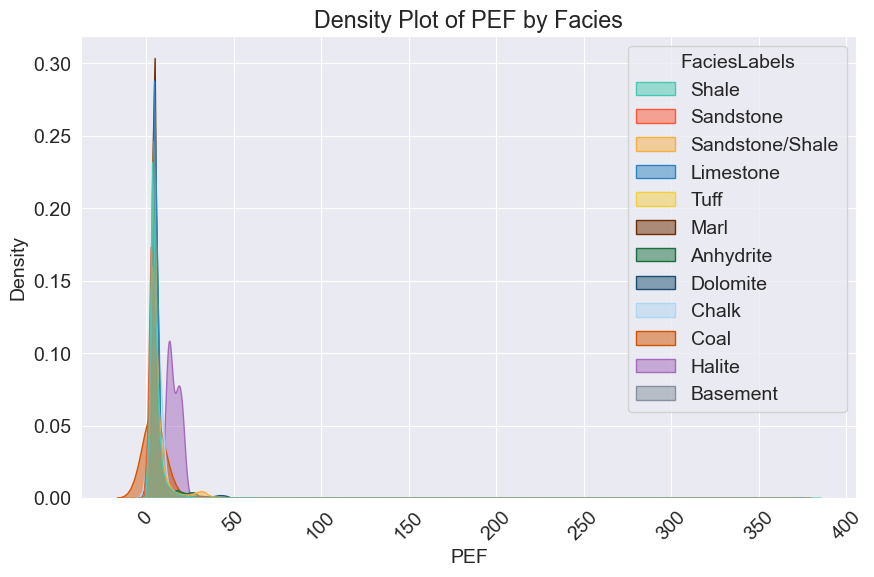

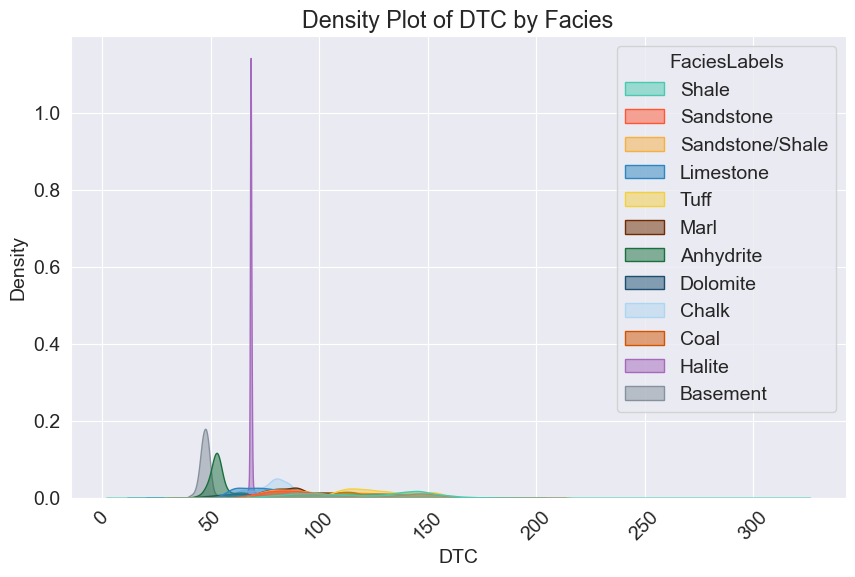

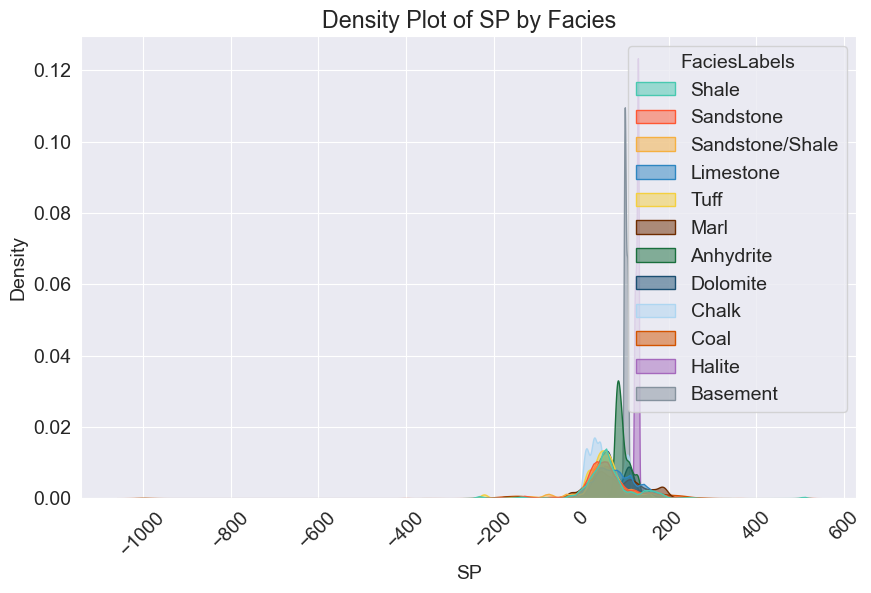

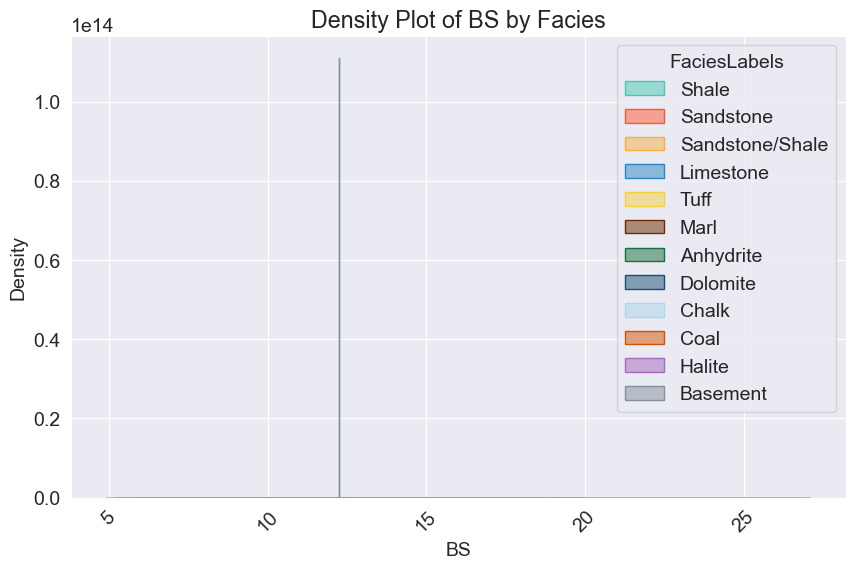

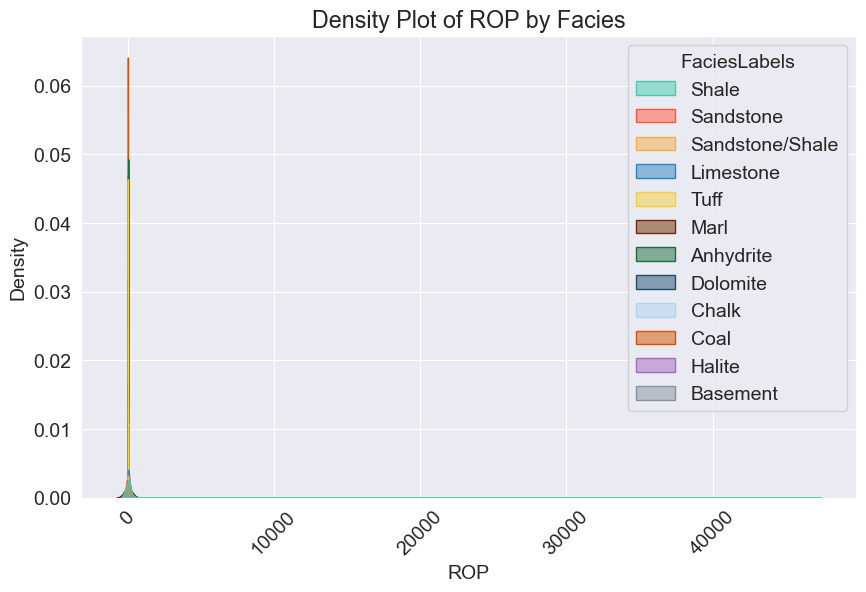

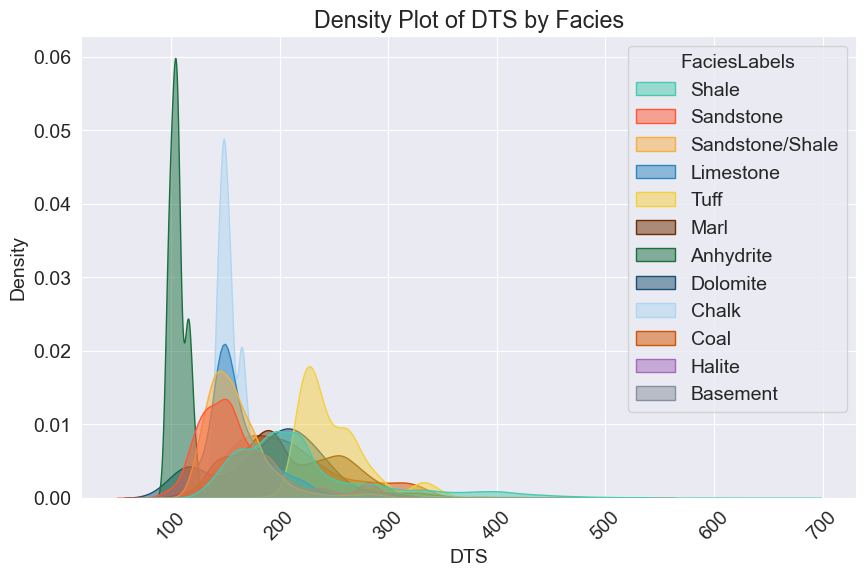

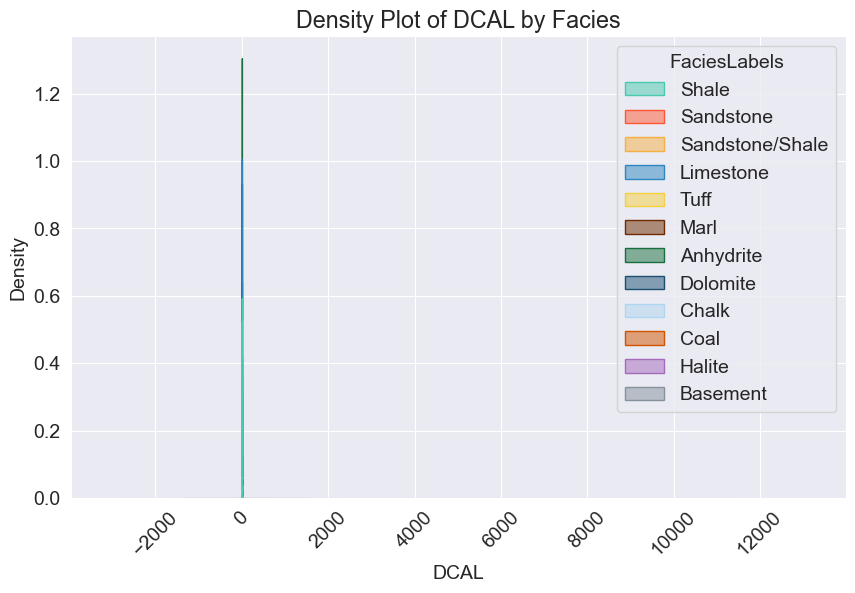

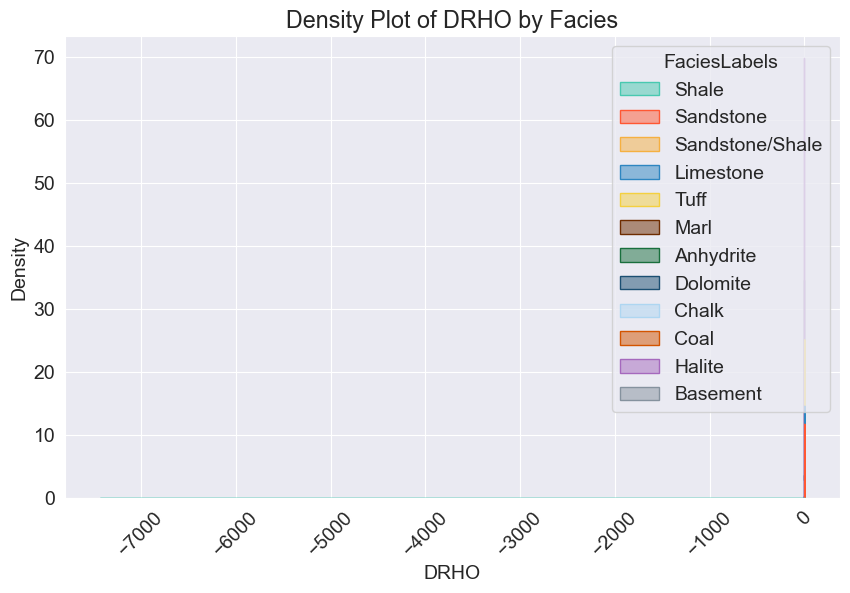

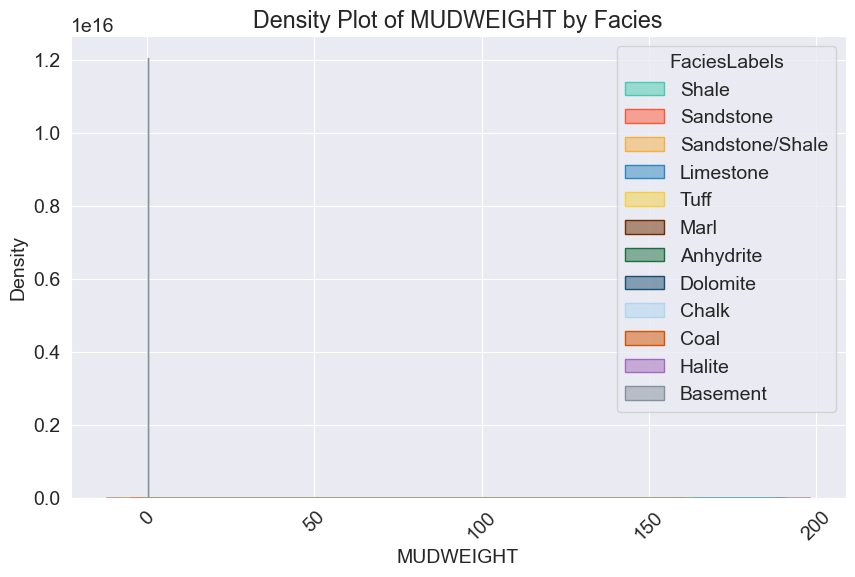

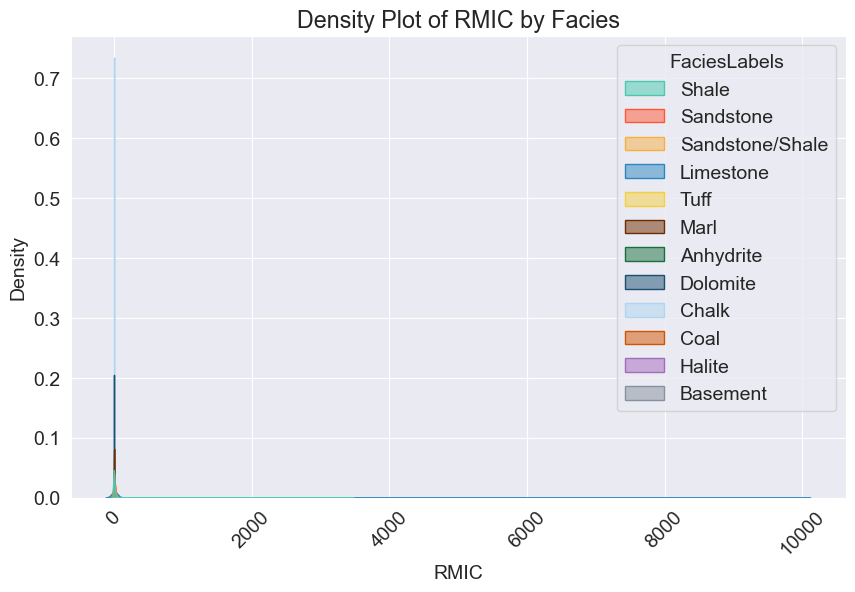

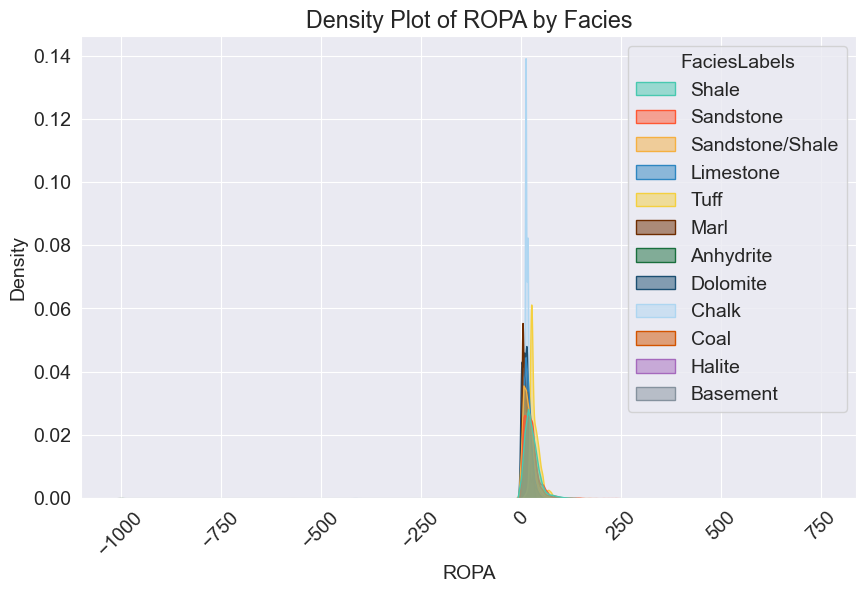

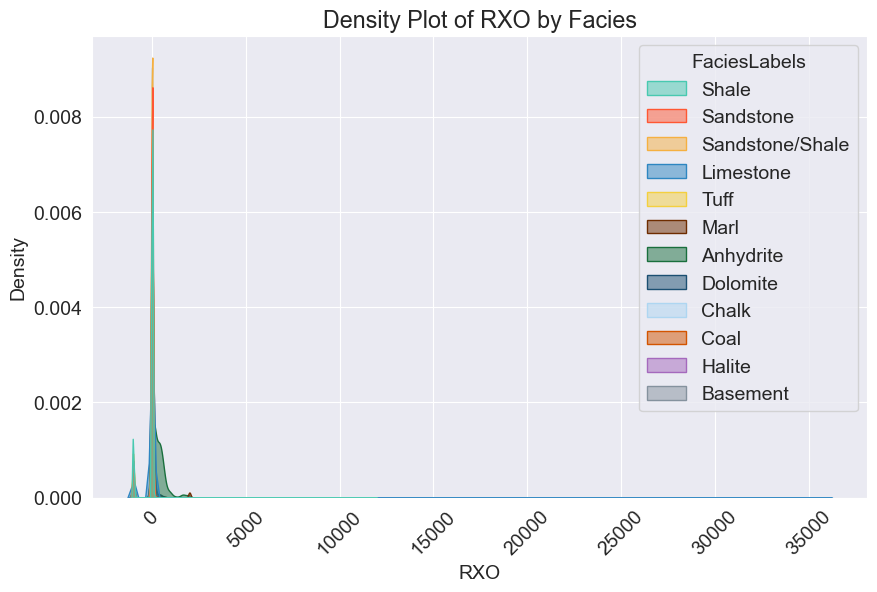

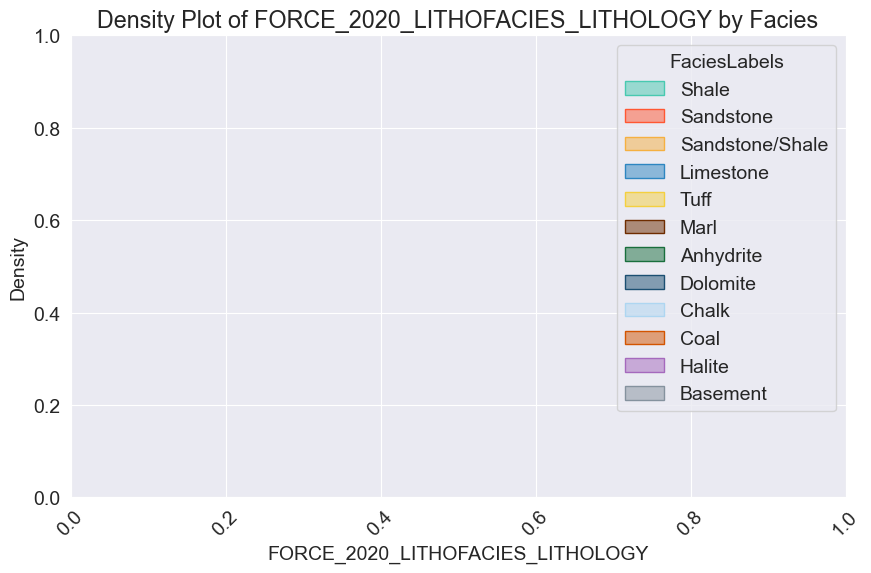

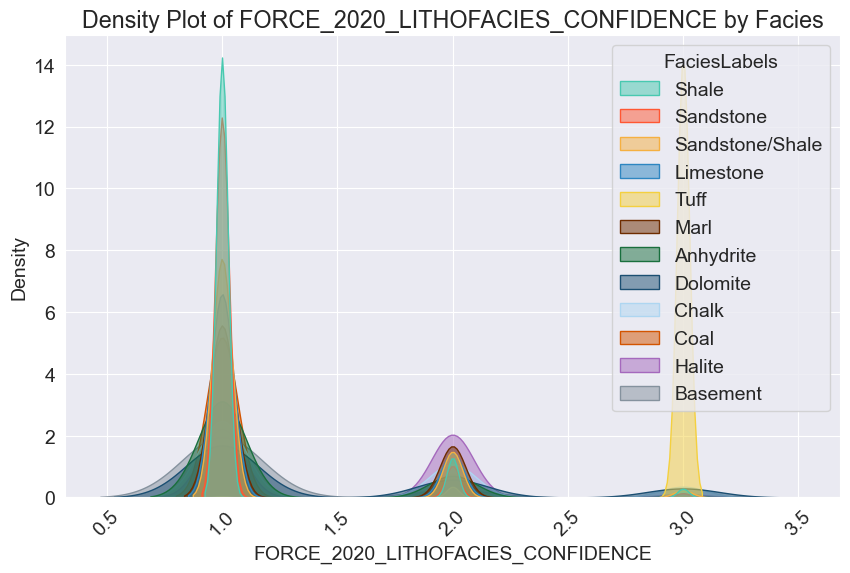

In [46]:
for col in numeric_columns[1:]:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=raw_df, x=col, hue='FaciesLabels', fill=True, common_norm=False, palette=facies_colors, alpha=0.5)
    plt.title(f'Density Plot of {col} by Facies')
    plt.xlabel(col)
    plt.ylabel('Density')
    #legend_labels = [facies_colors[color] for color in facies_colors.values()]
    # plt.legend(title='Facies', labels=legend_labels)
    #plt.legend(title='Facies')
    plt.xticks(rotation=45) 
    plt.show()

Подсчет количества уникальных и пропущенных значений

In [49]:
dftype = pd.DataFrame(raw_df.dtypes, columns=['Data_Type'])
dftype['Number_Unique'] = raw_df.nunique()
dftype['Nan_bool'] = raw_df.isna().any()
dftype['Number_of_Nan'] = raw_df.isna().sum()
dftype

Data_Type  Number_Unique  Nan_bool  \
WELL                                 object             98     False   
DEPTH_MD                            float64        1146418     False   
X_LOC                               float64         166525      True   
Y_LOC                               float64          17481      True   
Z_LOC                               float64        1128126      True   
GROUP                                object             14      True   
FORMATION                            object             69      True   
CALI                                float64         874208      True   
RSHA                                float64         619225      True   
RMED                                float64        1104594      True   
RDEP                                float64        1131288      True   
RHOB                                float64         874676      True   
GR                                  float64        1133878     False   
SGR                                 float64          68776      True   
NPHI                                float64         736868      True   
PEF                                 float64         657490      True   
DTC                                 float64        1027931      True   
SP                                  float64         832034      True   
BS                                  float64            152      True   
ROP                                 float64         447585      True   
DTS                                 float64         172930      True   
DCAL                                float64         264010      True   
DRHO                                float64         930870      True   
MUDWEIGHT                           float64            276      True   
RMIC                                float64         175417      True   
ROPA                                float64         184033      True   
RXO                                 float64         289703      True   
FORCE_2020_LITHOFACIES_LITHOLOGY      int64             12     False   
FORCE_2020_LITHOFACIES_CONFIDENCE   float64              3      True   
FaciesLabels                         object             12     False   

                                   Number_of_Nan  
WELL                                           0  
DEPTH_MD                                       0  
X_LOC                                      10775  
Y_LOC                                      10775  
Z_LOC                                      10775  
GROUP                                       1278  
FORMATION                                 136994  
CALI                                       87877  
RSHA                                      539861  
RMED                                       38993  
RDEP                                       11015  
RHOB                                      161269  
GR                                             0  
SGR                                      1101158  
NPHI                                      405102  
PEF                                       498819  
DTC                                        80863  
SP                                        306264  
BS                                        487854  
ROP                                       635440  
DTS                                       995898  
DCAL                                      871678  
DRHO                                      182654  
MUDWEIGHT                                 854360  
RMIC                                      994351  
ROPA                                      978186  
RXO                                       843084  
FORCE_2020_LITHOFACIES_LITHOLOGY               0  
FORCE_2020_LITHOFACIES_CONFIDENCE            179  
FaciesLabels                                   0

Замена пропущенных значений в численных колонках средним значением

In [50]:
raw_df[numeric_columns] = raw_df[numeric_columns].fillna(raw_df[numeric_columns].mean())

In [51]:
raw_df[numeric_columns].isna().sum()

DEPTH_MD                             0
X_LOC                                0
Y_LOC                                0
Z_LOC                                0
CALI                                 0
RSHA                                 0
RMED                                 0
RDEP                                 0
RHOB                                 0
GR                                   0
SGR                                  0
NPHI                                 0
PEF                                  0
DTC                                  0
SP                                   0
BS                                   0
ROP                                  0
DTS                                  0
DCAL                                 0
DRHO                                 0
MUDWEIGHT                            0
RMIC                                 0
ROPA                                 0
RXO                                  0
FORCE_2020_LITHOFACIES_LITHOLOGY     0
FORCE_2020_LITHOFACIES_CO

### 2.4 Нормализация данных

Выбор признаков, которые будут использоваться для классификации

In [52]:
features = ['RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'BS', 'ROP', 'DTS']

In [53]:
raw_df[features].head()

RSHA      RMED      RDEP      RHOB         GR      NPHI        PEF  \
0  10.694664  1.611410  1.798681  1.884186  80.200851  0.331966  20.915468   
1  10.694664  1.618070  1.795641  1.889794  79.262886  0.331966  19.383013   
2  10.694664  1.626459  1.800733  1.896523  74.821999  0.331966  22.591518   
3  10.694664  1.621594  1.801517  1.891913  72.878922  0.331966  32.191910   
4  10.694664  1.602679  1.795299  1.880034  71.729141  0.331966  38.495632   

          DTC         BS        ROP         DTS  
0  161.131180  11.931432  34.636410  204.655019  
1  160.603470  11.931432  34.636410  204.655019  
2  160.173615  11.931432  34.779556  204.655019  
3  160.149429  11.931432  39.965164  204.655019  
4  160.128342  11.931432  57.483765  204.655019

In [54]:
scaler = MinMaxScaler().fit(raw_df[features])

In [60]:
transformed_df = raw_df

transformed_df[features] = scaler.transform(raw_df[features])

In [61]:
transformed_df.describe()

DEPTH_MD         X_LOC         Y_LOC         Z_LOC          CALI  \
count  1.170511e+06  1.170511e+06  1.170511e+06  1.170511e+06  1.170511e+06   
mean   2.184087e+03  4.856310e+05  6.681276e+06 -2.138527e+03  1.318568e+01   
std    9.971821e+02  3.439699e+04  1.275612e+05  9.664633e+02  3.653522e+00   
min    1.360860e+02  4.268988e+05  6.406641e+06 -5.395563e+03  2.344000e+00   
25%    1.418597e+03  4.548019e+05  6.593126e+06 -2.804552e+03  9.882808e+00   
50%    2.076605e+03  4.777699e+05  6.732132e+06 -2.055283e+03  1.272100e+01   
75%    2.864393e+03  5.201314e+05  6.784877e+06 -1.397964e+03  1.574931e+01   
max    5.436632e+03  5.726328e+05  6.856661e+06 -1.110860e+02  2.827900e+01   

               RSHA          RMED          RDEP          RHOB            GR  \
count  1.170511e+06  1.170511e+06  1.170511e+06  1.170511e+06  1.170511e+06   
mean   4.874672e-03  2.511986e-03  5.330048e-03  5.714658e-01  6.575114e-02   
std    3.367212e-02  2.703090e-02  5.670939e-02  8.593419e-02  3.178840e-02   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    5.907715e-04  4.713978e-04  4.416133e-04  5.123182e-01  4.412660e-02   
50%    4.736759e-03  7.534114e-04  7.090959e-04  5.714658e-01  6.338678e-02   
75%    4.874672e-03  1.525811e-03  1.292097e-03  6.365009e-01  8.257961e-02   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

       ...           ROP           DTS          DCAL          DRHO  \
count  ...  1.170511e+06  1.170511e+06  1.170511e+06  1.170511e+06   
mean   ...  2.924284e-03  2.230631e-01  1.223849e+00  1.219638e-02   
std    ...  2.213736e-02  4.518985e-02  2.747313e+01  6.869624e+00   
min    ...  0.000000e+00  0.000000e+00 -1.221546e+01 -7.429339e+03   
25%    ...  4.408839e-04  2.230631e-01  1.223849e+00 -6.882701e-03   
50%    ...  2.924284e-03  2.230631e-01  1.223849e+00  6.651836e-03   
75%    ...  2.924284e-03  2.230631e-01  1.223849e+00  1.555134e-02   
max    ...  1.000000e+00  1.000000e+00  1.001142e+04  2.836938e+00   

          MUDWEIGHT          RMIC          ROPA           RXO  \
count  1.170511e+06  1.170511e+06  1.170511e+06  1.170511e+06   
mean   1.216329e+00  7.796809e+00  2.350507e+01 -9.577950e+01   
std    5.291056e+00  3.481446e+01  9.174184e+00  1.845736e+02   
min    1.258177e-01  5.658556e-02 -9.992501e+02 -9.999000e+02   
25%    1.216329e+00  7.796809e+00  2.350507e+01 -9.577950e+01   
50%    1.216329e+00  7.796809e+00  2.350507e+01 -9.577950e+01   
75%    1.216329e+00  7.796809e+00  2.350507e+01  1.201068e-01   
max    1.857309e+02  1.000000e+04  7.427979e+02  3.593067e+04   

       FORCE_2020_LITHOFACIES_LITHOLOGY  FORCE_2020_LITHOFACIES_CONFIDENCE  
count                      1.170511e+06                       1.170511e+06  
mean                       6.138598e+04                       1.164258e+00  
std                        1.389170e+04                       4.450840e-01  
min                        3.000000e+04                       1.000000e+00  
25%                        6.500000e+04                       1.000000e+00  
50%                        6.500000e+04                       1.000000e+00  
75%                        6.500000e+04                       1.000000e+00  
max                        9.900000e+04                       3.000000e+00  

[8 rows x 26 columns]

In [62]:
transformed_df

WELL   DEPTH_MD         X_LOC         Y_LOC        Z_LOC  \
0        15/9-13   494.5280  437641.96875  6.470972e+06  -469.501831   
1        15/9-13   494.6800  437641.96875  6.470972e+06  -469.653809   
2        15/9-13   494.8320  437641.96875  6.470972e+06  -469.805786   
3        15/9-13   494.9840  437641.96875  6.470972e+06  -469.957794   
4        15/9-13   495.1360  437641.96875  6.470972e+06  -470.109772   
...          ...        ...           ...           ...          ...   
1170506  7/1-2 S  3169.3124  485631.03274  6.681276e+06 -2138.527143   
1170507  7/1-2 S  3169.4644  485631.03274  6.681276e+06 -2138.527143   
1170508  7/1-2 S  3169.6164  485631.03274  6.681276e+06 -2138.527143   
1170509  7/1-2 S  3169.7684  485631.03274  6.681276e+06 -2138.527143   
1170510  7/1-2 S  3169.9204  485631.03274  6.681276e+06 -2138.527143   

                GROUP  FORMATION       CALI      RSHA      RMED  ...  \
0        NORDLAND GP.        NaN  19.480835  0.004875  0.000815  ...   
1        NORDLAND GP.        NaN  19.468800  0.004875  0.000818  ...   
2        NORDLAND GP.        NaN  19.468800  0.004875  0.000822  ...   
3        NORDLAND GP.        NaN  19.459282  0.004875  0.000820  ...   
4        NORDLAND GP.        NaN  19.453100  0.004875  0.000810  ...   
...               ...        ...        ...       ...       ...  ...   
1170506  VESTLAND GP.  Bryne Fm.   8.423170  0.004875  0.002512  ...   
1170507  VESTLAND GP.  Bryne Fm.   8.379244  0.004875  0.002512  ...   
1170508  VESTLAND GP.  Bryne Fm.   8.350248  0.004875  0.002512  ...   
1170509  VESTLAND GP.  Bryne Fm.   8.313779  0.004875  0.002512  ...   
1170510  VESTLAND GP.  Bryne Fm.   8.294910  0.004875  0.002512  ...   

              DTS      DCAL      DRHO  MUDWEIGHT      RMIC       ROPA  \
0        0.223063  1.223849 -0.574928   1.216329  7.796809  23.505069   
1        0.223063  1.223849 -0.570188   1.216329  7.796809  23.505069   
2        0.223063  1.223849 -0.574245   1.216329  7.796809  23.505069   
3        0.223063  1.223849 -0.586315   1.216329  7.796809  23.505069   
4        0.223063  1.223849 -0.597914   1.216329  7.796809  23.505069   
...           ...       ...       ...        ...       ...        ...   
1170506  0.223063  1.223849 -0.001763   1.216329  7.796809  26.673708   
1170507  0.223063  1.223849 -0.007600   1.216329  7.796809  26.840818   
1170508  0.223063  1.223849 -0.018297   1.216329  7.796809  27.007942   
1170509  0.223063  1.223849 -0.011438   1.216329  7.796809  27.175179   
1170510  0.223063  1.223849 -0.011398   1.216329  7.796809  27.342442   

               RXO  FORCE_2020_LITHOFACIES_LITHOLOGY  \
0       -95.779496                             65000   
1       -95.779496                             65000   
2       -95.779496                             65000   
3       -95.779496                             65000   
4       -95.779496                             65000   
...            ...                               ...   
1170506 -95.779496                             30000   
1170507 -95.779496                             65030   
1170508 -95.779496                             65030   
1170509 -95.779496                             65030   
1170510 -95.779496                             65030   

         FORCE_2020_LITHOFACIES_CONFIDENCE     FaciesLabels  
0                                      1.0            Shale  
1                                      1.0            Shale  
2                                      1.0            Shale  
3                                      1.0            Shale  
4                                      1.0            Shale  
...                                    ...              ...  
1170506                                2.0        Sandstone  
1170507                                2.0  Sandstone/Shale  
1170508                                2.0  Sandstone/Shale  
1170509                                2.0  Sandstone/Shale  
1170510                                2.0  Sandst

In [66]:
#Сохранение в файл 
selected_columns = features + ['FaciesLabels', 'FORCE_2020_LITHOFACIES_LITHOLOGY']

# Сохранение DataFrame в файл CSV
transformed_df[selected_columns].to_csv('../FaciesClassification/data/processed_data/transformed_data.csv', 
                                        index=False)

OSError: Cannot save file into a non-existent directory: '..\FaciesClassification\data\processed_data'

## 3. Подготовка данных

In [67]:
transformed_df['WELL'].value_counts().head()

25/2-7     25131
29/6-1     24464
25/7-2     23879
35/11-6    23544
34/2-4     23403
Name: WELL, dtype: int64

#### 3.1 Выбор валидационной части

Выберем валидационную часть случайным образом из всех скважин

In [68]:
transformed_df['WELL'].unique()

array(['15/9-13', '15/9-15', '15/9-17', '16/1-2', '16/1-6 A', '16/10-1',
       '16/10-2', '16/10-3', '16/10-5', '16/11-1 ST3', '16/2-11 A',
       '16/2-16', '16/2-6', '16/4-1', '16/5-3', '16/7-4', '16/7-5',
       '16/8-1', '17/11-1', '25/11-15', '25/11-19 S', '25/11-5',
       '25/2-13 T4', '25/2-14', '25/2-7', '25/3-1', '25/4-5', '25/5-1',
       '25/5-4', '25/6-1', '25/6-2', '25/6-3', '25/7-2', '25/8-5 S',
       '25/8-7', '25/9-1', '26/4-1', '29/6-1', '30/3-3', '30/3-5 S',
       '30/6-5', '31/2-1', '31/2-19 S', '31/2-7', '31/2-8', '31/2-9',
       '31/3-1', '31/3-2', '31/3-3', '31/3-4', '31/4-10', '31/4-5',
       '31/5-4 S', '31/6-5', '31/6-8', '32/2-1', '33/5-2', '33/6-3 S',
       '33/9-1', '33/9-17', '34/10-19', '34/10-21', '34/10-33',
       '34/10-35', '34/11-1', '34/11-2 S', '34/12-1', '34/2-4',
       '34/3-1 A', '34/4-10 R', '34/5-1 A', '34/5-1 S', '34/7-13',
       '34/7-20', '34/7-21', '34/8-1', '34/8-3', '34/8-7 R', '35/11-1',
       '35/11-10', '35/11-11', '35/11-12

In [92]:
import random
random.seed(42) 
all_wells = transformed_df['WELL'].unique().tolist()
num_validation_wells = int(len(all_wells) * 0.2)
validation_wells = random.sample(all_wells, num_validation_wells)

# Определяем тренировочные скважины, исключая скважины из валидационного набора
training_wells = [well for well in all_wells if well not in validation_wells]

In [94]:
print("Скважины из валидационного набора:", validation_wells)

print("Скважины из тренировочного набора:", training_wells)

Скважины из валидационного набора: ['35/11-12', '16/5-3', '16/1-2', '35/9-6 S', '25/9-1', '25/6-3', '25/5-4', '16/8-1', '16/4-1', '35/12-1', '34/4-10 R', '16/2-16', '34/8-1', '31/6-8', '16/1-6 A', '25/5-1', '25/6-1', '34/11-1', '34/8-7 R']
Скважины из тренировочного набора: ['15/9-13', '15/9-15', '15/9-17', '16/10-1', '16/10-2', '16/10-3', '16/10-5', '16/11-1 ST3', '16/2-11 A', '16/2-6', '16/7-4', '16/7-5', '17/11-1', '25/11-15', '25/11-19 S', '25/11-5', '25/2-13 T4', '25/2-14', '25/2-7', '25/3-1', '25/4-5', '25/6-2', '25/7-2', '25/8-5 S', '25/8-7', '26/4-1', '29/6-1', '30/3-3', '30/3-5 S', '30/6-5', '31/2-1', '31/2-19 S', '31/2-7', '31/2-8', '31/2-9', '31/3-1', '31/3-2', '31/3-3', '31/3-4', '31/4-10', '31/4-5', '31/5-4 S', '31/6-5', '32/2-1', '33/5-2', '33/6-3 S', '33/9-1', '33/9-17', '34/10-19', '34/10-21', '34/10-33', '34/10-35', '34/11-2 S', '34/12-1', '34/2-4', '34/3-1 A', '34/5-1 A', '34/5-1 S', '34/7-13', '34/7-20', '34/7-21', '34/8-3', '35/11-1', '35/11-10', '35/11-11', '35/11-

In [101]:
# Выбираем строки для валидационного набора
validation_data = transformed_df[transformed_df['WELL'].isin(validation_wells)]

In [102]:
validation_data['WELL'].value_counts()

35/11-12     19112
25/5-1       18473
34/8-1       17877
25/9-1       15743
16/4-1       14082
35/12-1      13125
35/9-6 S     13094
25/5-4       12997
25/6-3       11985
16/2-16      10025
31/6-8        9531
34/8-7 R      7084
16/8-1        6685
25/6-1        6209
34/11-1       4226
34/4-10 R     3880
16/1-6 A      3623
16/5-3        3021
16/1-2        1734
Name: WELL, dtype: int64

#### 3.2 Выбор тренировочной части

In [106]:
# Выбираем строки для тренировочного набора
training_data = transformed_df[~transformed_df['WELL'].isin(validation_wells)]

In [107]:
training_data.head()

WELL  DEPTH_MD         X_LOC      Y_LOC       Z_LOC         GROUP  \
0  15/9-13   494.528  437641.96875  6470972.5 -469.501831  NORDLAND GP.   
1  15/9-13   494.680  437641.96875  6470972.5 -469.653809  NORDLAND GP.   
2  15/9-13   494.832  437641.96875  6470972.5 -469.805786  NORDLAND GP.   
3  15/9-13   494.984  437641.96875  6470972.5 -469.957794  NORDLAND GP.   
4  15/9-13   495.136  437641.96875  6470972.5 -470.109772  NORDLAND GP.   

  FORMATION       CALI      RSHA      RMED  ...       DTS      DCAL      DRHO  \
0       NaN  19.480835  0.004875  0.000815  ...  0.223063  1.223849 -0.574928   
1       NaN  19.468800  0.004875  0.000818  ...  0.223063  1.223849 -0.570188   
2       NaN  19.468800  0.004875  0.000822  ...  0.223063  1.223849 -0.574245   
3       NaN  19.459282  0.004875  0.000820  ...  0.223063  1.223849 -0.586315   
4       NaN  19.453100  0.004875  0.000810  ...  0.223063  1.223849 -0.597914   

   MUDWEIGHT      RMIC       ROPA        RXO  \
0   1.216329  7.796809  23.505069 -95.779496   
1   1.216329  7.796809  23.505069 -95.779496   
2   1.216329  7.796809  23.505069 -95.779496   
3   1.216329  7.796809  23.505069 -95.779496   
4   1.216329  7.796809  23.505069 -95.779496   

   FORCE_2020_LITHOFACIES_LITHOLOGY  FORCE_2020_LITHOFACIES_CONFIDENCE  \
0                             65000                                1.0   
1                             65000                                1.0   
2                             65000                                1.0   
3                             65000                                1.0   
4                             65000                                1.0   

   FaciesLabels  
0         Shale  
1         Shale  
2         Shale  
3         Shale  
4         Shale  

[5 rows x 30 columns]

In [108]:
training_data.shape, validation_data.shape

((978005, 30), (192506, 30))

### 3.3 Разбиение на признаки и целевую переменную обеих частей

#### 3.3.1 Тенировочная часть

In [112]:
y_train = training_data['FaciesLabels']
X_train = training_data[features]

In [116]:
y_train.shape[0], X_train.shape 

(978005, (978005, 11))

#### 3.3.2 Валидационная часть

In [113]:
y_val = validation_data['FaciesLabels']
X_val = validation_data[features]

In [117]:
y_val.shape[0], X_val.shape

(192506, (192506, 11))

## 4. Обучение моделей

### 4.1 Логистическая регрессия

In [ ]:
%%time
model_logreg = LogisticRegression()

logreg_params = {
    'penalty': ['l1', 'l2'],  # тип регуляризации
    'C': [0.001, 0.01, 0.1, 1, 10],  # параметр регуляризации
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']  # алгоритм оптимизации
}

rs_logreg = RandomizedSearchCV(estimator=model_logreg, param_distributions=logreg_params, cv=3, scoring='accuracy', n_iter=10, random_state=42)

rs_logreg.fit(X_train, y_train)

In [ ]:
rs_logreg.best_params_

Обучение модели логистической регресии

In [121]:
model_logreg = LogisticRegression(solver = 'liblinear')

In [126]:
%%time
model_logreg.fit(X_train, y_train)

Wall time: 1min 27s


LogisticRegression(solver='liblinear')

Получение предсказаний

In [151]:
train_preds = model_logreg.predict(X_train)
print(train_preds)

['Shale' 'Shale' 'Shale' ... 'Shale' 'Shale' 'Shale']


Вероятности, с которой модель отнесла первый элемент из тренировочного набора к каждому из классов

In [152]:
probs = model_logreg.predict_proba(X_train)[0]
classes = model_logreg.classes_

for class_, prob in zip(classes, probs):
    print(f"Class '{class_}': Probability {prob:.4f}")

Class 'Anhydrite': Probability 0.0000
Class 'Chalk': Probability 0.0003
Class 'Coal': Probability 0.0011
Class 'Dolomite': Probability 0.0005
Class 'Halite': Probability 0.0000
Class 'Limestone': Probability 0.0005
Class 'Marl': Probability 0.0015
Class 'Sandstone': Probability 0.0848
Class 'Sandstone/Shale': Probability 0.1004
Class 'Shale': Probability 0.8001
Class 'Tuff': Probability 0.0110


Точность на тренировочной и тестовой выборках

In [190]:
logreg_train_accuracy = accuracy_score(y_train, train_preds)
print(f"Accuracy на тренировочной выборке: {logreg_train_accuracy:.3f}")

Accuracy на тренировочной выборке: 0.698


In [191]:
logreg_val_preds = model_logreg.predict(X_val)

In [193]:
logreg_val_accuracy = accuracy_score(y_val, val_preds)
print(f"Accuracy на валидационной выборке: {logreg_val_accuracy:.3f}")

Accuracy на валидационной выборке: 0.665


Отчет о классификации на валидационной выборке

In [140]:
print(classification_report(y_val, val_preds, digits = 3))

                 precision    recall  f1-score   support

      Anhydrite      0.631     0.647     0.639       558
       Basement      0.000     0.000     0.000       103
          Chalk      0.000     0.000     0.000       656
           Coal      0.184     0.016     0.029       450
       Dolomite      0.000     0.000     0.000       490
         Halite      0.000     0.000     0.000         0
      Limestone      0.557     0.237     0.332      9240
           Marl      0.000     0.000     0.000      6459
      Sandstone      0.481     0.439     0.459     28441
Sandstone/Shale      0.404     0.025     0.048     26614
          Shale      0.702     0.963     0.812    116684
           Tuff      0.000     0.000     0.000      2811

       accuracy                          0.665    192506
      macro avg      0.247     0.194     0.193    192506
   weighted avg      0.581     0.665     0.584    192506



### 4.2 Решающее дерево

In [141]:
model_tree = DecisionTreeClassifier(random_state=42)

Обучение решающего дерева

In [143]:
%%time
model_tree.fit(X_train, y_train)

Wall time: 1min 6s


DecisionTreeClassifier(random_state=42)

Точность на тренировочной и тестовой выборках

In [195]:
train_preds_tree = model_tree.predict(X_train)

In [196]:
tree_train_accuracy = accuracy_score(train_preds_tree, y_train)
print(f"Accuracy на тренировочной выборке: {tree_train_accuracy:.3f}")

Accuracy на тренировочной выборке: 1.000


In [147]:
train_props = model_tree.predict_proba(X_train)

In [114]:
train_props

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [148]:
val_preds_tree = model_tree.predict(X_val)

In [200]:
tree_val_accuracy = accuracy_score(y_val, val_preds_tree)
print(f"Accuracy на валидационной выборке: {tree_val_accuracy:.3f}")

Accuracy на валидационной выборке: 0.561


In [198]:
print(classification_report(y_val, val_preds_tree))

                 precision    recall  f1-score   support

      Anhydrite       0.64      0.73      0.68       558
       Basement       0.00      0.00      0.00       103
          Chalk       0.04      0.07      0.05       656
           Coal       0.07      0.18      0.10       450
       Dolomite       0.00      0.01      0.01       490
         Halite       0.00      0.00      0.00         0
      Limestone       0.24      0.39      0.30      9240
           Marl       0.21      0.26      0.23      6459
      Sandstone       0.39      0.44      0.41     28441
Sandstone/Shale       0.26      0.19      0.22     26614
          Shale       0.76      0.72      0.74    116684
           Tuff       0.08      0.07      0.08      2811

       accuracy                           0.56    192506
      macro avg       0.22      0.26      0.24    192506
   weighted avg       0.58      0.56      0.57    192506



Ограничим глубину дерева

In [201]:
model_tree_2 = DecisionTreeClassifier(max_depth=8, random_state=42)

In [203]:
%%time
model_tree_2.fit(X_train, y_train)

Wall time: 24 s


DecisionTreeClassifier(max_depth=8, random_state=42)

Точность на тренировочной и тестовой выборках

In [206]:
train_preds_2 = model_tree_2.predict(X_train)
tree2_train_accuracy = accuracy_score(train_preds_2, y_train)
print(f"Accuracy на тренировочной выборке: {tree_train_accuracy:.3f}")

Accuracy на тренировочной выборке: 1.000


In [207]:
val_preds_2 = model_tree_2.predict(X_val)

In [124]:
val_preds_2

array(['Shale', 'Shale', 'Shale', ..., 'Shale', 'Shale', 'Shale'],
      dtype=object)

In [208]:
tree2_val_accuracy = accuracy_score(y_val, val_preds_2)
print(f"Accuracy на валидационной выборке: {tree2_val_accuracy:.3f}")

Accuracy на валидационной выборке: 0.649


Отчет о классификации на валидационной выборке

In [209]:
print(classification_report(y_val, val_preds_2))

                 precision    recall  f1-score   support

      Anhydrite       0.80      0.67      0.73       558
       Basement       0.00      0.00      0.00       103
          Chalk       0.00      0.00      0.00       656
           Coal       0.12      0.01      0.02       450
       Dolomite       0.00      0.00      0.00       490
         Halite       0.00      0.00      0.00         0
      Limestone       0.64      0.39      0.48      9240
           Marl       0.12      0.05      0.08      6459
      Sandstone       0.47      0.48      0.48     28441
Sandstone/Shale       0.29      0.11      0.16     26614
          Shale       0.72      0.89      0.80    116684
           Tuff       0.00      0.00      0.00      2811

       accuracy                           0.65    192506
      macro avg       0.26      0.22      0.23    192506
   weighted avg       0.58      0.65      0.60    192506



### 4.3 Случайный лес

In [219]:
%%time

RF_model = RandomForestClassifier()

RF_params = {
    'n_estimators': [100, 200, 500, 700],  # количество деревьев в лесу
    'criterion': ['gini', 'entropy'],  # критерий разделения
    'max_depth': [None, 10, 20, 30, 40, 50],  # максимальная глубина дерева
    'min_samples_split': [2, 5, 10],  # минимальное количество выборок для разделения узла
    'min_samples_leaf': [1, 2, 4],  # минимальное количество выборок в листовом узле
}

rs_randforest =  RandomizedSearchCV(estimator=RF_model, param_distributions=RF_params, cv=3, scoring='accuracy', n_iter=10, random_state=42)

rs_randforest.fit(X_train, y_train)

Wall time: 9h 53s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 500, 700]},
                   random_state=42, scoring='accuracy')

In [223]:
rs_randforest.best_params_

{'n_estimators': 700,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_depth': 10,
 'criterion': 'entropy'}

In [224]:
model_randomforest = RandomForestClassifier()

In [225]:
model_randomforest.set_params(**rs_randforest.best_params_)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=700)

In [227]:
model_randomforest.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=700)

In [229]:
train_preds_ranfor = model_randomforest.predict(X_train)
train_preds_ranfor

array(['Shale', 'Shale', 'Shale', ..., 'Shale', 'Shale', 'Shale'],
      dtype=object)

In [230]:
accuracy_score(train_preds_ranfor, y_train)

0.8169222038742133

In [231]:
val_preds_ranfor = model_randomforest.predict(X_val)

In [232]:
val_preds_ranfor

array(['Shale', 'Shale', 'Shale', ..., 'Shale', 'Shale', 'Shale'],
      dtype=object)

In [233]:
accuracy_score(val_preds_ranfor, y_val)

0.6716673766012488

In [135]:
model_randomforest.score(inputs_val, targets_val)

0.7179856267397677

In [140]:
print(classification_report(targets_val, val_preds_ranfor))

                 precision    recall  f1-score   support

      Anhydrite       0.00      0.00      0.00         0
          Chalk       0.70      0.16      0.26      2041
           Coal       1.00      0.17      0.29        89
       Dolomite       0.00      0.00      0.00        19
      Limestone       0.31      0.41      0.35      3540
           Marl       0.03      0.04      0.03      2079
      Sandstone       0.60      0.65      0.62     10105
Sandstone/Shale       0.44      0.31      0.36     11975
          Shale       0.83      0.86      0.85     64512
           Tuff       0.00      0.00      0.00       121

       accuracy                           0.72     94481
      macro avg       0.39      0.26      0.28     94481
   weighted avg       0.72      0.72      0.71     94481



### 4.5 X-GB Classifier

In [173]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)

In [220]:
%%time

model_XGboost = XGBClassifier(random_state=42)

XGboost_params = {
    'n_estimators': [100, 200, 300, 350],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3]
}

gs_XGboost = RandomizedSearchCV(estimator=model_XGboost, param_distributions=XGboost_params, cv=3, scoring='accuracy', n_jobs=-1)

gs_XGboost.fit(X_train, y_train_encoded)

KeyboardInterrupt: 

In [221]:
gs_XGboost.best_params_

{'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.01}

In [83]:
gs_XGboost.best_estimator_.score(inputs_train, targets_train_encoded)

0.718678847244036

In [170]:
XGboost_best_params = {'n_estimators': 100,
                       'max_depth': 3,
                       'learning_rate': 0.01}

In [84]:
model_XGboost.set_params(**gs_XGboost.best_params_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [174]:
%%time
model_XGboost.fit(X_train, y_train_encoded)

Wall time: 1min 14s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

Оценка метрик на обучающих и валидационных выборках

In [176]:
train_preds_XGboost = model_XGboost.predict(X_train)

print("Accuracy на тестовой выборке:", accuracy_score(train_preds_XGboost, y_train_encoded))

Accuracy на тестовой выборке: 0.8766775220985578


In [179]:
y_val_encoded = label_encoder.fit_transform(y_val)

val_preds_XGboost = model_XGboost.predict(X_val)

print("Accuracy на валидационной выборке:", accuracy_score(val_preds_XGboost, y_val_encoded))

Accuracy на валидационной выборке: 0.6544471341153003


In [182]:
print(classification_report(y_val_encoded, val_preds_XGboost, digits = 3))

              precision    recall  f1-score   support

           0      0.890     0.597     0.715       558
           1      0.000     0.000     0.000       103
           2      0.000     0.000     0.000       656
           3      0.000     0.000     0.000       450
           4      0.000     0.000     0.000       490
           5      0.500     0.487     0.493      9240
           6      0.430     0.227     0.298      6459
           7      0.528     0.553     0.540     28441
           8      0.275     0.152     0.196     26614
           9      0.743     0.855     0.795    116684
          10      0.330     0.055     0.095      2811

    accuracy                          0.654    192506
   macro avg      0.336     0.266     0.285    192506
weighted avg      0.612     0.654     0.626    192506



Визуализация результатов классификации

In [102]:
new_raw_df = pd.read_csv('../data/Vovle/CSV_train.csv', sep=';')

new_raw_df['WELL'].isin(val_ls)

new_val_df = new_raw_df[new_raw_df['WELL'].isin(val_ls)]

new_val_df.head()


WELL  DEPTH_MD       X_LOC      Y_LOC        Z_LOC          GROUP  \
1076030  35/4-1  1335.364  516083.375  6822415.5 -1309.289307  HORDALAND GP.   
1076031  35/4-1  1335.516  516083.375  6822415.5 -1309.441284  HORDALAND GP.   
1076032  35/4-1  1335.668  516083.375  6822415.5 -1309.593262  HORDALAND GP.   
1076033  35/4-1  1335.820  516083.375  6822415.5 -1309.745239  HORDALAND GP.   
1076034  35/4-1  1335.972  516083.375  6822415.5 -1309.897339  HORDALAND GP.   

        FORMATION  CALI  RSHA      RMED  ...        ROP  DTS  DCAL  DRHO  \
1076030       NaN   NaN   NaN  1.005212  ...  14.999701  NaN   NaN   NaN   
1076031       NaN   NaN   NaN  1.105142  ...  14.999701  NaN   NaN   NaN   
1076032       NaN   NaN   NaN  1.139547  ...  14.999701  NaN   NaN   NaN   
1076033       NaN   NaN   NaN  1.207895  ...  14.999701  NaN   NaN   NaN   
1076034       NaN   NaN   NaN  1.202395  ...  15.135280  NaN   NaN   NaN   

         MUDWEIGHT  RMIC  ROPA  RXO  FORCE_2020_LITHOFACIES_LITHOLOGY  \
1076030        NaN   NaN   NaN  NaN                             65000   
1076031        NaN   NaN   NaN  NaN                             65000   
1076032        NaN   NaN   NaN  NaN                             65000   
1076033        NaN   NaN   NaN  NaN                             65000   
1076034        NaN   NaN   NaN  NaN                             65000   

         FORCE_2020_LITHOFACIES_CONFIDENCE  
1076030                                1.0  
1076031                                1.0  
1076032                                1.0  
1076033                                1.0  
1076034                                1.0  

[5 rows x 29 columns]

In [109]:
val_single_pred = model_XGboost.predict(inputs_val)

new_val_df['Predicted_Lithology'] = val_single_pred.tolist()

In [110]:
lithology_numbers = {30000: 0,
                 65030: 1,
                 65000: 2,
                 80000: 3,
                 74000: 4,
                 70000: 5,
                 70032: 6,
                 88000: 7,
                 86000: 8,
                 99000: 9,
                 90000: 10,
                 93000: 11}

new_val_df['litho_real'] = new_val_df['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_numbers)
new_val_df['litho_real']
new_val_df['Depth'] = new_val_df['DEPTH_MD']
well = new_val_df['WELL']

In [111]:
wells_names = well.unique()

In [239]:
selected_logs = ['CALI', 'GR', 'RHOB', 'NPHI', 'RSHA', 'RDEP', 'PEF']

feature_names = ['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'GR', 'RSHA', 'RMED', 'RDEP', 'RHOB', 
                 'NPHI', 'PEF', 'DTC', 'DTS', 'SP', 'ROP', 'BS']

facies_names = lithology_keys.values()

facies_colors = ['darkorange', '#228B22', 'grey', 'cyan', 'gold', 'lightseagreen', 
                 'lawngreen', 'lightblue', 'tan', '#FF4500', '#000000', 'magenta']

#facies_color_map is a dictionary that maps facies labels to their respective colors

facies_color_map = {}
for ind, label in enumerate(facies_names):
    facies_color_map[label] = facies_colors[ind]

 

In [273]:
predicted_facies = pd.DataFrame(validation_data[validation_data['WELL'] == all_wells[well_no]])

In [256]:
pred_log = validation_data[validation_data['WELL'] == validation_wells[well_no]]
predicted_facies = model_randomforest.predict(pred_log[features])

In [368]:
predicted_facies = model_randomforest.predict(X_val)
predicted_facies2 = model_randomforest.predict(X_train)

In [356]:
lithology_numbers = {30000: 0,
                 65030: 1,
                 65000: 2,
                 80000: 3,
                 74000: 4,
                 70000: 5,
                 70032: 6,
                 88000: 7,
                 86000: 8,
                 99000: 9,
                 90000: 10,
                 93000: 11}

lithology_keys = {'Sandstone' : 30000,
                 'Sandstone/Shale' : 65030,
                 'Shale' : 65000,
                 'Marl' : 80000,
                 'Dolomite' : 74000,
                 'Limestone' : 70000,
                 'Chalk' : 70032,
                 'Halite' : 88000,
                 'Anhydrite' : 86000,
                 'Tuff' : 99000,
                 'Coal' : 90000,
                 'Basement' : 93000}

In [369]:
#rf_df = validation_data
rf_df = training_data
rf_df['PredictedFacies'] = predicted_facies2
rf_df['Depth'] = rf_df['DEPTH_MD']
rf_df['Facies'] = rf_df['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_numbers)
rf_df['PredictedFacies'] = rf_df['PredictedFacies'].map(lithology_keys).map(lithology_numbers)

In [306]:
facies_colors = ['darkorange', '#228B22', 'grey', 'cyan', 'gold', 'lightseagreen', 
                 'lawngreen', 'lightblue', 'tan', '#FF4500', '#000000', 'magenta']

In [307]:
facies_color_map = {}
for ind, label in enumerate(facies_names):
    facies_color_map[label] = facies_colors[ind]

In [417]:
def make_facies_preds_log_plot(logs, curves, well_name, facies_colors):
        
    #make sure logs are sorted by depth
    cmap_facies = ListedColormap(facies_colors, 'indexed')

    colours=['k','b','r','g','m','c','lime','gold','sienna']
    
    print(logs['Facies'].value_counts())

    ztop=logs['Depth'].min(); zbot=logs['Depth'].max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values, 1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs['PredictedFacies'].values, 1), 100, 1)
    num_curves = len(curves)
    f, ax = plt.subplots(nrows=1, ncols=num_curves+2, figsize=(num_curves*2, 14))
    
    for ic, col in enumerate(curves):
        
        # if the curve doesn't exist, make it zeros
        if np.all(np.isnan(logs[col])):
            curve = np.empty(logs[col].values.shape)
            curve[:] = np.nan
            
        else:
            curve = logs[col]
            
        ax[ic].plot(curve, logs['Depth'],colours[ic])
        ax[ic].set_xlabel(col)
        if ic != 0:
            ax[ic].set_yticklabels([]);

    # make the lithfacies column
    im1 = ax[num_curves].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=len(facies_colors)-1)
    
    im2 = ax[num_curves + 1].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies, vmin=0, vmax=len(facies_colors) - 1)

    divider = make_axes_locatable(ax[num_curves + 1])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar = plt.colorbar(im2, cax=cax)
    cbar.set_label((12*' ').join(['SS', 'SS-Sh', 'Sh', 
                                ' Marl', 'Dol', 'Lims', 'Chlk ', 
                                '  Hal', 'Anhy', 'Tuf', 'Coal', 'Bsmt']))
    cbar.set_ticks(range(0,1)); 
    cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=2)

    ax[0].set_ylabel("DEPTH")
    ax[num_curves].set_xlabel('Facies')
    ax[num_curves].set_yticklabels([])
    ax[num_curves].set_xticklabels([])
    ax[num_curves + 1].set_xlabel('Predicted Facies')
    ax[num_curves + 1].set_yticklabels([])
    ax[num_curves + 1].set_xticklabels([])
    
    f.suptitle('Well: %s'% well_name, fontsize=14, y=0.94)

In [400]:
training_wells[-8]

'35/8-4'

2     3585
3      510
1      447
0      200
5      188
10      12
Name: Facies, dtype: int64


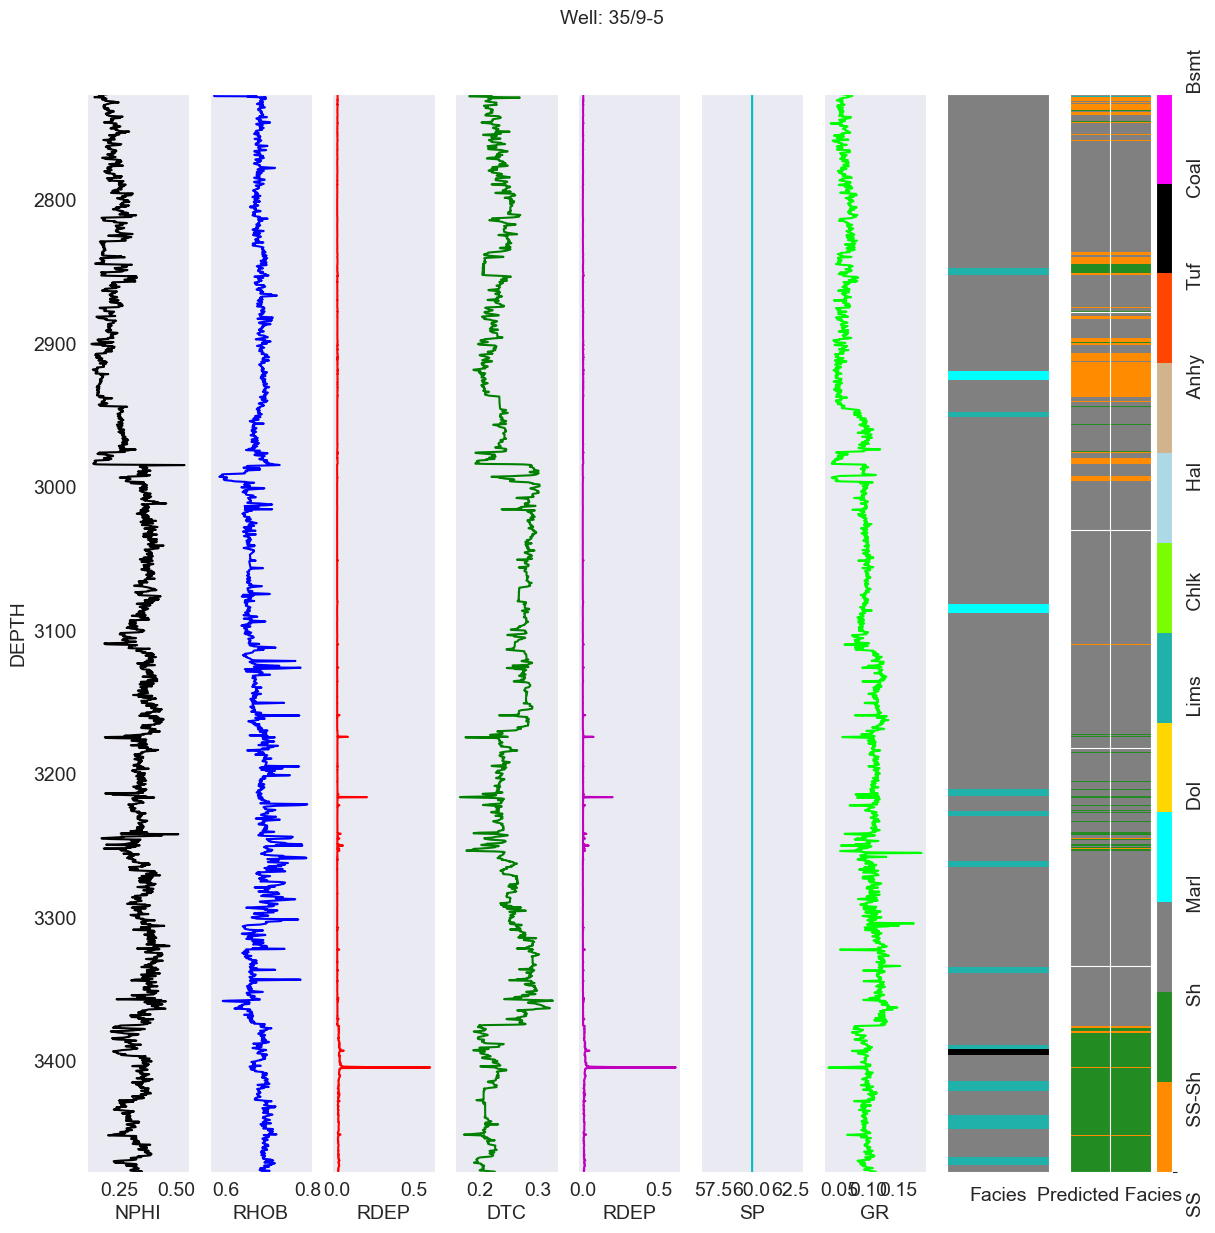

In [418]:
well_no = -4
make_facies_preds_log_plot(rf_df[rf_df['WELL'] == training_wells[well_no]], logs, training_wells[well_no], facies_colors)

In [403]:
def make_facies_log_plot(logs, curves, well_name, facies_colors):
        
    #make sure logs are sorted by depth
    cmap_facies = ListedColormap(facies_colors, 'indexed')

    colours=['k','b','r','g','m','c','lime','gold','sienna']
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    print(logs['Facies'].value_counts())
    cluster=np.repeat(logs['Facies'].values.reshape(-1, 1),50,axis=1)
    
    num_curves = len(curves)
    f, ax = plt.subplots(nrows=1, ncols=num_curves+1, figsize=(num_curves*2, 12))
    
    for ic, col in enumerate(curves):
        
        # if the curve doesn't exist, make it zeros
        if np.all(np.isnan(logs[col])):
            curve = np.empty(logs[col].values.shape)
            curve[:] = np.nan
            
        else:
            curve = logs[col]
            
        ax[ic].plot(curve, logs.Depth,colours[ic])
        ax[ic].set_xlabel(col)
        if ic != 0:
            ax[ic].set_yticklabels([]);

    # make the lithfacies column
    im=ax[num_curves].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=len(facies_colors)-1)
    
    divider = make_axes_locatable(ax[num_curves])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((13*' ').join(['  SS', 'SS-Sh', 'Sh', 
                                ' Marl', 'Dol', 'Lims', 'Chlk ', 
                                '  Hal', 'Anhy', 'Tuf', 'Coal', 'Bsmt']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)

    ax[0].set_ylabel("DEPTH")
    ax[num_curves].set_xlabel('Lithology')
    ax[num_curves].set_yticklabels([])
    ax[num_curves].set_xticklabels([])
    
    f.suptitle('Well: %s'% well_name, fontsize=14,y=0.94)

2     3585
3      510
1      447
0      200
5      188
10      12
Name: Facies, dtype: int64


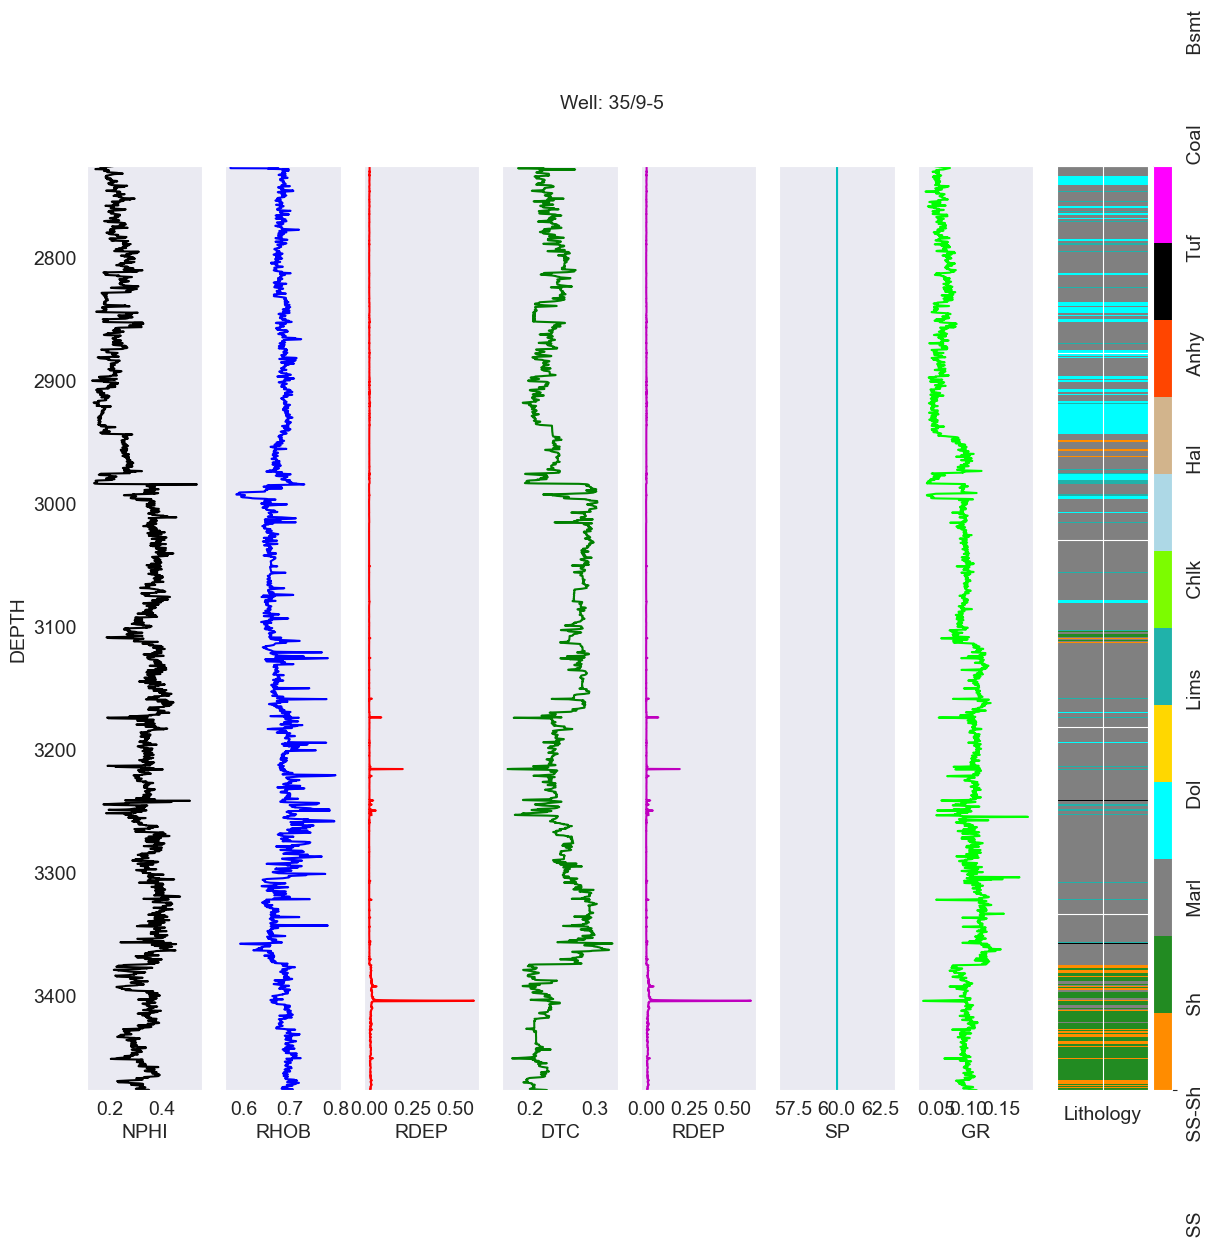

In [414]:
make_facies_log_plot(rf_df[rf_df['WELL'] == training_wells[well_no]], logs, training_wells[well_no], facies_colors)

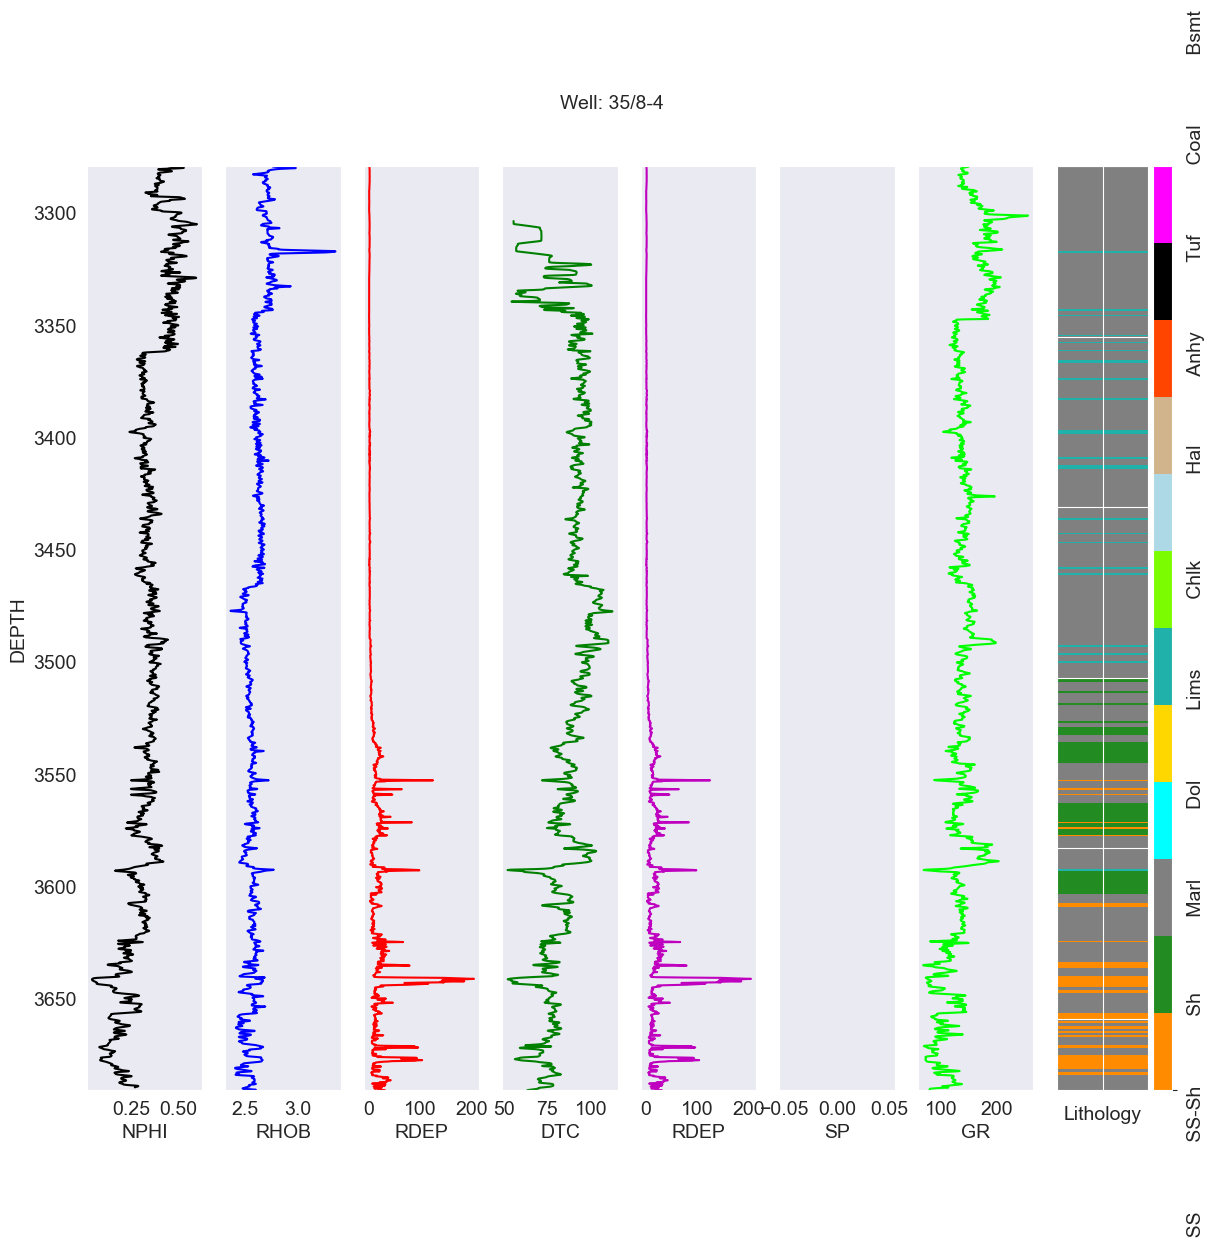

In [118]:
well_no = 1
make_facies_log_plot(val_df[val_df['WELL'] == wells_names[well_no]], logs, wells_names[well_no], facies_colors)

In [183]:
clf_xgboost = xgb.XGBClassifier(
                                n_estimators = 108,
                                learning_rate = 0.058341077396837984,
                                max_depth = 10,
                                min_child_weight = 3.975751644687145,
                                gamma = 3.2978917680925592,
                                subsample = 0.660954379979485,
                                colsample_bytree = 0.35601189656690413
                                )

In [185]:
clf_xgboost.fit(X_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.35601189656690413, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=3.2978917680925592,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.058341077396837984,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=3.975751644687145, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=108,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [186]:
train_preds_clf_xgboost = clf_xgboost.predict(X_train)
train_preds_clf_xgboost

array([9, 9, 9, ..., 8, 8, 9], dtype=int64)

In [187]:
accuracy_score(train_preds_clf_xgboost, y_train_encoded)

0.8380161655615258

In [181]:
clf_xgboost.score(inputs_train, y_train)

0.8291776251591498

In [188]:
val_preds_clf_xgboost = clf_xgboost.predict(X_val)
val_preds_clf_xgboost

array([9, 9, 9, ..., 9, 9, 9], dtype=int64)

In [189]:
from sklearn.metrics import accuracy_score

# Преобразуем строковые метки классов в числовые метки для валидационного набора данных
numeric_targets_val = label_encoder.fit_transform(y_val)

# Вычисляем предсказания модели для валидационного набора данных
val_preds_clf_xgboost = clf_xgboost.predict(X_val)

# Вычисляем точность модели на валидационном наборе данных
accuracy_score(val_preds_clf_xgboost, numeric_targets_val)

0.6888824244439135

In [ ]:
accuracy_score(val_preds_clf_xgboost, targets_val)

In [ ]:
clf_xgboost.score(inputs_val, targets_val)

### 4.6 LGBM Classifier

In [183]:
param = {'num_leaves': 150, #120,
         'num_iterations': 500, #400,
         'max_depth': 15,
         'learning_rate': 0.05,
         'feature_fraction': 0.4, #0.5,
         'class_weight': None,
         'bagging_fraction': 0.9 #0.8
        }

In [184]:
seed_value = 42
np.random.seed(seed_value)


In [185]:
model_lgbm = lgbm.LGBMClassifier(learning_rate=param['learning_rate'], max_depth=param['max_depth'],
                               num_leaves=param['num_leaves'], num_iterations=param['num_iterations'], 
                               feature_fraction=param['feature_fraction'], class_weight= None, 
                               bagging_fraction=param['bagging_fraction'], silent='False',
                               random_state=seed_value, objective = 'multiclass', num_class = 12)

In [186]:
model_lgbm.fit(inputs_train, targets_train)

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2568
[LightGBM] [Info] Number of data points in the train set: 1076030, number of used features: 11
[LightGBM] [Info] Start training from score -6.899454
[LightGBM] [Info] Start training from score -9.254060
[LightGBM] [Info] Start t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMClassifier(bagging_fraction=0.9, feature_fraction=0.4, learning_rate=0.05,
               max_depth=15, num_class=12, num_iterations=500, num_leaves=150,
               objective='multiclass', random_state=42, silent='False')

In [ ]:
train_preds_lgbm = model_lgbm.predict(inputs_train)
train_preds_lgbm

In [ ]:
accuracy_score(train_preds_lgbm, targets_train)

In [ ]:
model_lgbm.score(inputs_train, targets_train)

In [ ]:
val_preds_lgbm = model_lgbm.predict(inputs_val)
val_preds_lgbm

In [ ]:
accuracy_score(val_preds_lgbm, targets_val)

In [ ]:
model_lgbm.score(inputs_val, targets_val)

### 4.7 Catboost Classifier

In [ ]:
%%time

catboost_classifier = CatBoostClassifier()

CatBoost_params = {
    'iterations': [1200, 300, 400, 500],  # количество итераций
    'learning_rate': [0.01, 0.05, 0.1],  # скорость обучения
    'depth': [4, 6, 8],  # глубина деревьев
    'l2_leaf_reg': [1, 3, 5],  # коэффициент L2-регуляризации
    'border_count': [32, 64, 128],  # число бинов для числовых признаков
}


rs_catboost =  RandomizedSearchCV(estimator=catboost_classifier, param_distributions=CatBoost_params, cv=3, scoring='accuracy', n_iter=10, random_state=42)

rs_catboost.fit(inputs_train, targets_train)

In [ ]:
rs_catboost.best_params_

In [162]:
catboost_best_params = {'learning_rate': 0.01,
          'l2_leaf_reg': 1,
          'iterations': 400,
          'depth': 4,
          'border_count': 64}

catboost_classifier.set_params(**catboost_best_params)

In [163]:
%%time
catboost_classifier.fit(X_train, y_train)

0:	learn: 2.3482037	total: 589ms	remaining: 3m 55s
1:	learn: 2.3022828	total: 1.08s	remaining: 3m 34s
2:	learn: 2.2594621	total: 1.54s	remaining: 3m 24s
3:	learn: 2.2193696	total: 2.03s	remaining: 3m 20s
4:	learn: 2.1820696	total: 2.47s	remaining: 3m 15s
5:	learn: 2.1470372	total: 2.9s	remaining: 3m 10s
6:	learn: 2.1136992	total: 3.3s	remaining: 3m 5s
7:	learn: 2.0822654	total: 3.69s	remaining: 3m
8:	learn: 2.0521985	total: 4.09s	remaining: 2m 57s
9:	learn: 2.0239546	total: 4.47s	remaining: 2m 54s
10:	learn: 1.9968736	total: 4.88s	remaining: 2m 52s
11:	learn: 1.9711456	total: 5.28s	remaining: 2m 50s
12:	learn: 1.9464205	total: 5.7s	remaining: 2m 49s
13:	learn: 1.9227681	total: 6.11s	remaining: 2m 48s
14:	learn: 1.9000137	total: 6.49s	remaining: 2m 46s
15:	learn: 1.8782991	total: 6.95s	remaining: 2m 46s
16:	learn: 1.8571600	total: 7.4s	remaining: 2m 46s
17:	learn: 1.8367731	total: 7.8s	remaining: 2m 45s
18:	learn: 1.8173105	total: 8.25s	remaining: 2m 45s
19:	learn: 1.7985690	total: 8.72

158:	learn: 0.9754241	total: 1m 16s	remaining: 1m 55s
159:	learn: 0.9734819	total: 1m 16s	remaining: 1m 54s
160:	learn: 0.9717116	total: 1m 17s	remaining: 1m 54s
161:	learn: 0.9696892	total: 1m 17s	remaining: 1m 53s
162:	learn: 0.9679533	total: 1m 17s	remaining: 1m 53s
163:	learn: 0.9661502	total: 1m 18s	remaining: 1m 52s
164:	learn: 0.9645223	total: 1m 18s	remaining: 1m 51s
165:	learn: 0.9628682	total: 1m 18s	remaining: 1m 51s
166:	learn: 0.9610593	total: 1m 19s	remaining: 1m 50s
167:	learn: 0.9594658	total: 1m 19s	remaining: 1m 50s
168:	learn: 0.9577523	total: 1m 20s	remaining: 1m 49s
169:	learn: 0.9559126	total: 1m 20s	remaining: 1m 48s
170:	learn: 0.9543743	total: 1m 20s	remaining: 1m 48s
171:	learn: 0.9527655	total: 1m 21s	remaining: 1m 47s
172:	learn: 0.9511955	total: 1m 21s	remaining: 1m 47s
173:	learn: 0.9495626	total: 1m 22s	remaining: 1m 46s
174:	learn: 0.9477749	total: 1m 22s	remaining: 1m 46s
175:	learn: 0.9462208	total: 1m 22s	remaining: 1m 45s
176:	learn: 0.9445206	total:

312:	learn: 0.8214032	total: 2m 16s	remaining: 37.8s
313:	learn: 0.8208282	total: 2m 16s	remaining: 37.4s
314:	learn: 0.8202889	total: 2m 16s	remaining: 36.9s
315:	learn: 0.8198313	total: 2m 17s	remaining: 36.5s
316:	learn: 0.8192083	total: 2m 17s	remaining: 36.1s
317:	learn: 0.8187137	total: 2m 18s	remaining: 35.6s
318:	learn: 0.8182751	total: 2m 18s	remaining: 35.2s
319:	learn: 0.8177748	total: 2m 18s	remaining: 34.7s
320:	learn: 0.8172902	total: 2m 19s	remaining: 34.3s
321:	learn: 0.8168430	total: 2m 19s	remaining: 33.8s
322:	learn: 0.8164716	total: 2m 20s	remaining: 33.4s
323:	learn: 0.8160469	total: 2m 20s	remaining: 33s
324:	learn: 0.8155790	total: 2m 20s	remaining: 32.5s
325:	learn: 0.8151841	total: 2m 21s	remaining: 32.1s
326:	learn: 0.8148378	total: 2m 21s	remaining: 31.6s
327:	learn: 0.8143334	total: 2m 22s	remaining: 31.2s
328:	learn: 0.8137533	total: 2m 22s	remaining: 30.7s
329:	learn: 0.8132269	total: 2m 22s	remaining: 30.3s
330:	learn: 0.8126479	total: 2m 23s	remaining: 2

In [165]:
accuracy_score(y_train, catboost_classifier.predict(X_train))

0.7475810450866816

In [169]:
accuracy_score(y_val, catboost_classifier.predict(X_val))

0.6820618578122241

## 5. Сравнение метрик